## Exploring environment:

Imports:

In [ ]:
import gym
import ptan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

See one iteration of environment and check whether it works for you:

In [ ]:
env = gym.make('LunarLander-v2')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample())
    env.render()
    env.step(env.action_space.sample())
env.close()

## Algorithms implementation

We used PyTorch in this nodebook implementation. For algorithms implementation we were based on the code and  inspirations/consideratons from a book 'Deep Reinforcement Learning Hands-On" by Maxim Lapan. Github code from the book is accessible at: https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On

### REINFORCE

We create constructor class 'PolicyNetwork' for our neural network which operates in algorithm as a function approximator. 

In [97]:
class PolicyNetwork(nn.Module):
    """
    PGN-Policy Gradient Network (Function Approximator):
    
    - input size: number of observation states in environment
    - n_actions: number of actions in environment
    
    We will use neural network with one hidden layer, which 
    has one hidden layer with 128 neurons and ReLU activation function, 
    as was described in report. So, our vector of \theta parameters 
    will have 128 elements. 
    
    """
    # initialization function
    def __init__(self, input_size, n_actions):
        super(PolicyNetwork, self).__init__()
        # Creating a simple neural network with 128 parameters \theta
        # in one hidden layer 
        # Softmax activation will be done in the algorithm later.
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    
    # forward propagation function
    def forward(self, x):
        return self.net(x)

We also create function 'compute_q_vals' that iterates over rewards collected in an episode:

In [98]:
def compute_q_vals(rewards):
    """
    rewards: list of rewards collected in episode
    """
    res = []
    sum_r = 0.0
    # looping through the list of rewards in reverse order
    # because in REINFORCE (look at report pseudocode)
    # last action receives one last reward, pre-last action
    # receives pre-last reward plus discounted last etc.:
    for r in reversed(rewards):
        sum_r *= GAMMA
        sum_r += r
        res.append(sum_r)
    # we againg reverse our list of rewards per action
    # in the order actions appeared
    return list(reversed(res))


We will wrap up our simple REINFORCE algorithm in the following function:

In [99]:
def REINFORCE(learning_rate, gamma=0.99, num_episodes_train=4, env="LunarLander-v2", max_num_steps=3500000):
    """
    -learning rate:     coefficient, by which we multiply gradient in update rule
    
    -gamma:             discount coefficient from bellmann equation
    
    -num_episode_train: number of episodes in which we collect experience 
                        before performing learning
    
    -env:               environment used in training.
    
    -max_num_steps:     num of steps after which training established unsuccessful
    """
    
    #creating separate list for indexes of steps taken
    step_list = [] 
    #creating separate list for mean rewards of last 100 episodes
    mean_rewards_list = []
    #values of gradient vactor variance
    var_grad_list = []

    #creating an instance of 'LunarLander' environment using Gym library
    env = gym.make(env)   
    #creating an instance of above defined Policy Gradient Network
    #our input 
    net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
    # creating an artificial agent using library ptan, which under the hood
    # get network raw results and applies softmax activation to choose action
    # from the state
    agent = ptan.agent.PolicyAgent(net, preprocessor=ptan.agent.float32_preprocessor,
                                               apply_softmax=True)
    # create experience source with LunarLander environment
    exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=gamma)
    # we will use Adam optimizer as it is considered the only option
    # which really works in RL setting
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    #create list for collecting total rewards
    total_rewards = []
    
    # creating counters
    step_idx = 0
    done_episodes = 0
    batch_episodes = 0
    
    # creating empty list, where we will store batches of 
    # states, actions, q-values to use it in our policy 
    # gradient algo
    batch_states, batch_actions, batch_qvals = [], [], []
    cur_rewards = []
    # iterate over each step in environment until 
    # last episode in batch of episodes used for training 
    # is finished
    for step_idx, exp in enumerate(exp_source):
        batch_states.append(exp.state)
        batch_actions.append(int(exp.action))
        cur_rewards.append(exp.reward)
        # check whether episde
        if exp.last_state is None:
            batch_qvals.extend(compute_q_vals(cur_rewards))
            cur_rewards.clear()
            batch_episodes += 1

        new_rewards = exp_source.pop_total_rewards()
        
        # check whether episode ended
        # if episode ends then we will append all rewards to 
        # our total rewards list
        if new_rewards:
            done_episodes += 1
            reward = new_rewards[0]
            total_rewards.append(reward)
            
            # calculate mean reward per last 100 steps;
            # episode can contain more but we assume
            # that environment is solved if mean reward 
            # per 100 steps > 195
            mean_rewards = float(np.mean(total_rewards[-100:]))
            
            # monitor how our agent is learning 
            print("%d: reward: %6.2f, mean_100: %6.2f, episodes: %d" % (
                step_idx, reward, mean_rewards, done_episodes))
            
            # collecting steps, mean rewards and rewards_list in order
            # to use afterwards in comparing our algorithms
            step_list.append(step_idx)
            mean_rewards_list.append(mean_rewards)
            
            # check whether our environment is solved 
            if mean_rewards > 195:
                print("Solved in %d steps and %d episodes!" % (step_idx, done_episodes))
                break
                
            # establish some reasonable point of time
            # where there is no need to destroy our CPU
            elif step_idx > max_num_steps:
                print(0.01,':not_converged')
                print('')
                break
        # check whether we iterated over necessary
        # number of episode;
        
        # if not - continue to collect experience
        if batch_episodes < num_episodes_train:
            continue
        
        # setting the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # converting our lists to float tensors
        states_v = torch.FloatTensor(batch_states)
        batch_actions_t = torch.LongTensor(batch_actions)
        batch_qvals_v = torch.FloatTensor(batch_qvals)
        
        # doing forward propagation via our 128 randomly inialized weights
        logits_v = net(states_v)
        
        # outputting probabilities per each action
        log_prob_v = F.log_softmax(logits_v, dim=1)
        
        # multiplying our q-values with log probability 
        log_prob_actions_v = batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t]
        
        # averaging out our loss
        loss_v = -log_prob_actions_v.mean()
        
        #finding gradient of the loss
        loss_v.backward()
        
        #performing update rule 
        optimizer.step()
        
        
        grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                            for p in net.parameters()
                                            if p.grad is not None])

        var_grad_list.append(np.var(grads))
        
        #clearing out all accumulated experience before doing new iteration
        batch_episodes = 0
        batch_states.clear()
        batch_actions.clear()
        batch_qvals.clear()
        
    return step_list,mean_rewards_list,net

We will use our REINFORCE funtion with learning rate = 0.01 since in literature it is seen as the most workable option to start REINFORCE
with and then compare it with other often used rates:

In [4]:
step_list,mean_rewards_list,net = REINFORCE(0.01, gamma=0.99, num_episodes_train=4, env="LunarLander-v2", max_num_steps=3500000)

PGN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
68: reward: -24.10, mean_100: -24.10, episodes: 1
142: reward: -158.80, mean_100: -91.45, episodes: 2
199: reward: -115.85, mean_100: -99.59, episodes: 3
279: reward: -202.76, mean_100: -125.38, episodes: 4
359: reward: -360.03, mean_100: -172.31, episodes: 5
449: reward: -111.28, mean_100: -162.14, episodes: 6
541: reward: -104.58, mean_100: -153.91, episodes: 7
636: reward: -411.66, mean_100: -186.13, episodes: 8
736: reward: -340.29, mean_100: -203.26, episodes: 9
859: reward: -465.07, mean_100: -229.44, episodes: 10
936: reward: -152.31, mean_100: -222.43, episodes: 11
1010: reward: -316.94, mean_100: -230.31, episodes: 12
1102: reward: -439.70, mean_100: -246.41, episodes: 13
1181: reward: -356.82, mean_100: -254.30, episodes: 14
1319: reward: -578.42, mean_100: -275.91, episodes: 15
1397: reward: -479.14, mean_100:

18644: reward: -734.04, mean_100: -515.85, episodes: 147
18770: reward: -217.76, mean_100: -513.54, episodes: 148
18892: reward: -190.18, mean_100: -510.55, episodes: 149
19093: reward: -461.49, mean_100: -508.15, episodes: 150
19528: reward: -4931.19, mean_100: -555.03, episodes: 151
19693: reward: -384.93, mean_100: -558.02, episodes: 152
19782: reward: -366.06, mean_100: -560.06, episodes: 153
19939: reward: -204.44, mean_100: -555.67, episodes: 154
20056: reward: -234.05, mean_100: -555.25, episodes: 155
20161: reward: -369.91, mean_100: -558.21, episodes: 156
20376: reward: -871.97, mean_100: -560.28, episodes: 157
20538: reward: -419.88, mean_100: -562.13, episodes: 158
20680: reward: -847.55, mean_100: -569.15, episodes: 159
20843: reward: -586.86, mean_100: -569.64, episodes: 160
20952: reward: -439.95, mean_100: -572.50, episodes: 161
21069: reward: -243.57, mean_100: -569.83, episodes: 162
21226: reward: -527.63, mean_100: -572.82, episodes: 163
21341: reward: -334.86, mean_1

38966: reward: -359.07, mean_100: -687.27, episodes: 293
39063: reward: -649.10, mean_100: -683.82, episodes: 294
39147: reward: -589.00, mean_100: -682.68, episodes: 295
39236: reward: -390.41, mean_100: -682.80, episodes: 296
39480: reward: -890.78, mean_100: -684.88, episodes: 297
39668: reward: -931.34, mean_100: -690.09, episodes: 298
39848: reward: -715.96, mean_100: -692.97, episodes: 299
39979: reward:  -4.06, mean_100: -688.15, episodes: 300
40212: reward: -1892.45, mean_100: -700.21, episodes: 301
40439: reward: -1260.73, mean_100: -701.25, episodes: 302
40561: reward: -532.38, mean_100: -700.55, episodes: 303
40691: reward: -306.48, mean_100: -696.53, episodes: 304
40891: reward: -1062.21, mean_100: -701.80, episodes: 305
41078: reward: -449.42, mean_100: -701.55, episodes: 306
41249: reward: -918.22, mean_100: -707.85, episodes: 307
41370: reward: -59.35, mean_100: -704.09, episodes: 308
41531: reward: -281.78, mean_100: -703.42, episodes: 309
41721: reward: -1377.04, mean_

60210: reward: -65.17, mean_100: -219.92, episodes: 438
60310: reward: -67.95, mean_100: -209.13, episodes: 439
60439: reward: -55.92, mean_100: -205.41, episodes: 440
60543: reward: -40.20, mean_100: -200.67, episodes: 441
60623: reward: -97.25, mean_100: -200.92, episodes: 442
60729: reward: -63.22, mean_100: -200.61, episodes: 443
60833: reward: -93.97, mean_100: -192.08, episodes: 444
60979: reward: -98.18, mean_100: -186.01, episodes: 445
61083: reward: -60.61, mean_100: -179.64, episodes: 446
61204: reward: -103.17, mean_100: -158.93, episodes: 447
61285: reward: -68.14, mean_100: -158.82, episodes: 448
61373: reward: -42.88, mean_100: -150.02, episodes: 449
61522: reward: -76.44, mean_100: -150.05, episodes: 450
61613: reward: -90.36, mean_100: -145.64, episodes: 451
61702: reward: -95.57, mean_100: -138.34, episodes: 452
61873: reward:   2.88, mean_100: -138.00, episodes: 453
61966: reward: -43.99, mean_100: -137.97, episodes: 454
62068: reward: -85.78, mean_100: -138.53, episo

85193: reward: -65.47, mean_100: -96.45, episodes: 586
85415: reward: -89.14, mean_100: -96.02, episodes: 587
85507: reward: -26.97, mean_100: -96.45, episodes: 588
85617: reward: -65.67, mean_100: -95.73, episodes: 589
85733: reward: -22.45, mean_100: -94.80, episodes: 590
85852: reward:  -5.40, mean_100: -93.62, episodes: 591
85933: reward: -49.00, mean_100: -93.27, episodes: 592
86074: reward:  -5.20, mean_100: -91.77, episodes: 593
86243: reward:  -8.71, mean_100: -91.27, episodes: 594
86384: reward: -80.20, mean_100: -91.97, episodes: 595
86613: reward: -19.35, mean_100: -91.46, episodes: 596
86863: reward: -62.40, mean_100: -91.47, episodes: 597
87004: reward: -48.77, mean_100: -91.26, episodes: 598
87226: reward: -73.36, mean_100: -91.21, episodes: 599
87368: reward: -56.40, mean_100: -90.83, episodes: 600
87477: reward:   7.90, mean_100: -89.82, episodes: 601
87587: reward:   3.46, mean_100: -88.25, episodes: 602
87744: reward: -30.58, mean_100: -88.27, episodes: 603
87835: rew

117505: reward: -82.36, mean_100: -28.80, episodes: 734
117623: reward: -79.87, mean_100: -29.42, episodes: 735
117743: reward:  11.39, mean_100: -29.22, episodes: 736
117863: reward: -85.44, mean_100: -30.24, episodes: 737
118104: reward: -77.62, mean_100: -29.95, episodes: 738
118266: reward: -36.70, mean_100: -28.20, episodes: 739
118399: reward: -24.97, mean_100: -28.74, episodes: 740
118576: reward: -35.44, mean_100: -28.37, episodes: 741
118747: reward: -22.68, mean_100: -28.87, episodes: 742
118868: reward:  -4.07, mean_100: -29.30, episodes: 743
119046: reward: -56.47, mean_100: -29.53, episodes: 744
119190: reward:   9.17, mean_100: -29.09, episodes: 745
119413: reward:  20.22, mean_100: -28.74, episodes: 746
119634: reward: -50.87, mean_100: -28.60, episodes: 747
119773: reward:   7.12, mean_100: -27.50, episodes: 748
119982: reward:  -0.91, mean_100: -27.73, episodes: 749
120089: reward: -32.75, mean_100: -27.53, episodes: 750
120275: reward: -10.16, mean_100: -27.55, episod

174650: reward:  17.02, mean_100: -27.00, episodes: 881
174921: reward:   6.20, mean_100: -26.95, episodes: 882
175107: reward:  -3.62, mean_100: -27.29, episodes: 883
175258: reward: -43.35, mean_100: -26.06, episodes: 884
175453: reward:  -7.56, mean_100: -26.14, episodes: 885
176454: reward:  60.26, mean_100: -25.87, episodes: 886
176691: reward:   7.95, mean_100: -25.90, episodes: 887
177366: reward: -287.91, mean_100: -28.54, episodes: 888
177684: reward:  20.48, mean_100: -28.32, episodes: 889
177914: reward: -51.70, mean_100: -29.53, episodes: 890
178097: reward:  31.38, mean_100: -29.72, episodes: 891
178248: reward:  44.71, mean_100: -29.87, episodes: 892
178956: reward: -191.19, mean_100: -31.12, episodes: 893
179607: reward: -88.61, mean_100: -31.51, episodes: 894
180608: reward:  21.32, mean_100: -31.64, episodes: 895
181198: reward: -59.65, mean_100: -31.91, episodes: 896
181329: reward:  32.63, mean_100: -31.18, episodes: 897
181789: reward: -146.86, mean_100: -32.48, epi

239684: reward: -66.26, mean_100:  -3.48, episodes: 1028
240116: reward: -94.27, mean_100:  -4.87, episodes: 1029
240679: reward: 167.34, mean_100:  -3.38, episodes: 1030
241185: reward: 220.99, mean_100:  -2.54, episodes: 1031
241579: reward: -86.89, mean_100:  -1.35, episodes: 1032
242389: reward: 121.27, mean_100:  -0.15, episodes: 1033
242873: reward: -56.56, mean_100:  -3.23, episodes: 1034
243358: reward: -191.29, mean_100:  -4.99, episodes: 1035
243574: reward:  28.38, mean_100:  -4.59, episodes: 1036
243994: reward: 183.44, mean_100:  -2.53, episodes: 1037
244401: reward: 183.55, mean_100:  -0.75, episodes: 1038
244754: reward: 208.49, mean_100:   2.97, episodes: 1039
245028: reward: -45.92, mean_100:   2.78, episodes: 1040
245186: reward:  19.23, mean_100:   3.26, episodes: 1041
245651: reward: 175.52, mean_100:   3.10, episodes: 1042
245859: reward:  32.31, mean_100:   5.25, episodes: 1043
246389: reward: -57.95, mean_100:   4.49, episodes: 1044
246759: reward: -63.83, mean_1

299770: reward:  37.18, mean_100:  19.41, episodes: 1172
300103: reward: 213.18, mean_100:  19.74, episodes: 1173
300528: reward: -216.14, mean_100:  17.75, episodes: 1174
300707: reward:  36.91, mean_100:  20.09, episodes: 1175
300865: reward:   1.28, mean_100:  20.19, episodes: 1176
301101: reward:  29.30, mean_100:  19.82, episodes: 1177
301313: reward:  67.58, mean_100:  18.44, episodes: 1178
301513: reward:  23.75, mean_100:  20.79, episodes: 1179
301980: reward: 177.27, mean_100:  22.00, episodes: 1180
302518: reward: 167.61, mean_100:  25.93, episodes: 1181
302631: reward:  42.32, mean_100:  26.40, episodes: 1182
302923: reward: -159.19, mean_100:  24.80, episodes: 1183
303104: reward: -11.42, mean_100:  27.80, episodes: 1184
303298: reward:  -6.30, mean_100:  27.28, episodes: 1185
303486: reward: -16.52, mean_100:  27.69, episodes: 1186
303950: reward: -161.57, mean_100:  26.16, episodes: 1187
304061: reward:  -1.53, mean_100:  24.18, episodes: 1188
304195: reward:   7.73, mean

353160: reward:  92.64, mean_100:  53.19, episodes: 1316
353887: reward: 163.39, mean_100:  54.81, episodes: 1317
354568: reward: -268.89, mean_100:  51.60, episodes: 1318
354998: reward: -77.91, mean_100:  50.31, episodes: 1319
355456: reward: 249.54, mean_100:  52.76, episodes: 1320
355647: reward:  -5.49, mean_100:  50.37, episodes: 1321
356305: reward: 158.88, mean_100:  49.96, episodes: 1322
356699: reward: 136.02, mean_100:  52.13, episodes: 1323
356870: reward:  -5.14, mean_100:  50.61, episodes: 1324
357452: reward: -187.72, mean_100:  48.69, episodes: 1325
357731: reward:  13.40, mean_100:  48.63, episodes: 1326
357919: reward:  39.29, mean_100:  48.97, episodes: 1327
358135: reward:  37.40, mean_100:  49.16, episodes: 1328
358671: reward: 199.77, mean_100:  50.91, episodes: 1329
358980: reward: -29.55, mean_100:  51.98, episodes: 1330
359285: reward: -56.97, mean_100:  50.92, episodes: 1331
359515: reward:  23.88, mean_100:  52.66, episodes: 1332
359741: reward: -46.79, mean_

435696: reward: 186.60, mean_100:   1.69, episodes: 1460
436519: reward: -258.54, mean_100:   1.40, episodes: 1461
437154: reward: 121.74, mean_100:   2.99, episodes: 1462
437940: reward: -145.86, mean_100:   1.28, episodes: 1463
438176: reward:  25.46, mean_100:   0.14, episodes: 1464
439035: reward: -196.91, mean_100:  -2.08, episodes: 1465
439610: reward: -222.06, mean_100:  -3.68, episodes: 1466
440305: reward: 218.01, mean_100:  -3.44, episodes: 1467
441042: reward: 124.13, mean_100:  -0.64, episodes: 1468
441765: reward: -136.09, mean_100:  -2.27, episodes: 1469
442135: reward: -21.09, mean_100:  -3.33, episodes: 1470
442514: reward: 193.20, mean_100:  -1.44, episodes: 1471
442846: reward: -62.51, mean_100:  -2.17, episodes: 1472
443299: reward: 148.95, mean_100:  -1.00, episodes: 1473
444113: reward: 124.70, mean_100:   0.55, episodes: 1474
444621: reward: 125.04, mean_100:  -0.62, episodes: 1475
445222: reward: 177.18, mean_100:   0.19, episodes: 1476
445876: reward: 205.43, me

515531: reward: -99.31, mean_100:  65.32, episodes: 1605
516002: reward: 199.74, mean_100:  67.45, episodes: 1606
516206: reward:  10.78, mean_100:  65.46, episodes: 1607
516623: reward: -98.31, mean_100:  62.47, episodes: 1608
517029: reward: 227.92, mean_100:  65.21, episodes: 1609
517488: reward: 232.80, mean_100:  70.06, episodes: 1610
518144: reward: -152.86, mean_100:  71.06, episodes: 1611
518731: reward: 178.46, mean_100:  75.55, episodes: 1612
519244: reward: 155.23, mean_100:  75.61, episodes: 1613
519695: reward: 268.89, mean_100:  76.62, episodes: 1614
520089: reward: 206.70, mean_100:  76.67, episodes: 1615
520394: reward: 261.06, mean_100:  77.04, episodes: 1616
520901: reward: 225.92, mean_100:  81.50, episodes: 1617
521377: reward: 180.78, mean_100:  84.37, episodes: 1618
521926: reward: 181.02, mean_100:  84.64, episodes: 1619
522384: reward: 200.23, mean_100:  86.79, episodes: 1620
522620: reward:   1.44, mean_100:  87.51, episodes: 1621
523008: reward: 240.40, mean_1

572960: reward: 181.69, mean_100:  84.00, episodes: 1749
573093: reward:  10.09, mean_100:  83.65, episodes: 1750
573311: reward:   3.25, mean_100:  83.59, episodes: 1751
573561: reward: 244.31, mean_100:  83.57, episodes: 1752
573713: reward: -35.31, mean_100:  80.81, episodes: 1753
574162: reward: 187.54, mean_100:  80.70, episodes: 1754
574441: reward: 205.74, mean_100:  80.25, episodes: 1755
574573: reward: -61.67, mean_100:  78.16, episodes: 1756
574899: reward: 236.93, mean_100:  78.89, episodes: 1757
575071: reward: -32.17, mean_100:  75.85, episodes: 1758
575430: reward: 128.80, mean_100:  75.54, episodes: 1759
575559: reward: -19.09, mean_100:  76.66, episodes: 1760
575689: reward:  45.83, mean_100:  75.26, episodes: 1761
575916: reward: -69.78, mean_100:  75.94, episodes: 1762
576043: reward:  44.18, mean_100:  76.50, episodes: 1763
576315: reward: 176.93, mean_100:  78.26, episodes: 1764
576473: reward:  57.50, mean_100:  77.53, episodes: 1765
576851: reward: 190.03, mean_10

651148: reward: 115.08, mean_100:  56.13, episodes: 1893
651702: reward: 130.91, mean_100:  54.65, episodes: 1894
652703: reward:  35.12, mean_100:  56.49, episodes: 1895
653215: reward: 221.15, mean_100:  57.44, episodes: 1896
653572: reward: 183.27, mean_100:  62.18, episodes: 1897
654301: reward: -211.70, mean_100:  58.13, episodes: 1898
654939: reward: 204.38, mean_100:  57.96, episodes: 1899
655166: reward:   1.12, mean_100:  56.39, episodes: 1900
655467: reward: -35.46, mean_100:  57.47, episodes: 1901
656468: reward:  35.69, mean_100:  59.47, episodes: 1902
656700: reward:   0.54, mean_100:  59.22, episodes: 1903
656976: reward:  31.14, mean_100:  57.69, episodes: 1904
657977: reward:  52.81, mean_100:  56.06, episodes: 1905
658978: reward: 133.37, mean_100:  55.91, episodes: 1906
659586: reward: 212.41, mean_100:  60.45, episodes: 1907
660139: reward: 147.33, mean_100:  60.01, episodes: 1908
661140: reward:  14.33, mean_100:  58.76, episodes: 1909
661810: reward: 200.77, mean_1

729420: reward: -194.66, mean_100: 122.76, episodes: 2037
729983: reward: -192.20, mean_100: 118.47, episodes: 2038
730427: reward: 207.72, mean_100: 118.15, episodes: 2039
731093: reward: 210.20, mean_100: 120.40, episodes: 2040
731844: reward: 203.05, mean_100: 122.92, episodes: 2041
732156: reward: 209.87, mean_100: 123.13, episodes: 2042
732592: reward: 201.18, mean_100: 123.16, episodes: 2043
733236: reward: 182.36, mean_100: 123.87, episodes: 2044
734183: reward: 147.53, mean_100: 124.09, episodes: 2045
734660: reward: 226.09, mean_100: 124.30, episodes: 2046
735138: reward: 196.74, mean_100: 123.44, episodes: 2047
736139: reward:  43.22, mean_100: 121.41, episodes: 2048
736756: reward: 242.00, mean_100: 121.37, episodes: 2049
737275: reward: 200.77, mean_100: 121.03, episodes: 2050
737936: reward: 132.56, mean_100: 120.78, episodes: 2051
738566: reward: 227.38, mean_100: 120.36, episodes: 2052
739181: reward: -104.77, mean_100: 117.77, episodes: 2053
739990: reward: 207.28, mean

802617: reward: 182.62, mean_100: 133.40, episodes: 2181
803039: reward: 242.34, mean_100: 135.35, episodes: 2182
803442: reward: -124.07, mean_100: 132.57, episodes: 2183
803947: reward: 147.99, mean_100: 134.06, episodes: 2184
804537: reward: 131.64, mean_100: 135.85, episodes: 2185
805232: reward: 121.53, mean_100: 136.52, episodes: 2186
805777: reward: 220.31, mean_100: 136.93, episodes: 2187
806301: reward: -95.18, mean_100: 133.76, episodes: 2188
806850: reward: -62.50, mean_100: 131.78, episodes: 2189
807128: reward:  32.26, mean_100: 130.38, episodes: 2190
807797: reward: 133.78, mean_100: 129.51, episodes: 2191
808055: reward: -35.35, mean_100: 126.71, episodes: 2192
808588: reward: -162.35, mean_100: 123.28, episodes: 2193
809589: reward:  10.41, mean_100: 121.59, episodes: 2194
810109: reward: 210.60, mean_100: 123.81, episodes: 2195
810518: reward: 180.48, mean_100: 123.18, episodes: 2196
810921: reward: 246.31, mean_100: 124.26, episodes: 2197
811532: reward: 171.20, mean_

867044: reward: -156.68, mean_100: 141.66, episodes: 2325
867519: reward: 177.76, mean_100: 141.57, episodes: 2326
867890: reward: 200.15, mean_100: 145.28, episodes: 2327
868131: reward:  21.52, mean_100: 143.27, episodes: 2328
868707: reward: 130.70, mean_100: 141.77, episodes: 2329
869110: reward: 228.67, mean_100: 142.68, episodes: 2330
869819: reward: 202.75, mean_100: 142.17, episodes: 2331
870284: reward: -101.40, mean_100: 138.49, episodes: 2332
870677: reward: 157.47, mean_100: 140.43, episodes: 2333
871135: reward: 234.98, mean_100: 140.49, episodes: 2334
871440: reward: 239.52, mean_100: 141.05, episodes: 2335
871846: reward: 266.96, mean_100: 140.99, episodes: 2336
872189: reward: 269.53, mean_100: 141.71, episodes: 2337
872621: reward: 161.94, mean_100: 141.86, episodes: 2338
872976: reward: 260.07, mean_100: 141.78, episodes: 2339
873619: reward: 190.30, mean_100: 141.08, episodes: 2340
874188: reward: 131.25, mean_100: 139.60, episodes: 2341
874525: reward: 234.71, mean_

933642: reward: -107.41, mean_100: 102.81, episodes: 2469
934643: reward:  24.01, mean_100: 100.75, episodes: 2470
935644: reward:  27.53, mean_100: 101.11, episodes: 2471
936645: reward:  29.15, mean_100: 102.51, episodes: 2472
937646: reward:  -5.37, mean_100: 100.70, episodes: 2473
938343: reward: -172.48, mean_100:  96.79, episodes: 2474
939344: reward:  83.06, mean_100:  95.50, episodes: 2475
940345: reward:  48.73, mean_100:  93.82, episodes: 2476
941346: reward:  78.70, mean_100:  92.32, episodes: 2477
942347: reward: -115.67, mean_100:  88.33, episodes: 2478
943348: reward:  29.78, mean_100:  86.62, episodes: 2479
944349: reward:  44.20, mean_100:  86.77, episodes: 2480
945350: reward: -49.86, mean_100:  85.53, episodes: 2481
946351: reward: -11.54, mean_100:  82.71, episodes: 2482
947352: reward:  61.46, mean_100:  80.96, episodes: 2483
947548: reward:  33.84, mean_100:  79.06, episodes: 2484
948549: reward:  21.47, mean_100:  79.04, episodes: 2485
948850: reward:  -3.44, mean

1049958: reward:  10.46, mean_100:  43.59, episodes: 2612
1050959: reward:  34.53, mean_100:  43.37, episodes: 2613
1051087: reward:  52.67, mean_100:  43.40, episodes: 2614
1051222: reward:  48.06, mean_100:  43.67, episodes: 2615
1051745: reward: 225.14, mean_100:  45.29, episodes: 2616
1051927: reward:  76.00, mean_100:  45.53, episodes: 2617
1052928: reward:  56.44, mean_100:  45.81, episodes: 2618
1053512: reward: 175.09, mean_100:  47.09, episodes: 2619
1054513: reward:  92.57, mean_100:  48.23, episodes: 2620
1054646: reward:  33.94, mean_100:  48.03, episodes: 2621
1055602: reward: 198.66, mean_100:  49.26, episodes: 2622
1056603: reward:  92.84, mean_100:  49.55, episodes: 2623
1056965: reward: 228.88, mean_100:  51.29, episodes: 2624
1057966: reward:  97.38, mean_100:  52.02, episodes: 2625
1058967: reward:  73.67, mean_100:  52.57, episodes: 2626
1059120: reward:  52.21, mean_100:  52.76, episodes: 2627
1059478: reward: 235.78, mean_100:  54.69, episodes: 2628
1060479: rewar

1104757: reward: 266.73, mean_100: 116.49, episodes: 2754
1105119: reward: 244.81, mean_100: 116.61, episodes: 2755
1106120: reward: 105.99, mean_100: 117.19, episodes: 2756
1106628: reward: -156.36, mean_100: 117.26, episodes: 2757
1106781: reward:  37.69, mean_100: 114.80, episodes: 2758
1106940: reward:  56.90, mean_100: 115.60, episodes: 2759
1107527: reward: -94.07, mean_100: 112.12, episodes: 2760
1108105: reward: -59.87, mean_100: 110.85, episodes: 2761
1108542: reward: -146.11, mean_100: 109.50, episodes: 2762
1108877: reward: -131.30, mean_100: 106.04, episodes: 2763
1109228: reward: 241.89, mean_100: 105.98, episodes: 2764
1109593: reward: 206.56, mean_100: 105.42, episodes: 2765
1110093: reward: 213.58, mean_100: 107.16, episodes: 2766
1110810: reward: 189.56, mean_100: 108.72, episodes: 2767
1111811: reward:  34.97, mean_100: 106.27, episodes: 2768
1112283: reward: 224.71, mean_100: 108.14, episodes: 2769
1112435: reward:  38.60, mean_100: 108.22, episodes: 2770
1112668: re

1173072: reward: 143.08, mean_100:  74.28, episodes: 2896
1173217: reward:  66.36, mean_100:  74.51, episodes: 2897
1174218: reward: 152.22, mean_100:  75.59, episodes: 2898
1175219: reward: 110.86, mean_100:  76.25, episodes: 2899
1176220: reward: 144.81, mean_100:  77.22, episodes: 2900
1176387: reward:  17.82, mean_100:  74.98, episodes: 2901
1177388: reward: 173.74, mean_100:  76.23, episodes: 2902
1178389: reward: 153.19, mean_100:  76.25, episodes: 2903
1179390: reward: 173.16, mean_100:  77.47, episodes: 2904
1180391: reward: 116.30, mean_100:  77.90, episodes: 2905
1181392: reward: 125.87, mean_100:  79.04, episodes: 2906
1182393: reward: 152.82, mean_100:  79.43, episodes: 2907
1183394: reward: 174.91, mean_100:  78.59, episodes: 2908
1184395: reward: 158.43, mean_100:  80.02, episodes: 2909
1185396: reward: 141.84, mean_100:  80.98, episodes: 2910
1186397: reward: 157.39, mean_100:  81.99, episodes: 2911
1186590: reward:  -3.43, mean_100:  81.50, episodes: 2912
1187591: rewar

1297227: reward: 177.68, mean_100: 126.98, episodes: 3038
1297480: reward:  14.88, mean_100: 126.02, episodes: 3039
1298481: reward: 102.47, mean_100: 125.65, episodes: 3040
1299482: reward: 143.35, mean_100: 126.83, episodes: 3041
1300483: reward: 122.62, mean_100: 126.57, episodes: 3042
1301484: reward: 116.54, mean_100: 126.35, episodes: 3043
1302485: reward: 164.03, mean_100: 126.28, episodes: 3044
1303486: reward: 108.71, mean_100: 125.69, episodes: 3045
1304487: reward: 127.07, mean_100: 126.37, episodes: 3046
1305488: reward: 150.26, mean_100: 126.30, episodes: 3047
1306489: reward: 129.40, mean_100: 125.44, episodes: 3048
1307490: reward: 118.79, mean_100: 126.30, episodes: 3049
1308491: reward: 123.48, mean_100: 126.23, episodes: 3050
1309492: reward: 145.45, mean_100: 126.05, episodes: 3051
1310493: reward: 123.79, mean_100: 125.60, episodes: 3052
1311494: reward: 149.35, mean_100: 125.76, episodes: 3053
1312495: reward: 165.31, mean_100: 125.80, episodes: 3054
1313496: rewar

1426443: reward: 164.01, mean_100: 135.60, episodes: 3180
1427444: reward: 167.34, mean_100: 135.56, episodes: 3181
1428445: reward: 160.94, mean_100: 135.60, episodes: 3182
1429446: reward: 171.59, mean_100: 135.87, episodes: 3183
1430447: reward: 148.16, mean_100: 136.15, episodes: 3184
1431448: reward: 190.60, mean_100: 136.25, episodes: 3185
1432449: reward: 155.11, mean_100: 136.22, episodes: 3186
1433450: reward: 130.11, mean_100: 135.63, episodes: 3187
1433574: reward:  29.37, mean_100: 134.50, episodes: 3188
1434575: reward: 184.54, mean_100: 134.99, episodes: 3189
1435576: reward: 130.28, mean_100: 134.52, episodes: 3190
1436577: reward: 164.57, mean_100: 135.24, episodes: 3191
1437578: reward: 160.47, mean_100: 135.14, episodes: 3192
1437723: reward:  28.81, mean_100: 134.09, episodes: 3193
1438724: reward: 158.95, mean_100: 134.47, episodes: 3194
1438885: reward: -22.60, mean_100: 134.05, episodes: 3195
1439886: reward: 163.08, mean_100: 134.38, episodes: 3196
1440887: rewar

1532169: reward: 281.57, mean_100: 132.01, episodes: 3322
1532493: reward: 285.51, mean_100: 133.42, episodes: 3323
1532733: reward: -23.41, mean_100: 132.79, episodes: 3324
1533060: reward: 262.64, mean_100: 135.57, episodes: 3325
1533321: reward:  59.22, mean_100: 135.95, episodes: 3326
1533617: reward: 289.20, mean_100: 137.86, episodes: 3327
1533936: reward: 225.17, mean_100: 137.81, episodes: 3328
1534271: reward: 282.10, mean_100: 139.13, episodes: 3329
1534595: reward: 292.81, mean_100: 140.55, episodes: 3330
1534851: reward: 297.76, mean_100: 142.92, episodes: 3331
1535129: reward: 246.91, mean_100: 145.40, episodes: 3332
1535412: reward: 295.87, mean_100: 146.87, episodes: 3333
1535720: reward: 239.14, mean_100: 147.81, episodes: 3334
1536019: reward: 235.31, mean_100: 149.19, episodes: 3335
1536324: reward: 272.89, mean_100: 150.19, episodes: 3336
1536613: reward: 251.89, mean_100: 150.99, episodes: 3337
1536956: reward: 247.47, mean_100: 151.97, episodes: 3338
1537257: rewar

Let's save our model's weights to later look at it in action:

In [ ]:
torch.save(net.state_dict(), 'lunar_lander_model.pt')

Let's save result in order to compare it later with other $\alpha$:

In [17]:
df = pd.DataFrame()
df['mean_reward_100_steps'] = mean_rewards_list
df['steps'] = step_list
df.to_csv('reinforce_0.01.csv')

We will use then other two learning rates $0.1$ and $0.001$. We will also decrease our maximum number of steps to $1600000$ as this was number of steps needed for $0.01$ learning rate to converge:

In [39]:
# learn rate 0.001
step_list_001,mean_rewards_list_001,net_001 = REINFORCE(0.001, gamma=0.99, num_episodes_train=4, env="LunarLander-v2", max_num_steps=1600000)
df = pd.DataFrame()
# save results
df['mean_reward_100_steps'] = mean_rewards_list_001
df['steps'] = step_list_001
df.to_csv('reinforce_0.001.csv')

# learn rate 0.1
step_list_1,mean_rewards_list_1,net_001 = REINFORCE(0.1, gamma=0.99, num_episodes_train=4, env="LunarLander-v2", max_num_steps=1600000)
df = pd.DataFrame()
# save results
df['mean_reward_100_steps'] = mean_rewards_list_1
df['steps'] = step_list_1
df.to_csv('reinforce_0.1.csv')

PGN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
99: reward: -393.24, mean_100: -393.24, episodes: 1
170: reward: -80.48, mean_100: -236.86, episodes: 2
246: reward:  -9.41, mean_100: -161.04, episodes: 3
320: reward: -148.91, mean_100: -158.01, episodes: 4
395: reward: -135.07, mean_100: -153.42, episodes: 5
476: reward: -135.41, mean_100: -150.42, episodes: 6
545: reward: -119.86, mean_100: -146.05, episodes: 7
611: reward: -113.01, mean_100: -141.92, episodes: 8
686: reward: -18.78, mean_100: -128.24, episodes: 9
766: reward: -172.21, mean_100: -132.64, episodes: 10
850: reward: -209.73, mean_100: -139.65, episodes: 11
921: reward: -142.69, mean_100: -139.90, episodes: 12
1012: reward: -130.18, mean_100: -139.15, episodes: 13
1100: reward: -150.24, mean_100: -139.94, episodes: 14
1156: reward: -111.78, mean_100: -138.07, episodes: 15
1221: reward:  18.53, mean_100: 

10771: reward: -150.39, mean_100: -134.94, episodes: 152
10847: reward: -164.47, mean_100: -135.14, episodes: 153
10901: reward: -111.63, mean_100: -135.02, episodes: 154
10962: reward: -103.37, mean_100: -134.63, episodes: 155
11046: reward: -139.43, mean_100: -134.55, episodes: 156
11120: reward: -164.29, mean_100: -135.31, episodes: 157
11187: reward: -160.74, mean_100: -135.78, episodes: 158
11255: reward: -152.71, mean_100: -135.96, episodes: 159
11330: reward: -133.01, mean_100: -135.92, episodes: 160
11413: reward: -167.00, mean_100: -136.42, episodes: 161
11468: reward: -137.87, mean_100: -136.46, episodes: 162
11552: reward: -153.27, mean_100: -136.71, episodes: 163
11620: reward: -156.05, mean_100: -137.30, episodes: 164
11673: reward: -109.57, mean_100: -137.17, episodes: 165
11727: reward: -126.16, mean_100: -137.58, episodes: 166
11803: reward: -125.67, mean_100: -137.94, episodes: 167
11865: reward: -121.79, mean_100: -137.86, episodes: 168
11953: reward: -158.28, mean_10

21134: reward: -189.09, mean_100: -137.54, episodes: 300
21219: reward: -141.21, mean_100: -137.79, episodes: 301
21314: reward:  17.75, mean_100: -136.07, episodes: 302
21399: reward: -173.93, mean_100: -136.55, episodes: 303
21457: reward: -133.05, mean_100: -136.75, episodes: 304
21549: reward: -107.58, mean_100: -136.49, episodes: 305
21607: reward: -144.56, mean_100: -136.92, episodes: 306
21669: reward: -130.80, mean_100: -136.98, episodes: 307
21729: reward: -164.06, mean_100: -136.98, episodes: 308
21788: reward: -96.87, mean_100: -137.05, episodes: 309
21860: reward: -125.30, mean_100: -136.32, episodes: 310
21928: reward: -130.29, mean_100: -136.55, episodes: 311
21987: reward: -148.39, mean_100: -136.79, episodes: 312
22051: reward: -108.01, mean_100: -136.12, episodes: 313
22105: reward: -107.35, mean_100: -135.86, episodes: 314
22166: reward: -160.39, mean_100: -136.12, episodes: 315
22223: reward: -121.05, mean_100: -134.50, episodes: 316
22309: reward: -162.84, mean_100:

31809: reward: -114.64, mean_100: -134.95, episodes: 451
31877: reward: -148.04, mean_100: -135.06, episodes: 452
31945: reward: -160.10, mean_100: -135.53, episodes: 453
32010: reward: -153.60, mean_100: -135.83, episodes: 454
32085: reward: -139.08, mean_100: -135.79, episodes: 455
32147: reward: -154.54, mean_100: -135.91, episodes: 456
32200: reward: -133.25, mean_100: -137.22, episodes: 457
32260: reward: -96.64, mean_100: -136.70, episodes: 458
32334: reward: -157.79, mean_100: -137.02, episodes: 459
32426: reward: -93.47, mean_100: -136.37, episodes: 460
32505: reward: -142.71, mean_100: -136.51, episodes: 461
32568: reward:  20.29, mean_100: -134.98, episodes: 462
32655: reward: -179.48, mean_100: -135.25, episodes: 463
32722: reward: -137.46, mean_100: -135.05, episodes: 464
32778: reward: -133.60, mean_100: -134.92, episodes: 465
32830: reward: -135.72, mean_100: -135.18, episodes: 466
32885: reward: -92.65, mean_100: -135.12, episodes: 467
32939: reward: -133.65, mean_100: -

42045: reward: -204.09, mean_100: -128.94, episodes: 598
42133: reward: -121.16, mean_100: -128.47, episodes: 599
42187: reward: -131.03, mean_100: -128.36, episodes: 600
42274: reward: -103.45, mean_100: -128.40, episodes: 601
42357: reward: -125.33, mean_100: -128.11, episodes: 602
42419: reward: -121.78, mean_100: -128.29, episodes: 603
42474: reward: -113.86, mean_100: -128.07, episodes: 604
42545: reward: -170.68, mean_100: -128.64, episodes: 605
42611: reward: -171.16, mean_100: -128.78, episodes: 606
42670: reward: -133.56, mean_100: -128.76, episodes: 607
42743: reward: -178.61, mean_100: -129.52, episodes: 608
42818: reward: -179.25, mean_100: -130.11, episodes: 609
42875: reward: -145.14, mean_100: -130.28, episodes: 610
42956: reward: -159.24, mean_100: -129.92, episodes: 611
43025: reward: -138.66, mean_100: -130.08, episodes: 612
43099: reward:  -3.83, mean_100: -128.94, episodes: 613
43193: reward: -302.52, mean_100: -130.27, episodes: 614
43264: reward: -128.22, mean_100

52795: reward: -190.36, mean_100: -127.08, episodes: 748
52879: reward: -161.98, mean_100: -127.58, episodes: 749
52934: reward: -125.55, mean_100: -127.58, episodes: 750
53008: reward: -178.62, mean_100: -128.19, episodes: 751
53071: reward: -135.61, mean_100: -128.00, episodes: 752
53126: reward: -90.64, mean_100: -127.72, episodes: 753
53202: reward: -185.04, mean_100: -128.18, episodes: 754
53287: reward: -135.50, mean_100: -127.99, episodes: 755
53344: reward: -93.95, mean_100: -127.77, episodes: 756
53398: reward: -111.75, mean_100: -127.80, episodes: 757
53452: reward: -110.96, mean_100: -127.16, episodes: 758
53529: reward: -161.13, mean_100: -127.36, episodes: 759
53612: reward: -155.15, mean_100: -127.54, episodes: 760
53683: reward: -86.99, mean_100: -127.14, episodes: 761
53768: reward: -132.37, mean_100: -127.32, episodes: 762
53837: reward: -124.91, mean_100: -127.10, episodes: 763
53929: reward: -100.55, mean_100: -126.90, episodes: 764
54001: reward: -185.18, mean_100: 

63136: reward: -88.10, mean_100: -129.44, episodes: 897
63198: reward: -149.52, mean_100: -129.24, episodes: 898
63287: reward: -198.22, mean_100: -129.84, episodes: 899
63345: reward: -129.16, mean_100: -129.69, episodes: 900
63427: reward: -176.32, mean_100: -131.00, episodes: 901
63497: reward: -120.35, mean_100: -130.38, episodes: 902
63555: reward: -127.03, mean_100: -130.41, episodes: 903
63632: reward: -141.63, mean_100: -130.25, episodes: 904
63691: reward: -115.46, mean_100: -130.21, episodes: 905
63767: reward: -155.39, mean_100: -130.46, episodes: 906
63823: reward: -93.83, mean_100: -130.42, episodes: 907
63913: reward: -162.05, mean_100: -131.02, episodes: 908
63972: reward: -115.84, mean_100: -130.98, episodes: 909
64031: reward: -126.38, mean_100: -131.13, episodes: 910
64109: reward: -127.90, mean_100: -131.10, episodes: 911
64184: reward: -169.98, mean_100: -130.86, episodes: 912
64254: reward: -131.90, mean_100: -130.79, episodes: 913
64329: reward: -125.34, mean_100:

73791: reward: -48.80, mean_100: -129.20, episodes: 1046
73872: reward: -139.60, mean_100: -130.44, episodes: 1047
73930: reward: -125.75, mean_100: -130.24, episodes: 1048
74000: reward: -112.53, mean_100: -130.11, episodes: 1049
74097: reward:  25.63, mean_100: -128.28, episodes: 1050
74157: reward: -143.40, mean_100: -128.23, episodes: 1051
74232: reward:   5.05, mean_100: -126.99, episodes: 1052
74323: reward: -214.05, mean_100: -127.57, episodes: 1053
74386: reward: -161.24, mean_100: -128.50, episodes: 1054
74476: reward: -196.46, mean_100: -128.93, episodes: 1055
74544: reward: -138.84, mean_100: -129.42, episodes: 1056
74610: reward: -146.93, mean_100: -129.71, episodes: 1057
74696: reward: -135.67, mean_100: -129.97, episodes: 1058
74763: reward: -113.32, mean_100: -129.79, episodes: 1059
74833: reward: -162.90, mean_100: -130.19, episodes: 1060
74913: reward:  -3.58, mean_100: -129.24, episodes: 1061
74978: reward: -140.70, mean_100: -129.31, episodes: 1062
75047: reward: -18

84218: reward: -47.67, mean_100: -134.35, episodes: 1190
84283: reward: -113.69, mean_100: -133.58, episodes: 1191
84347: reward: -155.73, mean_100: -133.36, episodes: 1192
84428: reward: -105.65, mean_100: -132.74, episodes: 1193
84520: reward: -102.26, mean_100: -132.49, episodes: 1194
84609: reward: -176.97, mean_100: -132.96, episodes: 1195
84699: reward: -218.12, mean_100: -133.95, episodes: 1196
84757: reward: -121.83, mean_100: -134.22, episodes: 1197
84812: reward: -138.67, mean_100: -134.37, episodes: 1198
84867: reward: -114.75, mean_100: -134.52, episodes: 1199
84957: reward: -110.10, mean_100: -131.69, episodes: 1200
85041: reward: -171.37, mean_100: -131.85, episodes: 1201
85101: reward: -101.95, mean_100: -131.89, episodes: 1202
85159: reward: -116.55, mean_100: -131.93, episodes: 1203
85219: reward: -102.51, mean_100: -131.68, episodes: 1204
85305: reward: -166.55, mean_100: -132.28, episodes: 1205
85384: reward: -123.14, mean_100: -132.10, episodes: 1206
85448: reward: 

94499: reward: -91.44, mean_100: -133.52, episodes: 1336
94555: reward: -96.14, mean_100: -133.10, episodes: 1337
94610: reward: -136.70, mean_100: -134.76, episodes: 1338
94668: reward: -112.82, mean_100: -134.65, episodes: 1339
94760: reward: -201.75, mean_100: -135.07, episodes: 1340
94844: reward: -182.99, mean_100: -135.63, episodes: 1341
94900: reward: -113.57, mean_100: -135.75, episodes: 1342
94987: reward: -102.92, mean_100: -135.30, episodes: 1343
95064: reward: -134.61, mean_100: -134.99, episodes: 1344
95119: reward: -131.16, mean_100: -134.97, episodes: 1345
95217: reward: -41.92, mean_100: -134.37, episodes: 1346
95274: reward: -112.45, mean_100: -133.73, episodes: 1347
95344: reward: -162.66, mean_100: -134.14, episodes: 1348
95423: reward: -165.60, mean_100: -134.39, episodes: 1349
95476: reward: -80.11, mean_100: -133.78, episodes: 1350
95530: reward: -120.12, mean_100: -133.52, episodes: 1351
95591: reward: -102.27, mean_100: -133.23, episodes: 1352
95657: reward: -16

104682: reward: -123.86, mean_100: -140.93, episodes: 1477
104746: reward: -129.98, mean_100: -140.78, episodes: 1478
104807: reward: -151.37, mean_100: -141.48, episodes: 1479
104895: reward: -129.20, mean_100: -141.24, episodes: 1480
104959: reward: -139.60, mean_100: -141.32, episodes: 1481
105046: reward: -139.65, mean_100: -140.02, episodes: 1482
105135: reward:   7.48, mean_100: -138.70, episodes: 1483
105195: reward: -138.78, mean_100: -138.72, episodes: 1484
105269: reward: -147.30, mean_100: -138.84, episodes: 1485
105337: reward: -117.82, mean_100: -139.14, episodes: 1486
105421: reward: -174.32, mean_100: -139.39, episodes: 1487
105480: reward: -124.82, mean_100: -140.02, episodes: 1488
105539: reward: -143.18, mean_100: -139.51, episodes: 1489
105614: reward: -134.28, mean_100: -139.64, episodes: 1490
105671: reward: -128.76, mean_100: -139.50, episodes: 1491
105753: reward: -123.07, mean_100: -139.45, episodes: 1492
105826: reward: -142.00, mean_100: -139.67, episodes: 149

115229: reward: -114.04, mean_100: -142.96, episodes: 1624
115316: reward: -92.01, mean_100: -142.76, episodes: 1625
115386: reward: -141.73, mean_100: -142.29, episodes: 1626
115443: reward: -103.11, mean_100: -141.80, episodes: 1627
115504: reward: -133.12, mean_100: -141.61, episodes: 1628
115560: reward: -130.55, mean_100: -141.58, episodes: 1629
115643: reward: -113.06, mean_100: -141.08, episodes: 1630
115731: reward: -93.90, mean_100: -141.03, episodes: 1631
115797: reward: -155.10, mean_100: -141.31, episodes: 1632
115881: reward: -176.25, mean_100: -141.54, episodes: 1633
115955: reward: -122.53, mean_100: -141.40, episodes: 1634
116026: reward: -152.26, mean_100: -141.09, episodes: 1635
116083: reward: -137.49, mean_100: -140.95, episodes: 1636
116147: reward: -106.81, mean_100: -140.67, episodes: 1637
116200: reward: -81.51, mean_100: -140.13, episodes: 1638
116255: reward: -106.62, mean_100: -139.85, episodes: 1639
116337: reward: -122.42, mean_100: -139.79, episodes: 1640


125298: reward: -153.75, mean_100: -127.34, episodes: 1765
125385: reward: -206.36, mean_100: -128.07, episodes: 1766
125458: reward: -149.04, mean_100: -128.00, episodes: 1767
125527: reward: -135.85, mean_100: -128.98, episodes: 1768
125594: reward: -181.04, mean_100: -129.29, episodes: 1769
125664: reward: -130.49, mean_100: -128.95, episodes: 1770
125719: reward: -107.05, mean_100: -128.46, episodes: 1771
125788: reward: -144.65, mean_100: -128.69, episodes: 1772
125876: reward: -126.62, mean_100: -128.75, episodes: 1773
125938: reward: -153.86, mean_100: -127.49, episodes: 1774
126020: reward: -166.51, mean_100: -127.72, episodes: 1775
126073: reward: -80.16, mean_100: -127.02, episodes: 1776
126147: reward: -159.52, mean_100: -126.64, episodes: 1777
126199: reward: -133.69, mean_100: -126.61, episodes: 1778
126263: reward: -150.35, mean_100: -126.54, episodes: 1779
126346: reward: -164.15, mean_100: -126.87, episodes: 1780
126410: reward: -123.95, mean_100: -126.43, episodes: 178

135201: reward: -117.45, mean_100: -127.37, episodes: 1906
135257: reward: -87.94, mean_100: -127.03, episodes: 1907
135337: reward: -158.70, mean_100: -127.46, episodes: 1908
135395: reward: -103.78, mean_100: -127.07, episodes: 1909
135481: reward: -92.90, mean_100: -127.08, episodes: 1910
135547: reward: -140.68, mean_100: -127.17, episodes: 1911
135602: reward: -89.35, mean_100: -126.85, episodes: 1912
135666: reward: -128.61, mean_100: -127.04, episodes: 1913
135727: reward: -105.17, mean_100: -126.46, episodes: 1914
135787: reward: -141.33, mean_100: -126.20, episodes: 1915
135886: reward: -271.95, mean_100: -127.53, episodes: 1916
135959: reward: -103.90, mean_100: -127.40, episodes: 1917
136014: reward: -121.60, mean_100: -127.56, episodes: 1918
136072: reward: -120.45, mean_100: -127.45, episodes: 1919
136163: reward: -200.99, mean_100: -128.33, episodes: 1920
136242: reward: -164.90, mean_100: -129.05, episodes: 1921
136298: reward: -155.64, mean_100: -129.41, episodes: 1922


145581: reward: -128.32, mean_100: -133.19, episodes: 2052
145649: reward: -152.88, mean_100: -133.21, episodes: 2053
145702: reward: -117.77, mean_100: -134.46, episodes: 2054
145775: reward: -127.91, mean_100: -134.35, episodes: 2055
145837: reward: -125.57, mean_100: -134.40, episodes: 2056
145899: reward: -109.90, mean_100: -134.05, episodes: 2057
145979: reward: -175.86, mean_100: -134.64, episodes: 2058
146033: reward: -129.05, mean_100: -134.10, episodes: 2059
146111: reward: -22.82, mean_100: -132.50, episodes: 2060
146183: reward: -166.30, mean_100: -132.55, episodes: 2061
146252: reward: -140.19, mean_100: -132.64, episodes: 2062
146338: reward: -189.38, mean_100: -132.79, episodes: 2063
146394: reward: -131.73, mean_100: -132.81, episodes: 2064
146457: reward: -128.91, mean_100: -134.51, episodes: 2065
146526: reward: -138.07, mean_100: -134.28, episodes: 2066
146611: reward: -111.11, mean_100: -133.77, episodes: 2067
146681: reward: -173.22, mean_100: -134.54, episodes: 206

155402: reward: -41.00, mean_100: -126.63, episodes: 2194
155479: reward: -110.65, mean_100: -126.44, episodes: 2195
155553: reward: -147.16, mean_100: -126.41, episodes: 2196
155672: reward: -352.60, mean_100: -128.82, episodes: 2197
155758: reward: -96.43, mean_100: -128.22, episodes: 2198
155824: reward: -132.62, mean_100: -129.23, episodes: 2199
155902: reward: -157.47, mean_100: -129.53, episodes: 2200
155985: reward: -124.52, mean_100: -129.30, episodes: 2201
156049: reward: -166.79, mean_100: -130.72, episodes: 2202
156140: reward: -210.84, mean_100: -131.61, episodes: 2203
156234: reward: -166.46, mean_100: -131.78, episodes: 2204
156287: reward: -104.34, mean_100: -131.92, episodes: 2205
156378: reward: -85.37, mean_100: -131.52, episodes: 2206
156450: reward: -124.40, mean_100: -131.65, episodes: 2207
156523: reward: -125.35, mean_100: -131.23, episodes: 2208
156591: reward: -157.46, mean_100: -131.65, episodes: 2209
156672: reward: -143.36, mean_100: -131.46, episodes: 2210


165873: reward: -118.13, mean_100: -133.20, episodes: 2338
165929: reward: -116.96, mean_100: -132.32, episodes: 2339
165987: reward: -143.68, mean_100: -132.61, episodes: 2340
166065: reward: -156.90, mean_100: -132.91, episodes: 2341
166120: reward: -125.36, mean_100: -132.53, episodes: 2342
166177: reward: -79.16, mean_100: -131.84, episodes: 2343
166262: reward: -127.88, mean_100: -131.77, episodes: 2344
166324: reward: -136.96, mean_100: -132.01, episodes: 2345
166383: reward: -153.79, mean_100: -132.19, episodes: 2346
166440: reward: -112.54, mean_100: -132.37, episodes: 2347
166495: reward: -82.20, mean_100: -131.94, episodes: 2348
166576: reward: -106.05, mean_100: -131.67, episodes: 2349
166655: reward: -169.08, mean_100: -131.81, episodes: 2350
166740: reward: -16.24, mean_100: -130.58, episodes: 2351
166819: reward: -137.17, mean_100: -131.07, episodes: 2352
166879: reward: -118.98, mean_100: -130.95, episodes: 2353
166967: reward: -137.60, mean_100: -131.73, episodes: 2354


176121: reward: -123.90, mean_100: -131.73, episodes: 2481
176198: reward: -191.58, mean_100: -134.00, episodes: 2482
176271: reward: -156.63, mean_100: -134.48, episodes: 2483
176375: reward: -376.73, mean_100: -136.82, episodes: 2484
176455: reward: -129.44, mean_100: -136.65, episodes: 2485
176509: reward: -131.17, mean_100: -136.80, episodes: 2486
176590: reward: -60.33, mean_100: -135.42, episodes: 2487
176658: reward: -140.50, mean_100: -135.50, episodes: 2488
176725: reward: -140.30, mean_100: -135.52, episodes: 2489
176786: reward: -100.64, mean_100: -134.50, episodes: 2490
176860: reward: -161.70, mean_100: -134.91, episodes: 2491
176926: reward: -135.52, mean_100: -134.95, episodes: 2492
176978: reward: -107.82, mean_100: -134.42, episodes: 2493
177043: reward: -139.74, mean_100: -134.94, episodes: 2494
177119: reward: -137.21, mean_100: -135.15, episodes: 2495
177184: reward: -115.69, mean_100: -135.31, episodes: 2496
177251: reward: -117.79, mean_100: -135.15, episodes: 249

186045: reward: -161.27, mean_100: -133.62, episodes: 2624
186108: reward: -115.24, mean_100: -133.35, episodes: 2625
186166: reward: -138.95, mean_100: -133.76, episodes: 2626
186252: reward: -148.85, mean_100: -133.65, episodes: 2627
186325: reward: -125.23, mean_100: -133.95, episodes: 2628
186411: reward: -168.89, mean_100: -133.83, episodes: 2629
186467: reward: -27.58, mean_100: -132.87, episodes: 2630
186540: reward: -121.17, mean_100: -133.09, episodes: 2631
186614: reward: -160.64, mean_100: -133.39, episodes: 2632
186691: reward: -137.30, mean_100: -133.28, episodes: 2633
186772: reward: -106.98, mean_100: -132.97, episodes: 2634
186837: reward: -139.57, mean_100: -132.74, episodes: 2635
186917: reward: -133.97, mean_100: -132.97, episodes: 2636
186979: reward: -135.77, mean_100: -132.90, episodes: 2637
187051: reward: -123.50, mean_100: -133.01, episodes: 2638
187121: reward: -168.13, mean_100: -133.12, episodes: 2639
187213: reward: -139.72, mean_100: -133.15, episodes: 264

196435: reward: -135.79, mean_100: -129.53, episodes: 2772
196522: reward: -137.82, mean_100: -129.73, episodes: 2773
196585: reward: -162.50, mean_100: -130.76, episodes: 2774
196642: reward: -130.58, mean_100: -131.08, episodes: 2775
196732: reward: -179.41, mean_100: -131.57, episodes: 2776
196800: reward: -77.70, mean_100: -130.86, episodes: 2777
196857: reward: -98.67, mean_100: -130.54, episodes: 2778
196928: reward: -161.55, mean_100: -130.59, episodes: 2779
196993: reward: -133.00, mean_100: -130.53, episodes: 2780
197071: reward: -168.23, mean_100: -130.97, episodes: 2781
197126: reward: -137.69, mean_100: -131.20, episodes: 2782
197200: reward: -167.58, mean_100: -131.40, episodes: 2783
197285: reward: -130.99, mean_100: -131.19, episodes: 2784
197344: reward: -123.13, mean_100: -131.34, episodes: 2785
197415: reward: -122.46, mean_100: -130.85, episodes: 2786
197475: reward: -129.21, mean_100: -131.30, episodes: 2787
197534: reward: -139.33, mean_100: -131.43, episodes: 2788

206263: reward: -101.28, mean_100: -125.00, episodes: 2913
206326: reward: -121.91, mean_100: -124.83, episodes: 2914
206384: reward: -131.26, mean_100: -124.74, episodes: 2915
206455: reward: -147.83, mean_100: -124.43, episodes: 2916
206537: reward: -183.31, mean_100: -125.10, episodes: 2917
206629: reward: -125.60, mean_100: -125.17, episodes: 2918
206710: reward: -157.09, mean_100: -125.57, episodes: 2919
206771: reward: -115.97, mean_100: -125.59, episodes: 2920
206846: reward: -169.90, mean_100: -125.86, episodes: 2921
206915: reward: -137.44, mean_100: -125.73, episodes: 2922
206996: reward: -131.43, mean_100: -125.58, episodes: 2923
207079: reward: -105.81, mean_100: -125.21, episodes: 2924
207143: reward: -131.33, mean_100: -125.01, episodes: 2925
207199: reward: -111.13, mean_100: -125.76, episodes: 2926
207286: reward: -101.32, mean_100: -125.57, episodes: 2927
207352: reward: -138.19, mean_100: -125.88, episodes: 2928
207421: reward: -149.42, mean_100: -125.81, episodes: 29

216204: reward: -121.50, mean_100: -127.54, episodes: 3053
216280: reward: -126.22, mean_100: -127.77, episodes: 3054
216332: reward: -125.96, mean_100: -127.94, episodes: 3055
216402: reward: -159.36, mean_100: -128.24, episodes: 3056
216474: reward:  -9.90, mean_100: -127.30, episodes: 3057
216548: reward: -134.96, mean_100: -126.82, episodes: 3058
216629: reward: -111.02, mean_100: -126.88, episodes: 3059
216690: reward: -102.36, mean_100: -126.70, episodes: 3060
216772: reward: -124.58, mean_100: -126.42, episodes: 3061
216845: reward: -118.06, mean_100: -126.37, episodes: 3062
216938: reward: -26.65, mean_100: -125.14, episodes: 3063
216997: reward: -160.30, mean_100: -126.49, episodes: 3064
217063: reward: -132.50, mean_100: -126.07, episodes: 3065
217118: reward: -110.18, mean_100: -125.34, episodes: 3066
217197: reward: -20.81, mean_100: -124.16, episodes: 3067
217266: reward: -124.06, mean_100: -124.89, episodes: 3068
217329: reward: -152.43, mean_100: -125.01, episodes: 3069


226031: reward: -88.27, mean_100: -123.68, episodes: 3193
226102: reward: -176.14, mean_100: -123.82, episodes: 3194
226173: reward: -146.09, mean_100: -123.67, episodes: 3195
226260: reward: -131.36, mean_100: -123.57, episodes: 3196
226337: reward: -158.29, mean_100: -123.75, episodes: 3197
226407: reward: -149.41, mean_100: -123.65, episodes: 3198
226467: reward: -124.04, mean_100: -123.04, episodes: 3199
226526: reward: -138.17, mean_100: -123.09, episodes: 3200
226590: reward: -133.81, mean_100: -123.34, episodes: 3201
226657: reward: -32.07, mean_100: -122.31, episodes: 3202
226715: reward: -120.40, mean_100: -122.25, episodes: 3203
226770: reward: -126.55, mean_100: -122.72, episodes: 3204
226833: reward: -129.97, mean_100: -122.06, episodes: 3205
226912: reward: -151.93, mean_100: -122.32, episodes: 3206
226975: reward: -157.05, mean_100: -122.65, episodes: 3207
227033: reward: -106.06, mean_100: -122.40, episodes: 3208
227120: reward: -121.52, mean_100: -122.17, episodes: 3209

235986: reward: -126.32, mean_100: -135.31, episodes: 3334
236057: reward: -160.94, mean_100: -135.40, episodes: 3335
236136: reward: -143.27, mean_100: -135.42, episodes: 3336
236211: reward: -151.31, mean_100: -135.84, episodes: 3337
236280: reward: -164.89, mean_100: -136.18, episodes: 3338
236371: reward: -22.08, mean_100: -135.01, episodes: 3339
236454: reward: -179.66, mean_100: -136.68, episodes: 3340
236519: reward: -140.81, mean_100: -136.15, episodes: 3341
236591: reward: -187.82, mean_100: -136.98, episodes: 3342
236667: reward: -129.53, mean_100: -136.85, episodes: 3343
236735: reward: -161.62, mean_100: -136.93, episodes: 3344
236796: reward: -100.96, mean_100: -136.04, episodes: 3345
236869: reward: -155.67, mean_100: -136.21, episodes: 3346
236927: reward: -97.41, mean_100: -136.17, episodes: 3347
237016: reward: -127.33, mean_100: -136.66, episodes: 3348
237073: reward: -147.07, mean_100: -135.98, episodes: 3349
237158: reward: -197.43, mean_100: -137.66, episodes: 3350

245781: reward: -105.62, mean_100: -124.62, episodes: 3475
245854: reward: -181.10, mean_100: -125.48, episodes: 3476
245907: reward: -112.56, mean_100: -125.26, episodes: 3477
245980: reward: -151.20, mean_100: -125.48, episodes: 3478
246032: reward: -109.17, mean_100: -125.27, episodes: 3479
246114: reward: -154.31, mean_100: -125.30, episodes: 3480
246167: reward: -104.96, mean_100: -125.52, episodes: 3481
246252: reward: -148.47, mean_100: -126.11, episodes: 3482
246314: reward: -136.18, mean_100: -126.05, episodes: 3483
246372: reward: -140.67, mean_100: -126.45, episodes: 3484
246464: reward: -263.24, mean_100: -127.35, episodes: 3485
246520: reward: -120.36, mean_100: -127.22, episodes: 3486
246595: reward: -149.44, mean_100: -127.56, episodes: 3487
246662: reward: -152.07, mean_100: -127.53, episodes: 3488
246722: reward: -98.20, mean_100: -127.06, episodes: 3489
246791: reward: -142.15, mean_100: -127.13, episodes: 3490
246859: reward: -133.86, mean_100: -127.70, episodes: 349

255901: reward: -107.80, mean_100: -125.25, episodes: 3621
255961: reward: -99.55, mean_100: -125.14, episodes: 3622
256044: reward: -282.04, mean_100: -126.91, episodes: 3623
256125: reward: -161.64, mean_100: -127.27, episodes: 3624
256182: reward: -118.57, mean_100: -127.55, episodes: 3625
256250: reward: -159.78, mean_100: -127.88, episodes: 3626
256323: reward: -166.80, mean_100: -128.43, episodes: 3627
256389: reward: -150.10, mean_100: -128.27, episodes: 3628
256481: reward: -89.96, mean_100: -128.33, episodes: 3629
256550: reward: -152.32, mean_100: -130.07, episodes: 3630
256603: reward: -110.03, mean_100: -129.94, episodes: 3631
256668: reward: -148.03, mean_100: -130.06, episodes: 3632
256745: reward: -149.00, mean_100: -129.56, episodes: 3633
256798: reward: -95.97, mean_100: -129.01, episodes: 3634
256856: reward: -117.29, mean_100: -128.70, episodes: 3635
256947: reward: -282.70, mean_100: -130.35, episodes: 3636
257021: reward: -173.92, mean_100: -130.30, episodes: 3637


265789: reward: -136.85, mean_100: -127.14, episodes: 3762
265868: reward: -107.55, mean_100: -126.83, episodes: 3763
265931: reward: -137.30, mean_100: -127.86, episodes: 3764
265996: reward: -125.33, mean_100: -127.79, episodes: 3765
266088: reward: -119.35, mean_100: -127.59, episodes: 3766
266151: reward: -124.30, mean_100: -127.52, episodes: 3767
266217: reward: -119.67, mean_100: -127.30, episodes: 3768
266272: reward: -144.41, mean_100: -127.12, episodes: 3769
266333: reward: -126.67, mean_100: -127.13, episodes: 3770
266396: reward: -106.39, mean_100: -126.57, episodes: 3771
266466: reward: -139.52, mean_100: -126.92, episodes: 3772
266534: reward: -122.62, mean_100: -126.71, episodes: 3773
266592: reward: -135.48, mean_100: -126.19, episodes: 3774
266681: reward: -117.45, mean_100: -125.92, episodes: 3775
266740: reward: -123.30, mean_100: -127.09, episodes: 3776
266804: reward: -148.77, mean_100: -127.23, episodes: 3777
266866: reward: -104.03, mean_100: -128.32, episodes: 37

275691: reward: -152.56, mean_100: -132.02, episodes: 3902
275752: reward: -142.52, mean_100: -132.13, episodes: 3903
275814: reward: -145.64, mean_100: -132.79, episodes: 3904
275892: reward: -117.92, mean_100: -132.63, episodes: 3905
275961: reward: -142.41, mean_100: -132.71, episodes: 3906
276043: reward: -105.95, mean_100: -132.35, episodes: 3907
276109: reward: -153.13, mean_100: -132.80, episodes: 3908
276188: reward: -139.58, mean_100: -132.82, episodes: 3909
276273: reward: -97.63, mean_100: -132.43, episodes: 3910
276357: reward: -128.53, mean_100: -132.41, episodes: 3911
276411: reward: -144.73, mean_100: -134.03, episodes: 3912
276488: reward: -114.51, mean_100: -133.64, episodes: 3913
276550: reward: -149.57, mean_100: -133.14, episodes: 3914
276604: reward: -110.48, mean_100: -133.20, episodes: 3915
276660: reward: -110.67, mean_100: -132.89, episodes: 3916
276754: reward: -177.51, mean_100: -132.81, episodes: 3917
276806: reward: -137.15, mean_100: -132.75, episodes: 391

285862: reward: -146.57, mean_100: -135.84, episodes: 4043
285934: reward: -125.09, mean_100: -135.37, episodes: 4044
286013: reward: -137.65, mean_100: -135.42, episodes: 4045
286071: reward: -73.56, mean_100: -135.13, episodes: 4046
286124: reward: -122.00, mean_100: -134.87, episodes: 4047
286185: reward: -139.73, mean_100: -136.20, episodes: 4048
286270: reward: -182.97, mean_100: -136.81, episodes: 4049
286352: reward: -146.62, mean_100: -137.92, episodes: 4050
286435: reward: -173.04, mean_100: -138.22, episodes: 4051
286507: reward: -150.93, mean_100: -138.44, episodes: 4052
286597: reward: -104.45, mean_100: -137.78, episodes: 4053
286651: reward: -96.78, mean_100: -137.57, episodes: 4054
286717: reward: -159.30, mean_100: -139.12, episodes: 4055
286804: reward: -113.03, mean_100: -138.71, episodes: 4056
286859: reward: -112.66, mean_100: -138.34, episodes: 4057
286946: reward: -122.10, mean_100: -137.93, episodes: 4058
287021: reward: -122.43, mean_100: -138.04, episodes: 4059

296035: reward: -29.47, mean_100: -129.15, episodes: 4186
296099: reward: -146.37, mean_100: -130.78, episodes: 4187
296166: reward: -142.26, mean_100: -131.19, episodes: 4188
296245: reward: -275.07, mean_100: -132.58, episodes: 4189
296321: reward: -170.81, mean_100: -133.11, episodes: 4190
296380: reward: -142.86, mean_100: -132.84, episodes: 4191
296474: reward: -207.62, mean_100: -133.70, episodes: 4192
296564: reward: -174.21, mean_100: -133.40, episodes: 4193
296656: reward: -206.29, mean_100: -134.68, episodes: 4194
296730: reward: -124.27, mean_100: -134.26, episodes: 4195
296804: reward: -168.68, mean_100: -134.58, episodes: 4196
296886: reward: -118.16, mean_100: -134.80, episodes: 4197
296958: reward: -133.16, mean_100: -135.19, episodes: 4198
297073: reward:  -5.11, mean_100: -134.20, episodes: 4199
297137: reward: -128.29, mean_100: -134.10, episodes: 4200
297200: reward: -135.09, mean_100: -133.81, episodes: 4201
297255: reward: -85.49, mean_100: -133.23, episodes: 4202


306212: reward: -157.74, mean_100: -121.46, episodes: 4329
306271: reward: -156.51, mean_100: -121.60, episodes: 4330
306356: reward: -125.28, mean_100: -121.48, episodes: 4331
306436: reward: -133.01, mean_100: -121.42, episodes: 4332
306497: reward: -108.19, mean_100: -120.32, episodes: 4333
306580: reward: -149.43, mean_100: -120.57, episodes: 4334
306660: reward: -135.73, mean_100: -120.65, episodes: 4335
306731: reward: -155.00, mean_100: -120.90, episodes: 4336
306824: reward: -182.02, mean_100: -121.17, episodes: 4337
306906: reward: -124.19, mean_100: -120.67, episodes: 4338
306973: reward: -167.36, mean_100: -122.47, episodes: 4339
307042: reward: -132.12, mean_100: -122.26, episodes: 4340
307110: reward: -140.37, mean_100: -122.28, episodes: 4341
307167: reward: -132.01, mean_100: -122.49, episodes: 4342
307254: reward: -110.96, mean_100: -122.42, episodes: 4343
307332: reward: -110.08, mean_100: -122.05, episodes: 4344
307399: reward: -139.39, mean_100: -121.88, episodes: 43

316535: reward: -135.43, mean_100: -130.52, episodes: 4473
316588: reward: -119.14, mean_100: -130.69, episodes: 4474
316662: reward: -134.52, mean_100: -131.12, episodes: 4475
316722: reward: -114.38, mean_100: -131.32, episodes: 4476
316787: reward: -144.30, mean_100: -131.53, episodes: 4477
316852: reward: -161.76, mean_100: -132.17, episodes: 4478
316918: reward: -165.77, mean_100: -132.47, episodes: 4479
317006: reward: -135.73, mean_100: -132.41, episodes: 4480
317065: reward: -104.74, mean_100: -132.13, episodes: 4481
317161: reward:   3.09, mean_100: -130.83, episodes: 4482
317235: reward: -131.24, mean_100: -130.52, episodes: 4483
317318: reward: -175.61, mean_100: -131.36, episodes: 4484
317375: reward: -122.63, mean_100: -131.25, episodes: 4485
317445: reward: -19.68, mean_100: -130.27, episodes: 4486
317534: reward: -17.06, mean_100: -129.33, episodes: 4487
317601: reward: -141.73, mean_100: -129.49, episodes: 4488
317670: reward: -137.39, mean_100: -129.01, episodes: 4489


326894: reward: -139.86, mean_100: -131.33, episodes: 4622
326954: reward: -140.18, mean_100: -131.49, episodes: 4623
327025: reward: -121.85, mean_100: -131.53, episodes: 4624
327112: reward: -169.33, mean_100: -131.17, episodes: 4625
327203: reward: -137.43, mean_100: -130.96, episodes: 4626
327289: reward: -116.09, mean_100: -130.86, episodes: 4627
327362: reward: -183.18, mean_100: -131.14, episodes: 4628
327451: reward: -176.39, mean_100: -133.11, episodes: 4629
327516: reward: -165.74, mean_100: -133.40, episodes: 4630
327579: reward: -107.14, mean_100: -132.47, episodes: 4631
327666: reward: -150.34, mean_100: -132.29, episodes: 4632
327733: reward: -134.63, mean_100: -132.14, episodes: 4633
327794: reward: -142.49, mean_100: -131.87, episodes: 4634
327870: reward: -117.32, mean_100: -131.79, episodes: 4635
327926: reward: -117.66, mean_100: -131.77, episodes: 4636
327988: reward: -128.91, mean_100: -132.91, episodes: 4637
328068: reward: -125.82, mean_100: -132.51, episodes: 46

337474: reward: -162.05, mean_100: -133.66, episodes: 4770
337531: reward: -136.18, mean_100: -133.64, episodes: 4771
337588: reward: -121.24, mean_100: -133.71, episodes: 4772
337648: reward: -95.82, mean_100: -133.36, episodes: 4773
337712: reward: -164.55, mean_100: -133.27, episodes: 4774
337793: reward: -116.53, mean_100: -133.45, episodes: 4775
337851: reward: -107.05, mean_100: -133.23, episodes: 4776
337921: reward: -141.11, mean_100: -133.16, episodes: 4777
337975: reward: -82.65, mean_100: -132.82, episodes: 4778
338043: reward: -164.54, mean_100: -132.83, episodes: 4779
338107: reward: -68.24, mean_100: -132.01, episodes: 4780
338163: reward: -154.11, mean_100: -132.08, episodes: 4781
338230: reward: -173.59, mean_100: -132.71, episodes: 4782
338300: reward: -159.55, mean_100: -132.57, episodes: 4783
338363: reward: -136.56, mean_100: -132.17, episodes: 4784
338447: reward: -134.41, mean_100: -132.41, episodes: 4785
338502: reward: -113.95, mean_100: -132.45, episodes: 4786


347362: reward: -124.64, mean_100: -127.82, episodes: 4910
347427: reward: -140.72, mean_100: -127.61, episodes: 4911
347484: reward: -138.71, mean_100: -127.90, episodes: 4912
347569: reward: -165.83, mean_100: -127.90, episodes: 4913
347639: reward:  42.83, mean_100: -126.35, episodes: 4914
347695: reward: -133.60, mean_100: -125.94, episodes: 4915
347764: reward: -127.51, mean_100: -125.79, episodes: 4916
347821: reward: -121.51, mean_100: -125.82, episodes: 4917
347910: reward: -14.39, mean_100: -124.96, episodes: 4918
347985: reward: -111.53, mean_100: -124.51, episodes: 4919
348056: reward: -178.47, mean_100: -125.25, episodes: 4920
348134: reward: -151.53, mean_100: -125.38, episodes: 4921
348211: reward: -118.77, mean_100: -125.26, episodes: 4922
348266: reward: -99.13, mean_100: -124.12, episodes: 4923
348334: reward: -121.32, mean_100: -123.46, episodes: 4924
348416: reward: -124.58, mean_100: -123.35, episodes: 4925
348481: reward: -127.49, mean_100: -123.36, episodes: 4926


357391: reward:  31.97, mean_100: -134.56, episodes: 5050
357450: reward: -156.41, mean_100: -134.80, episodes: 5051
357531: reward: -143.33, mean_100: -134.61, episodes: 5052
357592: reward: -125.46, mean_100: -134.50, episodes: 5053
357652: reward: -146.13, mean_100: -134.45, episodes: 5054
357708: reward: -90.14, mean_100: -133.90, episodes: 5055
357783: reward: -152.67, mean_100: -133.81, episodes: 5056
357846: reward: -151.41, mean_100: -134.06, episodes: 5057
357899: reward: -123.96, mean_100: -133.71, episodes: 5058
357986: reward: -163.65, mean_100: -133.38, episodes: 5059
358040: reward: -121.73, mean_100: -133.26, episodes: 5060
358123: reward: -147.06, mean_100: -133.09, episodes: 5061
358176: reward: -123.08, mean_100: -132.94, episodes: 5062
358259: reward: -166.58, mean_100: -133.27, episodes: 5063
358347: reward: -128.62, mean_100: -133.26, episodes: 5064
358414: reward: -150.35, mean_100: -132.48, episodes: 5065
358474: reward: -115.28, mean_100: -132.57, episodes: 5066

367171: reward: -115.33, mean_100: -140.09, episodes: 5190
367249: reward: -199.82, mean_100: -140.98, episodes: 5191
367309: reward: -157.97, mean_100: -141.11, episodes: 5192
367377: reward: -139.30, mean_100: -141.07, episodes: 5193
367445: reward: -151.27, mean_100: -141.44, episodes: 5194
367514: reward: -162.62, mean_100: -141.68, episodes: 5195
367614: reward: -362.26, mean_100: -143.88, episodes: 5196
367702: reward: -156.16, mean_100: -144.04, episodes: 5197
367800: reward:   0.95, mean_100: -142.13, episodes: 5198
367857: reward: -130.74, mean_100: -141.91, episodes: 5199
367933: reward: -153.81, mean_100: -141.62, episodes: 5200
368002: reward:  -8.62, mean_100: -140.77, episodes: 5201
368090: reward: -157.89, mean_100: -140.64, episodes: 5202
368168: reward: -159.78, mean_100: -140.80, episodes: 5203
368236: reward: -143.59, mean_100: -140.94, episodes: 5204
368291: reward: -105.03, mean_100: -140.90, episodes: 5205
368378: reward: -199.56, mean_100: -141.34, episodes: 5206

377902: reward: -125.67, mean_100: -131.87, episodes: 5336
377981: reward: -114.71, mean_100: -132.55, episodes: 5337
378042: reward: -152.03, mean_100: -132.34, episodes: 5338
378121: reward: -127.51, mean_100: -132.33, episodes: 5339
378184: reward: -112.38, mean_100: -133.13, episodes: 5340
378257: reward: -155.84, mean_100: -134.07, episodes: 5341
378342: reward: -185.64, mean_100: -134.65, episodes: 5342
378412: reward: -169.29, mean_100: -135.09, episodes: 5343
378464: reward: -118.44, mean_100: -134.82, episodes: 5344
378526: reward: -145.10, mean_100: -134.56, episodes: 5345
378613: reward: -25.17, mean_100: -133.19, episodes: 5346
378712: reward: -166.80, mean_100: -133.65, episodes: 5347
378765: reward: -110.14, mean_100: -133.47, episodes: 5348
378835: reward: -153.21, mean_100: -133.60, episodes: 5349
378896: reward: -169.97, mean_100: -133.80, episodes: 5350
378965: reward: -143.62, mean_100: -133.84, episodes: 5351
379023: reward: -146.43, mean_100: -133.65, episodes: 535

388170: reward: -134.32, mean_100: -136.36, episodes: 5482
388249: reward: -152.87, mean_100: -135.91, episodes: 5483
388327: reward: -145.87, mean_100: -135.70, episodes: 5484
388401: reward: -146.13, mean_100: -136.30, episodes: 5485
388489: reward: -185.61, mean_100: -136.92, episodes: 5486
388578: reward: -197.60, mean_100: -137.91, episodes: 5487
388636: reward: -123.32, mean_100: -137.84, episodes: 5488
388688: reward: -113.46, mean_100: -137.63, episodes: 5489
388762: reward: -155.87, mean_100: -137.81, episodes: 5490
388818: reward: -136.42, mean_100: -138.17, episodes: 5491
388870: reward: -118.42, mean_100: -136.13, episodes: 5492
388942: reward: -163.83, mean_100: -136.42, episodes: 5493
389018: reward: -162.99, mean_100: -137.14, episodes: 5494
389076: reward: -105.40, mean_100: -136.59, episodes: 5495
389148: reward: -157.61, mean_100: -136.94, episodes: 5496
389215: reward: -131.71, mean_100: -136.44, episodes: 5497
389270: reward: -134.44, mean_100: -136.69, episodes: 54

398167: reward: -101.67, mean_100: -136.22, episodes: 5624
398252: reward: -148.38, mean_100: -136.40, episodes: 5625
398332: reward: -107.76, mean_100: -136.25, episodes: 5626
398421: reward: -196.85, mean_100: -136.92, episodes: 5627
398489: reward: -150.57, mean_100: -138.24, episodes: 5628
398587: reward: -295.81, mean_100: -140.08, episodes: 5629
398678: reward:  20.70, mean_100: -137.98, episodes: 5630
398753: reward: -179.48, mean_100: -138.61, episodes: 5631
398807: reward: -121.62, mean_100: -138.60, episodes: 5632
398889: reward: -125.01, mean_100: -138.54, episodes: 5633
398947: reward: -123.05, mean_100: -138.71, episodes: 5634
399034: reward: -132.29, mean_100: -138.81, episodes: 5635
399122: reward: -158.12, mean_100: -139.13, episodes: 5636
399197: reward: -134.16, mean_100: -138.64, episodes: 5637
399260: reward: -139.52, mean_100: -138.31, episodes: 5638
399324: reward: -151.83, mean_100: -139.12, episodes: 5639
399380: reward: -107.13, mean_100: -138.63, episodes: 564

408307: reward: -107.06, mean_100: -131.85, episodes: 5764
408373: reward: -135.71, mean_100: -132.14, episodes: 5765
408436: reward: -115.01, mean_100: -132.17, episodes: 5766
408542: reward: -16.69, mean_100: -131.18, episodes: 5767
408596: reward: -86.58, mean_100: -131.16, episodes: 5768
408683: reward: -112.43, mean_100: -131.02, episodes: 5769
408747: reward: -129.62, mean_100: -131.07, episodes: 5770
408806: reward: -131.66, mean_100: -130.71, episodes: 5771
408873: reward: -131.88, mean_100: -130.61, episodes: 5772
408962: reward: -119.09, mean_100: -130.30, episodes: 5773
409061: reward:  -5.62, mean_100: -128.95, episodes: 5774
409128: reward: -140.72, mean_100: -128.84, episodes: 5775
409212: reward: -175.86, mean_100: -129.23, episodes: 5776
409285: reward: -151.38, mean_100: -129.32, episodes: 5777
409340: reward: -128.54, mean_100: -128.98, episodes: 5778
409404: reward: -155.14, mean_100: -129.33, episodes: 5779
409465: reward: -147.55, mean_100: -129.28, episodes: 5780


418799: reward: -133.89, mean_100: -134.43, episodes: 5908
418864: reward: -119.93, mean_100: -134.44, episodes: 5909
418950: reward: -132.90, mean_100: -134.23, episodes: 5910
419007: reward: -141.13, mean_100: -134.20, episodes: 5911
419100: reward: -195.70, mean_100: -135.11, episodes: 5912
419177: reward: -139.05, mean_100: -135.33, episodes: 5913
419232: reward: -89.59, mean_100: -134.87, episodes: 5914
419304: reward: -167.34, mean_100: -135.14, episodes: 5915
419362: reward: -141.05, mean_100: -135.04, episodes: 5916
419422: reward: -90.42, mean_100: -134.78, episodes: 5917
419478: reward: -140.64, mean_100: -136.31, episodes: 5918
419533: reward: -125.67, mean_100: -136.45, episodes: 5919
419597: reward: -140.57, mean_100: -136.93, episodes: 5920
419650: reward: -128.60, mean_100: -136.89, episodes: 5921
419706: reward: -138.43, mean_100: -135.14, episodes: 5922
419757: reward: -72.76, mean_100: -134.66, episodes: 5923
419818: reward: -131.28, mean_100: -134.37, episodes: 5924


429258: reward: -155.30, mean_100: -136.74, episodes: 6055
429330: reward: -154.46, mean_100: -136.71, episodes: 6056
429407: reward: -163.87, mean_100: -136.77, episodes: 6057
429484: reward: -133.38, mean_100: -136.11, episodes: 6058
429557: reward: -120.84, mean_100: -135.74, episodes: 6059
429644: reward: -120.11, mean_100: -135.51, episodes: 6060
429707: reward: -107.24, mean_100: -135.54, episodes: 6061
429799: reward: -162.13, mean_100: -136.16, episodes: 6062
429882: reward: -159.51, mean_100: -136.62, episodes: 6063
429940: reward: -116.20, mean_100: -136.38, episodes: 6064
430011: reward: -138.95, mean_100: -136.29, episodes: 6065
430096: reward: -163.52, mean_100: -136.83, episodes: 6066
430186: reward: -125.75, mean_100: -136.85, episodes: 6067
430246: reward: -104.18, mean_100: -137.00, episodes: 6068
430327: reward: -172.35, mean_100: -138.60, episodes: 6069
430382: reward: -116.26, mean_100: -138.38, episodes: 6070
430445: reward: -163.12, mean_100: -138.67, episodes: 60

439354: reward: -133.90, mean_100: -132.64, episodes: 6196
439435: reward: -148.49, mean_100: -132.59, episodes: 6197
439493: reward: -139.80, mean_100: -131.89, episodes: 6198
439554: reward: -112.42, mean_100: -131.78, episodes: 6199
439625: reward: -103.87, mean_100: -131.25, episodes: 6200
439684: reward: -133.93, mean_100: -131.65, episodes: 6201
439752: reward: -139.58, mean_100: -131.31, episodes: 6202
439828: reward: -165.39, mean_100: -131.64, episodes: 6203
439888: reward: -140.63, mean_100: -131.69, episodes: 6204
439947: reward: -136.63, mean_100: -131.16, episodes: 6205
440033: reward: -163.36, mean_100: -131.56, episodes: 6206
440092: reward: -97.86, mean_100: -130.98, episodes: 6207
440171: reward: -131.58, mean_100: -130.75, episodes: 6208
440243: reward: -183.29, mean_100: -132.95, episodes: 6209
440304: reward: -152.81, mean_100: -132.99, episodes: 6210
440365: reward: -101.50, mean_100: -132.73, episodes: 6211
440427: reward: -107.14, mean_100: -132.13, episodes: 621

449165: reward: -110.45, mean_100: -134.78, episodes: 6338
449246: reward: -199.32, mean_100: -135.13, episodes: 6339
449334: reward: -174.82, mean_100: -135.41, episodes: 6340
449406: reward: -140.04, mean_100: -136.97, episodes: 6341
449462: reward: -114.39, mean_100: -136.51, episodes: 6342
449520: reward: -97.35, mean_100: -135.50, episodes: 6343
449598: reward: -108.06, mean_100: -135.45, episodes: 6344
449656: reward: -94.38, mean_100: -135.13, episodes: 6345
449737: reward: -134.70, mean_100: -135.08, episodes: 6346
449812: reward: -117.00, mean_100: -134.86, episodes: 6347
449870: reward: -144.70, mean_100: -134.93, episodes: 6348
449929: reward: -109.58, mean_100: -135.00, episodes: 6349
449983: reward: -122.39, mean_100: -134.54, episodes: 6350
450048: reward: -155.59, mean_100: -134.58, episodes: 6351
450113: reward: -135.32, mean_100: -135.12, episodes: 6352
450197: reward: -42.59, mean_100: -134.51, episodes: 6353
450284: reward: -191.30, mean_100: -134.65, episodes: 6354


459324: reward: -123.97, mean_100: -129.93, episodes: 6480
459396: reward: -160.03, mean_100: -130.10, episodes: 6481
459457: reward: -127.56, mean_100: -130.17, episodes: 6482
459524: reward: -154.98, mean_100: -129.91, episodes: 6483
459603: reward: -127.05, mean_100: -129.73, episodes: 6484
459656: reward: -128.61, mean_100: -129.66, episodes: 6485
459743: reward: -137.63, mean_100: -129.72, episodes: 6486
459842: reward: -27.87, mean_100: -128.48, episodes: 6487
459905: reward: -148.25, mean_100: -128.27, episodes: 6488
459985: reward: -127.42, mean_100: -127.66, episodes: 6489
460060: reward: -184.86, mean_100: -128.47, episodes: 6490
460129: reward: -169.36, mean_100: -128.98, episodes: 6491
460196: reward: -145.05, mean_100: -128.64, episodes: 6492
460251: reward: -127.01, mean_100: -128.36, episodes: 6493
460328: reward: -133.33, mean_100: -128.29, episodes: 6494
460383: reward: -82.25, mean_100: -129.21, episodes: 6495
460441: reward: -117.05, mean_100: -128.93, episodes: 6496

469272: reward: -137.10, mean_100: -135.42, episodes: 6620
469349: reward: -169.22, mean_100: -135.76, episodes: 6621
469419: reward: -150.53, mean_100: -135.74, episodes: 6622
469473: reward: -99.87, mean_100: -135.35, episodes: 6623
469557: reward: -149.98, mean_100: -135.31, episodes: 6624
469651: reward: -125.24, mean_100: -136.69, episodes: 6625
469714: reward: -134.00, mean_100: -136.71, episodes: 6626
469805: reward: -205.65, mean_100: -137.44, episodes: 6627
469863: reward:   5.14, mean_100: -135.99, episodes: 6628
469942: reward: -125.74, mean_100: -136.01, episodes: 6629
470012: reward: -178.53, mean_100: -136.81, episodes: 6630
470072: reward: -130.88, mean_100: -136.82, episodes: 6631
470134: reward: -148.82, mean_100: -137.15, episodes: 6632
470216: reward: -157.78, mean_100: -137.30, episodes: 6633
470274: reward: -152.76, mean_100: -137.49, episodes: 6634
470330: reward: -116.85, mean_100: -137.28, episodes: 6635
470403: reward: -159.28, mean_100: -137.44, episodes: 6636

479291: reward: -148.07, mean_100: -132.99, episodes: 6761
479347: reward: -96.87, mean_100: -132.93, episodes: 6762
479430: reward: -93.43, mean_100: -132.68, episodes: 6763
479507: reward: -157.41, mean_100: -132.70, episodes: 6764
479602: reward: -222.85, mean_100: -134.48, episodes: 6765
479685: reward: -177.36, mean_100: -134.45, episodes: 6766
479750: reward: -131.93, mean_100: -134.20, episodes: 6767
479821: reward:  -0.90, mean_100: -132.40, episodes: 6768
479921: reward:  17.78, mean_100: -130.96, episodes: 6769
479983: reward: -109.87, mean_100: -130.91, episodes: 6770
480036: reward: -107.53, mean_100: -130.57, episodes: 6771
480115: reward: -183.10, mean_100: -132.21, episodes: 6772
480194: reward: -45.71, mean_100: -131.31, episodes: 6773
480286: reward: -102.88, mean_100: -130.58, episodes: 6774
480354: reward: -118.51, mean_100: -130.84, episodes: 6775
480414: reward: -118.38, mean_100: -130.16, episodes: 6776
480481: reward: -152.26, mean_100: -130.35, episodes: 6777
48

489845: reward: -139.16, mean_100: -131.17, episodes: 6908
489923: reward: -116.33, mean_100: -130.88, episodes: 6909
489995: reward: -152.36, mean_100: -131.13, episodes: 6910
490065: reward: -135.69, mean_100: -131.42, episodes: 6911
490146: reward: -135.84, mean_100: -131.73, episodes: 6912
490198: reward: -108.89, mean_100: -130.80, episodes: 6913
490265: reward: -171.68, mean_100: -132.61, episodes: 6914
490332: reward: -120.55, mean_100: -132.29, episodes: 6915
490415: reward: -88.99, mean_100: -131.75, episodes: 6916
490480: reward: -152.72, mean_100: -131.72, episodes: 6917
490541: reward: -103.27, mean_100: -130.84, episodes: 6918
490625: reward: -124.40, mean_100: -130.48, episodes: 6919
490700: reward: -162.80, mean_100: -130.33, episodes: 6920
490776: reward: -121.14, mean_100: -130.04, episodes: 6921
490848: reward: -136.75, mean_100: -129.86, episodes: 6922
490909: reward: -98.47, mean_100: -129.85, episodes: 6923
490989: reward: -105.20, mean_100: -129.00, episodes: 6924

500285: reward: -196.27, mean_100: -132.01, episodes: 7056
500364: reward:   0.92, mean_100: -131.73, episodes: 7057
500428: reward: -121.40, mean_100: -131.67, episodes: 7058
500483: reward: -89.31, mean_100: -130.92, episodes: 7059
500554: reward: -191.48, mean_100: -131.67, episodes: 7060
500609: reward: -122.09, mean_100: -131.56, episodes: 7061
500670: reward: -109.09, mean_100: -131.65, episodes: 7062
500726: reward: -95.93, mean_100: -130.09, episodes: 7063
500815: reward: -186.73, mean_100: -131.04, episodes: 7064
500895: reward: -109.91, mean_100: -131.02, episodes: 7065
500963: reward: -130.12, mean_100: -130.78, episodes: 7066
501046: reward: -138.88, mean_100: -130.80, episodes: 7067
501101: reward: -110.56, mean_100: -130.38, episodes: 7068
501172: reward: -139.30, mean_100: -130.45, episodes: 7069
501253: reward: -157.84, mean_100: -131.42, episodes: 7070
501316: reward: -56.54, mean_100: -130.46, episodes: 7071
501383: reward: -142.76, mean_100: -130.60, episodes: 7072
5

509955: reward: -144.80, mean_100: -133.79, episodes: 7197
510028: reward: -160.49, mean_100: -135.26, episodes: 7198
510088: reward: -103.23, mean_100: -134.90, episodes: 7199
510165: reward: -154.15, mean_100: -135.09, episodes: 7200
510252: reward: -99.68, mean_100: -134.74, episodes: 7201
510314: reward: -104.08, mean_100: -134.32, episodes: 7202
510381: reward: -146.43, mean_100: -134.27, episodes: 7203
510449: reward: -123.89, mean_100: -134.10, episodes: 7204
510534: reward: -123.56, mean_100: -135.41, episodes: 7205
510601: reward:  23.76, mean_100: -133.80, episodes: 7206
510653: reward: -118.35, mean_100: -133.37, episodes: 7207
510710: reward: -138.90, mean_100: -133.93, episodes: 7208
510799: reward: -158.29, mean_100: -134.00, episodes: 7209
510868: reward: -168.62, mean_100: -134.18, episodes: 7210
510963: reward: -25.45, mean_100: -133.14, episodes: 7211
511042: reward: -144.84, mean_100: -133.41, episodes: 7212
511113: reward: -149.44, mean_100: -133.34, episodes: 7213


520292: reward: -134.27, mean_100: -134.03, episodes: 7341
520372: reward: -167.06, mean_100: -134.33, episodes: 7342
520439: reward: -149.52, mean_100: -134.30, episodes: 7343
520517: reward: -106.37, mean_100: -134.07, episodes: 7344
520575: reward: -116.94, mean_100: -133.73, episodes: 7345
520628: reward: -103.37, mean_100: -133.44, episodes: 7346
520680: reward: -94.16, mean_100: -133.26, episodes: 7347
520739: reward: -125.41, mean_100: -133.21, episodes: 7348
520792: reward: -116.57, mean_100: -133.08, episodes: 7349
520845: reward: -112.78, mean_100: -132.78, episodes: 7350
520920: reward: -115.75, mean_100: -132.46, episodes: 7351
520972: reward: -113.01, mean_100: -131.88, episodes: 7352
521026: reward: -117.41, mean_100: -131.90, episodes: 7353
521085: reward: -28.83, mean_100: -130.15, episodes: 7354
521142: reward: -147.39, mean_100: -130.50, episodes: 7355
521206: reward: -133.04, mean_100: -130.63, episodes: 7356
521275: reward: -137.79, mean_100: -130.49, episodes: 7357

530240: reward: -148.57, mean_100: -126.80, episodes: 7484
530318: reward: -115.65, mean_100: -126.85, episodes: 7485
530395: reward: -135.14, mean_100: -126.96, episodes: 7486
530454: reward: -124.77, mean_100: -126.80, episodes: 7487
530509: reward: -109.68, mean_100: -126.44, episodes: 7488
530582: reward: -131.35, mean_100: -126.15, episodes: 7489
530674: reward: -81.20, mean_100: -125.66, episodes: 7490
530770: reward: -345.23, mean_100: -127.50, episodes: 7491
530827: reward: -130.58, mean_100: -127.70, episodes: 7492
530901: reward: -168.97, mean_100: -128.49, episodes: 7493
530977: reward: -100.08, mean_100: -128.50, episodes: 7494
531056: reward: -106.53, mean_100: -128.16, episodes: 7495
531130: reward: -115.72, mean_100: -128.09, episodes: 7496
531203: reward: -138.10, mean_100: -128.27, episodes: 7497
531271: reward: -176.96, mean_100: -128.79, episodes: 7498
531342: reward:  31.37, mean_100: -127.61, episodes: 7499
531397: reward: -128.52, mean_100: -127.65, episodes: 7500

540710: reward: -128.17, mean_100: -132.53, episodes: 7632
540802: reward: -85.81, mean_100: -132.45, episodes: 7633
540869: reward: -144.27, mean_100: -132.49, episodes: 7634
540951: reward: -109.71, mean_100: -132.03, episodes: 7635
541041: reward: -100.91, mean_100: -131.70, episodes: 7636
541110: reward: -144.31, mean_100: -131.88, episodes: 7637
541191: reward: -19.90, mean_100: -130.54, episodes: 7638
541277: reward: -114.65, mean_100: -131.72, episodes: 7639
541347: reward: -135.51, mean_100: -131.94, episodes: 7640
541420: reward: -148.52, mean_100: -133.64, episodes: 7641
541484: reward: -115.66, mean_100: -132.81, episodes: 7642
541538: reward: -127.66, mean_100: -132.68, episodes: 7643
541618: reward: -134.61, mean_100: -132.65, episodes: 7644
541680: reward: -151.46, mean_100: -132.74, episodes: 7645
541736: reward: -129.77, mean_100: -132.53, episodes: 7646
541793: reward: -152.37, mean_100: -132.81, episodes: 7647
541874: reward: -175.41, mean_100: -132.95, episodes: 7648

550918: reward: -109.37, mean_100: -127.89, episodes: 7774
550971: reward: -92.63, mean_100: -127.98, episodes: 7775
551030: reward: -109.11, mean_100: -127.39, episodes: 7776
551113: reward: -44.97, mean_100: -126.92, episodes: 7777
551194: reward: -29.17, mean_100: -125.95, episodes: 7778
551250: reward: -129.05, mean_100: -125.59, episodes: 7779
551314: reward: -158.85, mean_100: -125.29, episodes: 7780
551375: reward: -143.72, mean_100: -124.88, episodes: 7781
551451: reward:  32.48, mean_100: -123.33, episodes: 7782
551513: reward: -109.91, mean_100: -123.19, episodes: 7783
551576: reward: -153.75, mean_100: -123.36, episodes: 7784
551629: reward: -135.19, mean_100: -123.54, episodes: 7785
551717: reward: -184.84, mean_100: -124.42, episodes: 7786
551789: reward: -127.00, mean_100: -124.24, episodes: 7787
551845: reward: -114.28, mean_100: -123.86, episodes: 7788
551907: reward: -129.79, mean_100: -124.06, episodes: 7789
551984: reward: -187.22, mean_100: -124.78, episodes: 7790
5

561261: reward:  -8.88, mean_100: -133.17, episodes: 7919
561329: reward: -181.35, mean_100: -133.60, episodes: 7920
561406: reward: -172.58, mean_100: -134.17, episodes: 7921
561486: reward: -192.91, mean_100: -134.20, episodes: 7922
561581: reward: -37.73, mean_100: -133.07, episodes: 7923
561633: reward: -118.75, mean_100: -132.80, episodes: 7924
561712: reward: -191.34, mean_100: -133.06, episodes: 7925
561779: reward: -138.87, mean_100: -133.06, episodes: 7926
561856: reward: -136.72, mean_100: -133.09, episodes: 7927
561930: reward: -148.10, mean_100: -133.28, episodes: 7928
562005: reward: -176.20, mean_100: -133.93, episodes: 7929
562065: reward: -149.25, mean_100: -133.75, episodes: 7930
562123: reward: -130.91, mean_100: -134.02, episodes: 7931
562194: reward: -160.64, mean_100: -135.75, episodes: 7932
562252: reward: -137.90, mean_100: -135.60, episodes: 7933
562321: reward: -133.42, mean_100: -136.15, episodes: 7934
562376: reward: -146.64, mean_100: -136.48, episodes: 7935

571316: reward:  -0.76, mean_100: -127.84, episodes: 8060
571369: reward: -123.83, mean_100: -127.78, episodes: 8061
571465: reward: -216.70, mean_100: -128.40, episodes: 8062
571532: reward:   8.08, mean_100: -127.91, episodes: 8063
571606: reward: -138.58, mean_100: -127.70, episodes: 8064
571696: reward: -120.29, mean_100: -127.49, episodes: 8065
571771: reward: -139.09, mean_100: -127.46, episodes: 8066
571851: reward: -131.99, mean_100: -127.34, episodes: 8067
571932: reward: -180.73, mean_100: -128.03, episodes: 8068
571985: reward: -125.63, mean_100: -128.15, episodes: 8069
572053: reward: -121.23, mean_100: -127.89, episodes: 8070
572115: reward: -131.01, mean_100: -128.04, episodes: 8071
572207: reward: -165.15, mean_100: -128.59, episodes: 8072
572260: reward: -86.34, mean_100: -128.33, episodes: 8073
572337: reward: -133.64, mean_100: -128.31, episodes: 8074
572414: reward: -138.02, mean_100: -128.43, episodes: 8075
572480: reward: -114.00, mean_100: -128.18, episodes: 8076


581379: reward: -129.01, mean_100: -134.43, episodes: 8202
581433: reward: -111.03, mean_100: -134.11, episodes: 8203
581488: reward: -104.26, mean_100: -134.18, episodes: 8204
581567: reward: -157.92, mean_100: -134.37, episodes: 8205
581658: reward: -168.75, mean_100: -133.94, episodes: 8206
581714: reward: -130.07, mean_100: -133.80, episodes: 8207
581781: reward: -134.36, mean_100: -134.18, episodes: 8208
581841: reward: -137.02, mean_100: -134.07, episodes: 8209
581898: reward: -34.49, mean_100: -133.25, episodes: 8210
581952: reward: -103.13, mean_100: -133.07, episodes: 8211
582044: reward: -105.85, mean_100: -132.52, episodes: 8212
582102: reward: -143.06, mean_100: -132.63, episodes: 8213
582157: reward: -126.05, mean_100: -132.67, episodes: 8214
582214: reward: -92.44, mean_100: -131.75, episodes: 8215
582270: reward: -137.15, mean_100: -131.29, episodes: 8216
582344: reward: -134.57, mean_100: -131.37, episodes: 8217
582425: reward: -102.86, mean_100: -130.76, episodes: 8218

591868: reward: -98.47, mean_100: -132.67, episodes: 8348
591947: reward: -107.87, mean_100: -132.44, episodes: 8349
592005: reward: -119.06, mean_100: -132.49, episodes: 8350
592062: reward: -109.29, mean_100: -132.09, episodes: 8351
592147: reward: -133.88, mean_100: -132.09, episodes: 8352
592209: reward: -105.24, mean_100: -131.48, episodes: 8353
592302: reward: -321.73, mean_100: -132.82, episodes: 8354
592359: reward: -111.13, mean_100: -132.11, episodes: 8355
592411: reward: -100.33, mean_100: -131.60, episodes: 8356
592492: reward: -126.64, mean_100: -132.39, episodes: 8357
592586: reward: -47.13, mean_100: -131.61, episodes: 8358
592646: reward: -157.58, mean_100: -131.84, episodes: 8359
592734: reward:  25.71, mean_100: -129.68, episodes: 8360
592807: reward: -150.18, mean_100: -129.93, episodes: 8361
592863: reward: -91.29, mean_100: -131.03, episodes: 8362
592943: reward: -104.83, mean_100: -130.87, episodes: 8363
593018: reward: -194.50, mean_100: -131.54, episodes: 8364
5

602357: reward: -152.27, mean_100: -133.53, episodes: 8494
602437: reward: -143.30, mean_100: -133.75, episodes: 8495
602496: reward: -96.66, mean_100: -133.53, episodes: 8496
602556: reward: -144.43, mean_100: -133.44, episodes: 8497
602616: reward: -140.92, mean_100: -134.79, episodes: 8498
602686: reward: -158.11, mean_100: -135.40, episodes: 8499
602742: reward: -130.10, mean_100: -136.51, episodes: 8500
602802: reward: -130.11, mean_100: -136.48, episodes: 8501
602857: reward: -85.94, mean_100: -136.33, episodes: 8502
602946: reward: -295.32, mean_100: -138.28, episodes: 8503
602999: reward: -91.08, mean_100: -136.30, episodes: 8504
603052: reward: -83.82, mean_100: -135.91, episodes: 8505
603128: reward: -164.15, mean_100: -136.44, episodes: 8506
603200: reward: -143.56, mean_100: -137.02, episodes: 8507
603270: reward: -123.64, mean_100: -136.90, episodes: 8508
603328: reward: -139.56, mean_100: -137.03, episodes: 8509
603405: reward: -113.22, mean_100: -137.07, episodes: 8510
6

612455: reward: -134.08, mean_100: -129.82, episodes: 8638
612514: reward: -98.10, mean_100: -129.17, episodes: 8639
612584: reward: -167.07, mean_100: -129.36, episodes: 8640
612659: reward:   5.13, mean_100: -128.06, episodes: 8641
612724: reward: -142.36, mean_100: -128.03, episodes: 8642
612794: reward: -140.93, mean_100: -128.18, episodes: 8643
612887: reward: -212.74, mean_100: -129.14, episodes: 8644
612989: reward:  13.47, mean_100: -127.43, episodes: 8645
613051: reward: -112.54, mean_100: -127.18, episodes: 8646
613114: reward: -144.73, mean_100: -127.52, episodes: 8647
613179: reward: -114.95, mean_100: -127.02, episodes: 8648
613260: reward: -133.58, mean_100: -127.13, episodes: 8649
613342: reward: -101.05, mean_100: -126.88, episodes: 8650
613398: reward: -119.20, mean_100: -127.18, episodes: 8651
613481: reward: -157.49, mean_100: -126.95, episodes: 8652
613566: reward: -185.20, mean_100: -127.71, episodes: 8653
613625: reward: -122.27, mean_100: -127.32, episodes: 8654


622759: reward: -119.84, mean_100: -129.77, episodes: 8785
622834: reward: -172.19, mean_100: -129.98, episodes: 8786
622926: reward: -153.59, mean_100: -130.12, episodes: 8787
622983: reward: -109.54, mean_100: -130.22, episodes: 8788
623044: reward: -102.77, mean_100: -129.87, episodes: 8789
623119: reward: -153.94, mean_100: -130.07, episodes: 8790
623183: reward: -110.67, mean_100: -130.11, episodes: 8791
623249: reward: -174.73, mean_100: -130.85, episodes: 8792
623310: reward: -151.23, mean_100: -131.05, episodes: 8793
623379: reward: -134.92, mean_100: -130.93, episodes: 8794
623467: reward: -148.65, mean_100: -131.48, episodes: 8795
623533: reward: -174.17, mean_100: -132.02, episodes: 8796
623638: reward:   1.15, mean_100: -130.68, episodes: 8797
623695: reward: -124.31, mean_100: -130.65, episodes: 8798
623780: reward: -96.84, mean_100: -130.26, episodes: 8799
623862: reward: -114.92, mean_100: -131.36, episodes: 8800
623931: reward: -166.58, mean_100: -133.45, episodes: 8801

632999: reward: -103.85, mean_100: -128.77, episodes: 8930
633063: reward: -118.46, mean_100: -128.98, episodes: 8931
633130: reward: -167.71, mean_100: -129.16, episodes: 8932
633212: reward: -172.43, mean_100: -129.43, episodes: 8933
633281: reward: -142.63, mean_100: -130.26, episodes: 8934
633368: reward: -168.44, mean_100: -130.09, episodes: 8935
633421: reward: -92.98, mean_100: -129.32, episodes: 8936
633492: reward: -149.98, mean_100: -131.13, episodes: 8937
633564: reward: -136.70, mean_100: -131.30, episodes: 8938
633617: reward: -119.74, mean_100: -131.21, episodes: 8939
633682: reward: -148.30, mean_100: -131.33, episodes: 8940
633743: reward: -149.20, mean_100: -133.08, episodes: 8941
633827: reward: -125.90, mean_100: -133.10, episodes: 8942
633910: reward: -161.51, mean_100: -133.28, episodes: 8943
633974: reward: -106.56, mean_100: -133.05, episodes: 8944
634029: reward: -144.29, mean_100: -132.99, episodes: 8945
634097: reward: -133.67, mean_100: -132.63, episodes: 894

642799: reward: -131.45, mean_100: -127.70, episodes: 9072
642865: reward: -129.15, mean_100: -127.87, episodes: 9073
642926: reward: -102.02, mean_100: -127.70, episodes: 9074
642997: reward: -124.70, mean_100: -127.57, episodes: 9075
643086: reward: -164.57, mean_100: -128.28, episodes: 9076
643152: reward: -140.60, mean_100: -127.93, episodes: 9077
643228: reward: -187.49, mean_100: -128.43, episodes: 9078
643301: reward: -164.96, mean_100: -128.76, episodes: 9079
643364: reward: -118.92, mean_100: -128.55, episodes: 9080
643420: reward: -118.51, mean_100: -128.89, episodes: 9081
643475: reward: -129.57, mean_100: -129.04, episodes: 9082
643564: reward: -124.14, mean_100: -128.93, episodes: 9083
643627: reward: -109.03, mean_100: -128.79, episodes: 9084
643682: reward: -110.03, mean_100: -128.13, episodes: 9085
643743: reward: -149.26, mean_100: -128.49, episodes: 9086
643813: reward: -160.35, mean_100: -128.74, episodes: 9087
643868: reward: -88.00, mean_100: -129.87, episodes: 908

652799: reward: -150.36, mean_100: -135.17, episodes: 9215
652855: reward: -115.28, mean_100: -135.02, episodes: 9216
652943: reward: -164.31, mean_100: -135.05, episodes: 9217
653036: reward: -151.41, mean_100: -135.06, episodes: 9218
653092: reward: -97.51, mean_100: -134.53, episodes: 9219
653166: reward: -151.51, mean_100: -134.99, episodes: 9220
653255: reward: -144.34, mean_100: -135.38, episodes: 9221
653340: reward:   4.78, mean_100: -133.66, episodes: 9222
653427: reward: -149.87, mean_100: -133.15, episodes: 9223
653493: reward: -146.55, mean_100: -133.24, episodes: 9224
653578: reward: -172.84, mean_100: -133.87, episodes: 9225
653661: reward: -100.73, mean_100: -133.72, episodes: 9226
653730: reward: -152.55, mean_100: -133.85, episodes: 9227
653792: reward: -129.64, mean_100: -133.95, episodes: 9228
653880: reward: -105.96, mean_100: -133.63, episodes: 9229
653971: reward: -208.31, mean_100: -134.39, episodes: 9230
654052: reward: -136.29, mean_100: -134.05, episodes: 9231

662955: reward: -174.07, mean_100: -129.66, episodes: 9357
663036: reward: -124.83, mean_100: -129.87, episodes: 9358
663092: reward: -130.38, mean_100: -129.71, episodes: 9359
663145: reward: -77.67, mean_100: -129.38, episodes: 9360
663215: reward: -139.40, mean_100: -129.47, episodes: 9361
663270: reward: -121.08, mean_100: -129.14, episodes: 9362
663330: reward: -163.86, mean_100: -129.59, episodes: 9363
663389: reward: -140.19, mean_100: -129.56, episodes: 9364
663446: reward: -117.72, mean_100: -129.74, episodes: 9365
663531: reward: -101.35, mean_100: -129.71, episodes: 9366
663596: reward: -129.31, mean_100: -129.61, episodes: 9367
663679: reward: -172.91, mean_100: -129.68, episodes: 9368
663729: reward: -133.63, mean_100: -129.76, episodes: 9369
663805: reward: -122.75, mean_100: -129.95, episodes: 9370
663874: reward: -133.43, mean_100: -129.95, episodes: 9371
663946: reward: -152.25, mean_100: -130.23, episodes: 9372
663997: reward: -116.40, mean_100: -129.91, episodes: 937

672591: reward: -140.74, mean_100: -130.90, episodes: 9498
672676: reward: -139.54, mean_100: -130.79, episodes: 9499
672738: reward: -129.58, mean_100: -130.89, episodes: 9500
672790: reward: -107.77, mean_100: -130.53, episodes: 9501
672860: reward: -163.72, mean_100: -130.83, episodes: 9502
672932: reward: -146.26, mean_100: -130.64, episodes: 9503
672990: reward: -149.30, mean_100: -130.92, episodes: 9504
673057: reward: -142.77, mean_100: -130.89, episodes: 9505
673124: reward: -139.03, mean_100: -130.77, episodes: 9506
673186: reward: -127.12, mean_100: -130.86, episodes: 9507
673266: reward: -174.86, mean_100: -131.27, episodes: 9508
673354: reward: -111.26, mean_100: -130.83, episodes: 9509
673433: reward: -108.73, mean_100: -130.98, episodes: 9510
673498: reward: -117.10, mean_100: -132.06, episodes: 9511
673572: reward: -173.98, mean_100: -132.79, episodes: 9512
673635: reward: -156.38, mean_100: -132.92, episodes: 9513
673717: reward: -139.48, mean_100: -133.39, episodes: 95

682532: reward: -16.84, mean_100: -129.18, episodes: 9638
682600: reward: -157.51, mean_100: -129.37, episodes: 9639
682659: reward: -129.89, mean_100: -129.11, episodes: 9640
682717: reward: -140.11, mean_100: -128.58, episodes: 9641
682794: reward: -119.79, mean_100: -128.52, episodes: 9642
682885: reward: -100.54, mean_100: -128.44, episodes: 9643
682957: reward: -185.46, mean_100: -129.07, episodes: 9644
683027: reward: -147.37, mean_100: -129.30, episodes: 9645
683099: reward: -191.62, mean_100: -129.96, episodes: 9646
683191: reward: -80.34, mean_100: -129.58, episodes: 9647
683254: reward: -118.06, mean_100: -128.94, episodes: 9648
683330: reward: -114.85, mean_100: -128.94, episodes: 9649
683409: reward: -105.03, mean_100: -128.29, episodes: 9650
683472: reward: -111.87, mean_100: -128.24, episodes: 9651
683541: reward: -125.78, mean_100: -128.08, episodes: 9652
683607: reward: -152.07, mean_100: -128.63, episodes: 9653
683685: reward: -167.02, mean_100: -128.60, episodes: 9654

692926: reward: -183.39, mean_100: -133.92, episodes: 9784
693004: reward:  18.29, mean_100: -132.00, episodes: 9785
693076: reward: -129.44, mean_100: -132.14, episodes: 9786
693149: reward: -134.01, mean_100: -132.16, episodes: 9787
693219: reward: -170.72, mean_100: -132.86, episodes: 9788
693318: reward: -261.93, mean_100: -134.96, episodes: 9789
693401: reward: -146.62, mean_100: -134.92, episodes: 9790
693462: reward: -118.17, mean_100: -134.28, episodes: 9791
693539: reward: -153.23, mean_100: -134.80, episodes: 9792
693622: reward: -136.76, mean_100: -134.73, episodes: 9793
693699: reward:  45.97, mean_100: -133.04, episodes: 9794
693780: reward: -147.29, mean_100: -132.92, episodes: 9795
693870: reward: -158.52, mean_100: -133.01, episodes: 9796
693934: reward: -155.66, mean_100: -133.28, episodes: 9797
694026: reward: -112.54, mean_100: -133.43, episodes: 9798
694094: reward: -170.18, mean_100: -133.88, episodes: 9799
694165: reward: -162.15, mean_100: -134.23, episodes: 9800

703014: reward:  -9.93, mean_100: -133.74, episodes: 9927
703068: reward: -83.86, mean_100: -133.35, episodes: 9928
703123: reward: -130.80, mean_100: -133.47, episodes: 9929
703207: reward: -173.12, mean_100: -133.90, episodes: 9930
703276: reward: -139.41, mean_100: -133.51, episodes: 9931
703340: reward: -101.04, mean_100: -133.10, episodes: 9932
703430: reward: -184.12, mean_100: -133.33, episodes: 9933
703490: reward: -126.52, mean_100: -134.74, episodes: 9934
703591: reward:   8.34, mean_100: -133.03, episodes: 9935
703669: reward: -158.18, mean_100: -133.20, episodes: 9936
703749: reward: -176.78, mean_100: -133.41, episodes: 9937
703828: reward: -158.88, mean_100: -133.65, episodes: 9938
703904: reward: -190.06, mean_100: -134.06, episodes: 9939
703980: reward: -261.66, mean_100: -135.56, episodes: 9940
704065: reward: -113.44, mean_100: -135.30, episodes: 9941
704149: reward: -167.93, mean_100: -135.45, episodes: 9942
704211: reward: -144.25, mean_100: -135.57, episodes: 9943


713111: reward: -164.18, mean_100: -131.09, episodes: 10068
713205: reward: -212.96, mean_100: -131.88, episodes: 10069
713278: reward: -175.70, mean_100: -132.22, episodes: 10070
713340: reward: -139.51, mean_100: -131.98, episodes: 10071
713417: reward: -142.11, mean_100: -131.86, episodes: 10072
713477: reward: -106.71, mean_100: -131.67, episodes: 10073
713570: reward: -214.64, mean_100: -132.24, episodes: 10074
713624: reward: -123.03, mean_100: -133.34, episodes: 10075
713682: reward: -135.90, mean_100: -134.68, episodes: 10076
713770: reward: -132.47, mean_100: -135.04, episodes: 10077
713830: reward: -102.64, mean_100: -134.74, episodes: 10078
713908: reward: -181.27, mean_100: -135.12, episodes: 10079
713987: reward: -173.44, mean_100: -135.42, episodes: 10080
714068: reward: -125.90, mean_100: -135.44, episodes: 10081
714160: reward: -201.82, mean_100: -135.92, episodes: 10082
714258: reward: -289.77, mean_100: -138.80, episodes: 10083
714316: reward: -117.78, mean_100: -138.

723079: reward: -139.45, mean_100: -127.49, episodes: 10209
723168: reward: -179.44, mean_100: -127.76, episodes: 10210
723218: reward: -126.54, mean_100: -127.42, episodes: 10211
723298: reward: -134.52, mean_100: -127.64, episodes: 10212
723384: reward: -116.02, mean_100: -127.33, episodes: 10213
723458: reward: -144.62, mean_100: -128.14, episodes: 10214
723528: reward: -121.98, mean_100: -128.10, episodes: 10215
723592: reward: -110.92, mean_100: -127.91, episodes: 10216
723650: reward: -109.17, mean_100: -127.49, episodes: 10217
723755: reward: -270.00, mean_100: -129.11, episodes: 10218
723840: reward: -107.49, mean_100: -129.26, episodes: 10219
723924: reward: -187.19, mean_100: -131.12, episodes: 10220
723981: reward: -88.96, mean_100: -130.88, episodes: 10221
724044: reward: -154.41, mean_100: -131.18, episodes: 10222
724108: reward: -142.71, mean_100: -131.73, episodes: 10223
724170: reward: -102.91, mean_100: -130.74, episodes: 10224
724243: reward: -123.11, mean_100: -130.7

732807: reward: -156.18, mean_100: -128.22, episodes: 10347
732886: reward: -147.21, mean_100: -128.54, episodes: 10348
732973: reward: -123.65, mean_100: -128.69, episodes: 10349
733045: reward: -143.92, mean_100: -128.75, episodes: 10350
733114: reward: -153.58, mean_100: -128.35, episodes: 10351
733178: reward: -138.23, mean_100: -128.40, episodes: 10352
733245: reward:  12.66, mean_100: -126.74, episodes: 10353
733315: reward: -124.42, mean_100: -126.87, episodes: 10354
733382: reward: -168.94, mean_100: -127.44, episodes: 10355
733435: reward: -112.75, mean_100: -127.54, episodes: 10356
733509: reward: -10.99, mean_100: -125.97, episodes: 10357
733573: reward: -168.80, mean_100: -125.95, episodes: 10358
733632: reward: -96.80, mean_100: -126.69, episodes: 10359
733708: reward: -134.94, mean_100: -126.84, episodes: 10360
733794: reward: -131.22, mean_100: -128.53, episodes: 10361
733861: reward: -51.82, mean_100: -127.64, episodes: 10362
733948: reward: -121.77, mean_100: -127.27, 

742687: reward: -131.35, mean_100: -131.81, episodes: 10486
742753: reward:  38.87, mean_100: -129.61, episodes: 10487
742818: reward: -130.44, mean_100: -129.22, episodes: 10488
742880: reward: -141.81, mean_100: -129.53, episodes: 10489
742968: reward: -152.22, mean_100: -130.18, episodes: 10490
743059: reward:  13.13, mean_100: -128.76, episodes: 10491
743148: reward: -160.66, mean_100: -129.32, episodes: 10492
743213: reward: -149.42, mean_100: -129.52, episodes: 10493
743273: reward: -145.38, mean_100: -129.70, episodes: 10494
743380: reward:  46.50, mean_100: -127.94, episodes: 10495
743441: reward: -121.20, mean_100: -128.06, episodes: 10496
743514: reward: -150.09, mean_100: -128.47, episodes: 10497
743597: reward: -142.02, mean_100: -129.50, episodes: 10498
743664: reward: -146.46, mean_100: -129.46, episodes: 10499
743744: reward: -135.67, mean_100: -129.22, episodes: 10500
743805: reward: -102.01, mean_100: -130.10, episodes: 10501
743875: reward: -138.29, mean_100: -130.03,

752752: reward: -175.21, mean_100: -131.41, episodes: 10623
752838: reward: -122.30, mean_100: -131.40, episodes: 10624
752925: reward: -204.23, mean_100: -132.58, episodes: 10625
752987: reward: -163.54, mean_100: -132.51, episodes: 10626
753045: reward: -99.44, mean_100: -132.03, episodes: 10627
753095: reward: -131.51, mean_100: -131.99, episodes: 10628
753184: reward: -194.55, mean_100: -133.20, episodes: 10629
753262: reward: -151.64, mean_100: -133.03, episodes: 10630
753328: reward: -113.61, mean_100: -133.09, episodes: 10631
753392: reward: -150.62, mean_100: -133.18, episodes: 10632
753455: reward: -150.93, mean_100: -133.29, episodes: 10633
753517: reward: -147.08, mean_100: -133.56, episodes: 10634
753570: reward: -104.92, mean_100: -133.30, episodes: 10635
753655: reward: -166.94, mean_100: -133.60, episodes: 10636
753723: reward: -134.75, mean_100: -134.05, episodes: 10637
753809: reward: -132.70, mean_100: -134.25, episodes: 10638
753876: reward: -134.59, mean_100: -134.3

762493: reward: -129.24, mean_100: -132.20, episodes: 10760
762565: reward: -132.41, mean_100: -132.40, episodes: 10761
762623: reward: -109.78, mean_100: -132.28, episodes: 10762
762692: reward: -165.48, mean_100: -132.37, episodes: 10763
762773: reward: -138.64, mean_100: -132.52, episodes: 10764
762838: reward: -121.93, mean_100: -133.49, episodes: 10765
762912: reward: -142.47, mean_100: -134.03, episodes: 10766
763000: reward: -104.24, mean_100: -135.28, episodes: 10767
763074: reward: -158.46, mean_100: -135.57, episodes: 10768
763162: reward: -195.18, mean_100: -135.99, episodes: 10769
763248: reward: -178.38, mean_100: -136.36, episodes: 10770
763327: reward: -156.55, mean_100: -136.32, episodes: 10771
763387: reward: -113.57, mean_100: -136.09, episodes: 10772
763465: reward: -135.01, mean_100: -136.18, episodes: 10773
763516: reward: -127.58, mean_100: -135.39, episodes: 10774
763627: reward: -186.55, mean_100: -136.05, episodes: 10775
763714: reward:  -8.48, mean_100: -135.1

772769: reward: -174.39, mean_100: -126.40, episodes: 10901
772833: reward: -130.60, mean_100: -125.99, episodes: 10902
772888: reward: -111.30, mean_100: -125.44, episodes: 10903
772963: reward: -137.41, mean_100: -125.47, episodes: 10904
773048: reward: -142.43, mean_100: -125.87, episodes: 10905
773136: reward: -164.60, mean_100: -127.64, episodes: 10906
773227: reward: -106.17, mean_100: -127.22, episodes: 10907
773313: reward:  -8.45, mean_100: -126.06, episodes: 10908
773373: reward: -143.71, mean_100: -125.95, episodes: 10909
773458: reward: -108.61, mean_100: -125.77, episodes: 10910
773541: reward: -144.79, mean_100: -126.03, episodes: 10911
773595: reward: -127.42, mean_100: -126.31, episodes: 10912
773651: reward: -129.00, mean_100: -126.88, episodes: 10913
773738: reward: -98.86, mean_100: -126.72, episodes: 10914
773802: reward: -144.32, mean_100: -126.77, episodes: 10915
773885: reward: -150.43, mean_100: -127.01, episodes: 10916
773980: reward: -196.14, mean_100: -127.49

782853: reward: -33.61, mean_100: -132.44, episodes: 11043
782929: reward: -192.40, mean_100: -133.38, episodes: 11044
783002: reward: -120.73, mean_100: -133.20, episodes: 11045
783069: reward:  -4.38, mean_100: -131.88, episodes: 11046
783124: reward: -82.19, mean_100: -131.19, episodes: 11047
783179: reward: -93.34, mean_100: -130.64, episodes: 11048
783258: reward: -168.02, mean_100: -130.95, episodes: 11049
783312: reward: -105.15, mean_100: -130.47, episodes: 11050
783400: reward: -146.57, mean_100: -131.70, episodes: 11051
783468: reward: -133.14, mean_100: -132.76, episodes: 11052
783545: reward: -149.40, mean_100: -133.06, episodes: 11053
783610: reward: -140.51, mean_100: -133.10, episodes: 11054
783679: reward: -148.43, mean_100: -133.02, episodes: 11055
783740: reward: -112.72, mean_100: -134.12, episodes: 11056
783811: reward: -147.59, mean_100: -134.73, episodes: 11057
783873: reward: -156.62, mean_100: -135.17, episodes: 11058
783935: reward: -125.08, mean_100: -134.98, 

792608: reward: -145.97, mean_100: -118.56, episodes: 11180
792677: reward: -165.03, mean_100: -119.67, episodes: 11181
792741: reward: -170.81, mean_100: -120.06, episodes: 11182
792804: reward: -165.65, mean_100: -120.12, episodes: 11183
792878: reward: -142.70, mean_100: -120.19, episodes: 11184
792964: reward:  -6.79, mean_100: -118.78, episodes: 11185
793057: reward: -185.03, mean_100: -120.69, episodes: 11186
793137: reward: -176.09, mean_100: -122.11, episodes: 11187
793212: reward: -163.12, mean_100: -122.55, episodes: 11188
793280: reward: -164.01, mean_100: -123.36, episodes: 11189
793352: reward: -57.94, mean_100: -122.50, episodes: 11190
793411: reward: -162.70, mean_100: -122.58, episodes: 11191
793492: reward: -135.34, mean_100: -122.68, episodes: 11192
793580: reward: -131.22, mean_100: -123.34, episodes: 11193
793660: reward: -188.62, mean_100: -124.16, episodes: 11194
793721: reward:  -1.30, mean_100: -122.50, episodes: 11195
793790: reward: -138.41, mean_100: -122.55,

802544: reward: -105.52, mean_100: -135.74, episodes: 11320
802609: reward: -109.69, mean_100: -135.76, episodes: 11321
802690: reward: -128.18, mean_100: -135.87, episodes: 11322
802782: reward: -297.87, mean_100: -137.85, episodes: 11323
802862: reward: -175.87, mean_100: -138.41, episodes: 11324
802914: reward: -96.02, mean_100: -139.29, episodes: 11325
802983: reward: -152.89, mean_100: -139.57, episodes: 11326
803068: reward: -121.64, mean_100: -139.51, episodes: 11327
803134: reward: -145.93, mean_100: -139.33, episodes: 11328
803218: reward: -121.95, mean_100: -138.65, episodes: 11329
803284: reward: -64.88, mean_100: -137.87, episodes: 11330
803377: reward: -179.57, mean_100: -138.53, episodes: 11331
803441: reward: -116.06, mean_100: -138.24, episodes: 11332
803515: reward: -143.17, mean_100: -138.47, episodes: 11333
803598: reward: -115.83, mean_100: -138.35, episodes: 11334
803661: reward: -114.69, mean_100: -138.43, episodes: 11335
803725: reward: -145.89, mean_100: -138.43

812552: reward: -155.69, mean_100: -138.14, episodes: 11459
812620: reward: -139.76, mean_100: -138.10, episodes: 11460
812705: reward: -125.02, mean_100: -137.98, episodes: 11461
812780: reward: -119.90, mean_100: -137.80, episodes: 11462
812841: reward: -121.74, mean_100: -137.47, episodes: 11463
812920: reward: -112.51, mean_100: -137.16, episodes: 11464
813006: reward: -178.02, mean_100: -137.66, episodes: 11465
813093: reward: -187.14, mean_100: -138.07, episodes: 11466
813158: reward: -132.22, mean_100: -137.92, episodes: 11467
813217: reward: -145.20, mean_100: -138.27, episodes: 11468
813289: reward: -141.06, mean_100: -138.31, episodes: 11469
813380: reward: -80.96, mean_100: -137.45, episodes: 11470
813473: reward: -148.76, mean_100: -137.63, episodes: 11471
813537: reward: -159.57, mean_100: -137.99, episodes: 11472
813605: reward: -159.78, mean_100: -137.49, episodes: 11473
813667: reward: -137.03, mean_100: -137.88, episodes: 11474
813734: reward: -164.36, mean_100: -138.1

822765: reward: -132.15, mean_100: -128.80, episodes: 11602
822848: reward: -105.68, mean_100: -128.71, episodes: 11603
822904: reward: -138.26, mean_100: -127.98, episodes: 11604
822956: reward: -114.23, mean_100: -127.36, episodes: 11605
823013: reward: -126.19, mean_100: -127.35, episodes: 11606
823072: reward: -108.67, mean_100: -127.96, episodes: 11607
823132: reward: -156.33, mean_100: -128.26, episodes: 11608
823188: reward: -115.50, mean_100: -127.96, episodes: 11609
823277: reward: -104.83, mean_100: -128.02, episodes: 11610
823360: reward: -99.70, mean_100: -127.62, episodes: 11611
823426: reward: -117.86, mean_100: -127.63, episodes: 11612
823479: reward: -136.52, mean_100: -128.20, episodes: 11613
823572: reward: -29.23, mean_100: -127.26, episodes: 11614
823624: reward: -95.25, mean_100: -126.27, episodes: 11615
823698: reward: -134.49, mean_100: -126.27, episodes: 11616
823790: reward: -77.41, mean_100: -125.79, episodes: 11617
823873: reward: -133.00, mean_100: -125.66, 

832720: reward: -149.42, mean_100: -138.07, episodes: 11742
832823: reward:  14.64, mean_100: -134.77, episodes: 11743
832899: reward: -145.32, mean_100: -134.68, episodes: 11744
832975: reward: -115.63, mean_100: -134.42, episodes: 11745
833065: reward: -139.56, mean_100: -134.59, episodes: 11746
833142: reward: -165.72, mean_100: -136.01, episodes: 11747
833197: reward: -151.48, mean_100: -135.54, episodes: 11748
833282: reward: -91.14, mean_100: -135.06, episodes: 11749
833373: reward: -181.41, mean_100: -135.77, episodes: 11750
833434: reward: -129.02, mean_100: -135.33, episodes: 11751
833487: reward: -96.55, mean_100: -134.73, episodes: 11752
833554: reward: -117.18, mean_100: -134.61, episodes: 11753
833624: reward: -162.29, mean_100: -134.49, episodes: 11754
833691: reward: -125.35, mean_100: -134.19, episodes: 11755
833764: reward: -140.47, mean_100: -133.92, episodes: 11756
833836: reward: -142.85, mean_100: -135.42, episodes: 11757
833930: reward: -281.20, mean_100: -136.85,

842855: reward: -121.80, mean_100: -125.71, episodes: 11885
842916: reward: -142.92, mean_100: -125.64, episodes: 11886
842984: reward: -160.04, mean_100: -125.90, episodes: 11887
843061: reward: -119.15, mean_100: -125.86, episodes: 11888
843115: reward: -137.01, mean_100: -125.89, episodes: 11889
843181: reward: -143.41, mean_100: -126.34, episodes: 11890
843249: reward: -141.51, mean_100: -126.42, episodes: 11891
843315: reward: -156.13, mean_100: -126.63, episodes: 11892
843376: reward: -137.46, mean_100: -127.10, episodes: 11893
843447: reward: -132.99, mean_100: -128.28, episodes: 11894
843510: reward: -146.77, mean_100: -128.61, episodes: 11895
843575: reward: -131.79, mean_100: -128.81, episodes: 11896
843634: reward: -151.39, mean_100: -129.01, episodes: 11897
843725: reward: -92.09, mean_100: -128.56, episodes: 11898
843800: reward: -148.59, mean_100: -128.50, episodes: 11899
843862: reward: -162.19, mean_100: -128.31, episodes: 11900
843920: reward: -18.89, mean_100: -127.29

852656: reward:  -6.22, mean_100: -128.79, episodes: 12024
852748: reward: -128.30, mean_100: -129.11, episodes: 12025
852805: reward: -108.81, mean_100: -128.91, episodes: 12026
852875: reward: -152.73, mean_100: -129.17, episodes: 12027
852952: reward: -135.10, mean_100: -129.41, episodes: 12028
853025: reward: -135.41, mean_100: -129.25, episodes: 12029
853078: reward: -108.16, mean_100: -129.14, episodes: 12030
853135: reward: -104.94, mean_100: -129.08, episodes: 12031
853189: reward: -106.14, mean_100: -128.67, episodes: 12032
853272: reward: -146.18, mean_100: -128.63, episodes: 12033
853345: reward: -134.56, mean_100: -128.28, episodes: 12034
853424: reward: -142.66, mean_100: -128.25, episodes: 12035
853485: reward: -153.21, mean_100: -128.29, episodes: 12036
853552: reward: -136.30, mean_100: -128.28, episodes: 12037
853624: reward: -124.40, mean_100: -128.20, episodes: 12038
853695: reward: -123.17, mean_100: -128.10, episodes: 12039
853775: reward: -104.94, mean_100: -129.3

862586: reward: -100.38, mean_100: -131.63, episodes: 12163
862646: reward: -127.39, mean_100: -131.20, episodes: 12164
862729: reward: -117.35, mean_100: -131.48, episodes: 12165
862805: reward: -176.64, mean_100: -132.01, episodes: 12166
862892: reward: -141.49, mean_100: -131.92, episodes: 12167
862949: reward: -123.51, mean_100: -132.04, episodes: 12168
863005: reward: -137.98, mean_100: -131.80, episodes: 12169
863072: reward: -116.82, mean_100: -129.55, episodes: 12170
863136: reward: -154.09, mean_100: -129.71, episodes: 12171
863190: reward: -118.14, mean_100: -129.79, episodes: 12172
863274: reward: -175.43, mean_100: -130.48, episodes: 12173
863331: reward: -143.06, mean_100: -130.52, episodes: 12174
863412: reward: -118.04, mean_100: -130.08, episodes: 12175
863498: reward: -177.40, mean_100: -130.70, episodes: 12176
863573: reward: -147.55, mean_100: -131.22, episodes: 12177
863631: reward: -138.04, mean_100: -131.41, episodes: 12178
863692: reward: -137.82, mean_100: -131.

872640: reward: -130.78, mean_100: -138.00, episodes: 12304
872741: reward: -11.11, mean_100: -137.45, episodes: 12305
872806: reward: -153.74, mean_100: -137.68, episodes: 12306
872879: reward: -168.61, mean_100: -138.15, episodes: 12307
872945: reward: -155.05, mean_100: -138.53, episodes: 12308
873030: reward: -34.81, mean_100: -137.44, episodes: 12309
873111: reward: -151.05, mean_100: -137.37, episodes: 12310
873179: reward: -136.67, mean_100: -137.43, episodes: 12311
873261: reward: -153.12, mean_100: -137.45, episodes: 12312
873319: reward: -123.31, mean_100: -138.62, episodes: 12313
873394: reward: -122.65, mean_100: -138.54, episodes: 12314
873469: reward: -130.78, mean_100: -138.54, episodes: 12315
873538: reward: -45.52, mean_100: -137.06, episodes: 12316
873602: reward: -127.14, mean_100: -137.12, episodes: 12317
873665: reward: -136.67, mean_100: -137.17, episodes: 12318
873724: reward: -142.66, mean_100: -137.66, episodes: 12319
873782: reward: -99.20, mean_100: -136.84, 

882710: reward: -130.45, mean_100: -132.71, episodes: 12445
882793: reward: -166.06, mean_100: -132.70, episodes: 12446
882853: reward: -128.72, mean_100: -132.56, episodes: 12447
882922: reward: -139.62, mean_100: -132.88, episodes: 12448
883001: reward: -155.68, mean_100: -133.23, episodes: 12449
883060: reward: -121.15, mean_100: -132.90, episodes: 12450
883142: reward: -127.46, mean_100: -132.84, episodes: 12451
883199: reward: -103.05, mean_100: -132.57, episodes: 12452
883281: reward: -102.33, mean_100: -132.25, episodes: 12453
883362: reward: -149.77, mean_100: -132.19, episodes: 12454
883423: reward: -126.69, mean_100: -132.37, episodes: 12455
883497: reward: -172.66, mean_100: -132.98, episodes: 12456
883598: reward:  12.69, mean_100: -131.67, episodes: 12457
883662: reward: -116.26, mean_100: -131.20, episodes: 12458
883716: reward: -106.80, mean_100: -130.90, episodes: 12459
883781: reward: -31.68, mean_100: -129.81, episodes: 12460
883847: reward: -130.66, mean_100: -129.94

892414: reward: -137.12, mean_100: -132.63, episodes: 12582
892472: reward: -111.43, mean_100: -132.49, episodes: 12583
892533: reward: -155.02, mean_100: -132.57, episodes: 12584
892586: reward: -85.10, mean_100: -132.60, episodes: 12585
892666: reward: -123.11, mean_100: -132.67, episodes: 12586
892755: reward: -123.93, mean_100: -132.45, episodes: 12587
892832: reward: -147.68, mean_100: -132.53, episodes: 12588
892890: reward: -128.20, mean_100: -132.48, episodes: 12589
892975: reward: -209.90, mean_100: -133.50, episodes: 12590
893054: reward: -116.91, mean_100: -133.54, episodes: 12591
893116: reward: -129.34, mean_100: -133.03, episodes: 12592
893187: reward: -126.08, mean_100: -133.05, episodes: 12593
893278: reward: -113.62, mean_100: -132.79, episodes: 12594
893332: reward: -131.86, mean_100: -132.30, episodes: 12595
893407: reward: -134.49, mean_100: -132.45, episodes: 12596
893488: reward: -176.33, mean_100: -133.34, episodes: 12597
893562: reward: -124.52, mean_100: -133.5

902148: reward: -133.84, mean_100: -131.41, episodes: 12720
902219: reward: -124.55, mean_100: -131.20, episodes: 12721
902292: reward: -117.39, mean_100: -131.37, episodes: 12722
902363: reward: -126.56, mean_100: -131.66, episodes: 12723
902426: reward: -156.94, mean_100: -131.29, episodes: 12724
902501: reward: -124.21, mean_100: -131.00, episodes: 12725
902559: reward: -152.58, mean_100: -131.12, episodes: 12726
902634: reward: -131.15, mean_100: -131.18, episodes: 12727
902721: reward: -120.06, mean_100: -130.96, episodes: 12728
902802: reward: -36.94, mean_100: -130.33, episodes: 12729
902885: reward: -144.53, mean_100: -130.61, episodes: 12730
902943: reward:  21.51, mean_100: -128.93, episodes: 12731
903023: reward: -170.22, mean_100: -129.18, episodes: 12732
903100: reward: -147.54, mean_100: -130.57, episodes: 12733
903153: reward: -107.94, mean_100: -130.52, episodes: 12734
903216: reward: -125.10, mean_100: -130.48, episodes: 12735
903289: reward: -145.54, mean_100: -131.67

912003: reward: -145.26, mean_100: -130.97, episodes: 12858
912056: reward: -80.16, mean_100: -129.79, episodes: 12859
912123: reward: -163.56, mean_100: -130.33, episodes: 12860
912177: reward: -91.58, mean_100: -129.79, episodes: 12861
912244: reward: -137.05, mean_100: -129.54, episodes: 12862
912303: reward: -138.14, mean_100: -129.51, episodes: 12863
912378: reward: -140.11, mean_100: -129.09, episodes: 12864
912466: reward: -75.61, mean_100: -129.85, episodes: 12865
912545: reward: -19.88, mean_100: -128.86, episodes: 12866
912629: reward: -153.48, mean_100: -129.49, episodes: 12867
912711: reward: -198.24, mean_100: -130.85, episodes: 12868
912768: reward: -114.38, mean_100: -130.92, episodes: 12869
912830: reward: -149.75, mean_100: -130.90, episodes: 12870
912889: reward: -125.58, mean_100: -130.75, episodes: 12871
912992: reward:  -0.55, mean_100: -127.64, episodes: 12872
913073: reward: -175.41, mean_100: -127.94, episodes: 12873
913158: reward: -135.03, mean_100: -128.09, e

921793: reward: -104.59, mean_100: -135.18, episodes: 12995
921871: reward: -166.30, mean_100: -135.53, episodes: 12996
921944: reward: -123.72, mean_100: -135.73, episodes: 12997
922005: reward: -124.88, mean_100: -135.52, episodes: 12998
922077: reward: -153.20, mean_100: -135.39, episodes: 12999
922137: reward: -119.18, mean_100: -134.88, episodes: 13000
922207: reward: -128.38, mean_100: -134.48, episodes: 13001
922294: reward: -149.99, mean_100: -134.43, episodes: 13002
922378: reward: -105.19, mean_100: -134.14, episodes: 13003
922467: reward: -180.70, mean_100: -134.72, episodes: 13004
922539: reward: -166.44, mean_100: -135.08, episodes: 13005
922610: reward: -102.56, mean_100: -135.03, episodes: 13006
922679: reward: -145.44, mean_100: -135.22, episodes: 13007
922745: reward: -113.19, mean_100: -134.98, episodes: 13008
922827: reward: -183.40, mean_100: -135.22, episodes: 13009
922891: reward: -152.80, mean_100: -135.61, episodes: 13010
922987: reward: -202.23, mean_100: -136.

931876: reward: -127.91, mean_100: -128.16, episodes: 13136
931952: reward: -121.80, mean_100: -129.37, episodes: 13137
932026: reward:  34.98, mean_100: -127.45, episodes: 13138
932115: reward: -120.48, mean_100: -127.28, episodes: 13139
932179: reward: -153.42, mean_100: -127.31, episodes: 13140
932249: reward: -111.72, mean_100: -127.36, episodes: 13141
932314: reward: -138.16, mean_100: -127.05, episodes: 13142
932390: reward: -137.59, mean_100: -127.27, episodes: 13143
932470: reward: -186.48, mean_100: -127.90, episodes: 13144
932546: reward: -162.22, mean_100: -128.00, episodes: 13145
932629: reward: -129.54, mean_100: -128.21, episodes: 13146
932708: reward: -140.32, mean_100: -128.13, episodes: 13147
932814: reward: -17.01, mean_100: -127.05, episodes: 13148
932882: reward: -166.78, mean_100: -127.22, episodes: 13149
932968: reward: -98.33, mean_100: -126.65, episodes: 13150
933033: reward: -148.42, mean_100: -127.04, episodes: 13151
933103: reward: -150.64, mean_100: -127.17,

941758: reward: -118.06, mean_100: -131.67, episodes: 13275
941822: reward: -36.81, mean_100: -130.58, episodes: 13276
941882: reward: -138.83, mean_100: -130.77, episodes: 13277
941947: reward: -166.89, mean_100: -131.16, episodes: 13278
942001: reward: -91.91, mean_100: -130.63, episodes: 13279
942065: reward: -139.99, mean_100: -130.31, episodes: 13280
942126: reward: -127.42, mean_100: -129.94, episodes: 13281
942183: reward: -128.24, mean_100: -130.12, episodes: 13282
942268: reward: -173.35, mean_100: -130.33, episodes: 13283
942337: reward: -149.14, mean_100: -130.61, episodes: 13284
942409: reward: -158.06, mean_100: -131.23, episodes: 13285
942499: reward: -99.42, mean_100: -131.03, episodes: 13286
942588: reward: -143.87, mean_100: -131.30, episodes: 13287
942658: reward: -140.02, mean_100: -131.42, episodes: 13288
942725: reward: -135.10, mean_100: -131.57, episodes: 13289
942782: reward: -110.53, mean_100: -131.52, episodes: 13290
942865: reward: -120.89, mean_100: -130.88,

951750: reward: -145.83, mean_100: -127.04, episodes: 13415
951833: reward: -142.31, mean_100: -128.71, episodes: 13416
951898: reward: -112.66, mean_100: -128.27, episodes: 13417
951973: reward: -148.72, mean_100: -128.19, episodes: 13418
952062: reward: -119.69, mean_100: -128.02, episodes: 13419
952127: reward: -158.06, mean_100: -128.65, episodes: 13420
952196: reward: -118.23, mean_100: -128.28, episodes: 13421
952253: reward: -145.69, mean_100: -128.28, episodes: 13422
952322: reward: -165.59, mean_100: -129.72, episodes: 13423
952389: reward: -190.01, mean_100: -130.25, episodes: 13424
952449: reward: -127.98, mean_100: -130.07, episodes: 13425
952515: reward: -138.96, mean_100: -130.05, episodes: 13426
952569: reward: -126.29, mean_100: -129.70, episodes: 13427
952656: reward: -200.59, mean_100: -130.39, episodes: 13428
952713: reward: -110.69, mean_100: -130.39, episodes: 13429
952785: reward: -137.11, mean_100: -130.50, episodes: 13430
952869: reward: -165.93, mean_100: -131.

961641: reward: -124.54, mean_100: -134.02, episodes: 13554
961705: reward: -140.15, mean_100: -134.39, episodes: 13555
961765: reward: -152.29, mean_100: -134.09, episodes: 13556
961868: reward: -60.48, mean_100: -133.30, episodes: 13557
961923: reward: -135.01, mean_100: -133.71, episodes: 13558
961996: reward: -158.14, mean_100: -134.04, episodes: 13559
962058: reward: -117.01, mean_100: -132.26, episodes: 13560
962137: reward: -164.53, mean_100: -132.56, episodes: 13561
962208: reward: -142.55, mean_100: -132.61, episodes: 13562
962300: reward: -42.10, mean_100: -131.62, episodes: 13563
962383: reward: -161.61, mean_100: -131.52, episodes: 13564
962451: reward: -153.39, mean_100: -131.03, episodes: 13565
962539: reward: -125.08, mean_100: -131.52, episodes: 13566
962599: reward: -153.98, mean_100: -131.67, episodes: 13567
962668: reward: -151.20, mean_100: -131.74, episodes: 13568
962748: reward: -176.98, mean_100: -132.37, episodes: 13569
962821: reward: -126.90, mean_100: -132.14

971755: reward: -138.24, mean_100: -128.35, episodes: 13692
971815: reward: -122.45, mean_100: -128.38, episodes: 13693
971897: reward: -138.99, mean_100: -128.82, episodes: 13694
971971: reward: -120.43, mean_100: -128.86, episodes: 13695
972050: reward: -107.46, mean_100: -128.66, episodes: 13696
972106: reward: -144.49, mean_100: -128.67, episodes: 13697
972192: reward: -133.57, mean_100: -128.28, episodes: 13698
972261: reward: -134.22, mean_100: -128.40, episodes: 13699
972350: reward: -118.90, mean_100: -128.47, episodes: 13700
972430: reward: -187.82, mean_100: -128.78, episodes: 13701
972487: reward: -135.98, mean_100: -128.89, episodes: 13702
972543: reward: -92.17, mean_100: -128.76, episodes: 13703
972608: reward: -114.09, mean_100: -128.50, episodes: 13704
972672: reward: -135.08, mean_100: -128.02, episodes: 13705
972734: reward: -159.51, mean_100: -127.99, episodes: 13706
972807: reward: -166.73, mean_100: -128.31, episodes: 13707
972890: reward: -134.27, mean_100: -128.2

981609: reward: -108.89, mean_100: -131.97, episodes: 13830
981670: reward: -137.16, mean_100: -131.88, episodes: 13831
981757: reward: -154.96, mean_100: -131.70, episodes: 13832
981830: reward: -160.05, mean_100: -132.88, episodes: 13833
981912: reward: -174.42, mean_100: -133.13, episodes: 13834
981991: reward: -155.29, mean_100: -132.04, episodes: 13835
982070: reward: -141.02, mean_100: -132.33, episodes: 13836
982124: reward: -143.60, mean_100: -132.87, episodes: 13837
982178: reward: -128.47, mean_100: -132.92, episodes: 13838
982251: reward: -125.34, mean_100: -132.59, episodes: 13839
982337: reward: -118.23, mean_100: -132.49, episodes: 13840
982397: reward: -149.50, mean_100: -132.89, episodes: 13841
982493: reward: -330.30, mean_100: -135.10, episodes: 13842
982546: reward: -83.08, mean_100: -135.08, episodes: 13843
982638: reward: -50.06, mean_100: -134.35, episodes: 13844
982709: reward:  10.32, mean_100: -133.30, episodes: 13845
982791: reward: -162.38, mean_100: -133.52,

991648: reward: -147.99, mean_100: -141.13, episodes: 13969
991730: reward: -125.90, mean_100: -140.87, episodes: 13970
991789: reward: -140.01, mean_100: -141.59, episodes: 13971
991880: reward: -130.22, mean_100: -141.08, episodes: 13972
991943: reward: -122.91, mean_100: -142.36, episodes: 13973
992020: reward: -161.06, mean_100: -142.58, episodes: 13974
992106: reward: -139.75, mean_100: -142.29, episodes: 13975
992161: reward: -117.35, mean_100: -142.62, episodes: 13976
992242: reward: -150.87, mean_100: -142.40, episodes: 13977
992296: reward: -87.38, mean_100: -141.83, episodes: 13978
992369: reward: -172.88, mean_100: -142.47, episodes: 13979
992451: reward: -119.30, mean_100: -142.04, episodes: 13980
992528: reward: -167.18, mean_100: -142.46, episodes: 13981
992611: reward: -101.35, mean_100: -142.05, episodes: 13982
992689: reward: -138.29, mean_100: -141.98, episodes: 13983
992742: reward: -89.00, mean_100: -141.45, episodes: 13984
992829: reward: -86.82, mean_100: -141.07,

1001483: reward: -104.83, mean_100: -132.61, episodes: 14110
1001552: reward: -145.69, mean_100: -133.08, episodes: 14111
1001610: reward: -133.97, mean_100: -133.29, episodes: 14112
1001694: reward:   3.30, mean_100: -131.58, episodes: 14113
1001749: reward: -129.75, mean_100: -131.36, episodes: 14114
1001813: reward: -77.26, mean_100: -131.03, episodes: 14115
1001866: reward: -83.70, mean_100: -130.08, episodes: 14116
1001941: reward: -112.39, mean_100: -129.63, episodes: 14117
1002032: reward: -106.82, mean_100: -129.35, episodes: 14118
1002088: reward: -111.61, mean_100: -128.55, episodes: 14119
1002163: reward: -160.03, mean_100: -128.25, episodes: 14120
1002221: reward: -90.20, mean_100: -128.18, episodes: 14121
1002290: reward: -169.35, mean_100: -128.82, episodes: 14122
1002346: reward: -120.98, mean_100: -128.49, episodes: 14123
1002424: reward: -189.65, mean_100: -129.25, episodes: 14124
1002518: reward: -166.75, mean_100: -130.08, episodes: 14125
1002607: reward: -186.60, me

1011420: reward: -157.11, mean_100: -132.18, episodes: 14248
1011493: reward: -118.47, mean_100: -132.15, episodes: 14249
1011575: reward: -137.03, mean_100: -132.95, episodes: 14250
1011645: reward: -168.06, mean_100: -133.09, episodes: 14251
1011731: reward: -11.38, mean_100: -133.15, episodes: 14252
1011786: reward: -97.01, mean_100: -132.57, episodes: 14253
1011871: reward: -167.52, mean_100: -132.92, episodes: 14254
1011952: reward: -105.48, mean_100: -133.03, episodes: 14255
1012029: reward: -139.58, mean_100: -132.84, episodes: 14256
1012120: reward: -177.88, mean_100: -133.73, episodes: 14257
1012177: reward: -107.61, mean_100: -133.33, episodes: 14258
1012246: reward: -142.90, mean_100: -133.13, episodes: 14259
1012299: reward: -89.08, mean_100: -132.91, episodes: 14260
1012359: reward: -100.78, mean_100: -132.32, episodes: 14261
1012413: reward: -138.07, mean_100: -132.19, episodes: 14262
1012494: reward: -104.58, mean_100: -132.01, episodes: 14263
1012577: reward: -188.33, m

1021226: reward: -133.68, mean_100: -135.05, episodes: 14385
1021309: reward: -202.52, mean_100: -135.19, episodes: 14386
1021379: reward: -143.00, mean_100: -134.85, episodes: 14387
1021442: reward: -118.87, mean_100: -134.64, episodes: 14388
1021515: reward: -155.87, mean_100: -134.90, episodes: 14389
1021577: reward: -122.77, mean_100: -134.68, episodes: 14390
1021655: reward: -156.98, mean_100: -134.80, episodes: 14391
1021716: reward: -124.29, mean_100: -134.87, episodes: 14392
1021789: reward: -121.38, mean_100: -134.90, episodes: 14393
1021858: reward: -120.48, mean_100: -134.43, episodes: 14394
1021920: reward: -163.16, mean_100: -134.89, episodes: 14395
1021986: reward: -93.80, mean_100: -134.74, episodes: 14396
1022063: reward: -134.07, mean_100: -134.61, episodes: 14397
1022127: reward: -139.67, mean_100: -134.91, episodes: 14398
1022203: reward: -150.97, mean_100: -135.31, episodes: 14399
1022291: reward: -158.05, mean_100: -135.52, episodes: 14400
1022393: reward:  28.69, 

1031004: reward: -69.53, mean_100: -135.22, episodes: 14523
1031089: reward: -203.19, mean_100: -136.04, episodes: 14524
1031159: reward: -135.15, mean_100: -135.88, episodes: 14525
1031220: reward: -108.75, mean_100: -136.87, episodes: 14526
1031289: reward: -153.84, mean_100: -137.79, episodes: 14527
1031343: reward: -85.27, mean_100: -136.82, episodes: 14528
1031404: reward: -137.01, mean_100: -138.51, episodes: 14529
1031460: reward: -120.90, mean_100: -138.26, episodes: 14530
1031541: reward: -160.75, mean_100: -138.40, episodes: 14531
1031607: reward: -147.68, mean_100: -138.30, episodes: 14532
1031692: reward: -122.18, mean_100: -138.35, episodes: 14533
1031754: reward: -145.33, mean_100: -138.36, episodes: 14534
1031841: reward: -178.56, mean_100: -139.12, episodes: 14535
1031898: reward: -118.99, mean_100: -139.14, episodes: 14536
1031957: reward: -98.54, mean_100: -139.13, episodes: 14537
1032011: reward: -107.46, mean_100: -138.48, episodes: 14538
1032078: reward: -178.32, m

1041039: reward: -111.80, mean_100: -134.89, episodes: 14662
1041104: reward: -158.67, mean_100: -134.92, episodes: 14663
1041170: reward: -132.96, mean_100: -135.14, episodes: 14664
1041250: reward:  12.92, mean_100: -133.95, episodes: 14665
1041303: reward: -111.26, mean_100: -133.75, episodes: 14666
1041382: reward: -190.86, mean_100: -134.20, episodes: 14667
1041468: reward: -116.35, mean_100: -134.25, episodes: 14668
1041535: reward: -142.70, mean_100: -134.06, episodes: 14669
1041594: reward: -145.18, mean_100: -134.06, episodes: 14670
1041649: reward: -136.73, mean_100: -133.34, episodes: 14671
1041712: reward: -140.85, mean_100: -133.47, episodes: 14672
1041784: reward: -139.30, mean_100: -134.94, episodes: 14673
1041864: reward: -39.53, mean_100: -134.11, episodes: 14674
1041927: reward: -174.87, mean_100: -134.48, episodes: 14675
1042000: reward: -118.96, mean_100: -135.80, episodes: 14676
1042058: reward: -134.54, mean_100: -135.97, episodes: 14677
1042122: reward:  -8.90, m

1050661: reward: -131.79, mean_100: -133.75, episodes: 14797
1050753: reward: -101.94, mean_100: -133.54, episodes: 14798
1050815: reward: -131.58, mean_100: -134.19, episodes: 14799
1050892: reward: -133.05, mean_100: -134.13, episodes: 14800
1050973: reward: -127.36, mean_100: -134.26, episodes: 14801
1051051: reward: -165.20, mean_100: -135.75, episodes: 14802
1051136: reward: -121.96, mean_100: -135.50, episodes: 14803
1051199: reward: -149.77, mean_100: -135.43, episodes: 14804
1051289: reward: -125.57, mean_100: -135.54, episodes: 14805
1051358: reward: -171.59, mean_100: -135.67, episodes: 14806
1051414: reward: -110.74, mean_100: -135.35, episodes: 14807
1051493: reward: -162.01, mean_100: -135.23, episodes: 14808
1051561: reward: -156.69, mean_100: -135.60, episodes: 14809
1051637: reward: -144.46, mean_100: -135.62, episodes: 14810
1051715: reward: -188.17, mean_100: -135.76, episodes: 14811
1051793: reward: -169.59, mean_100: -135.79, episodes: 14812
1051851: reward: -124.97

1060562: reward: -115.60, mean_100: -129.61, episodes: 14937
1060647: reward: -133.67, mean_100: -129.51, episodes: 14938
1060733: reward: -95.42, mean_100: -129.24, episodes: 14939
1060821: reward: -202.48, mean_100: -130.14, episodes: 14940
1060890: reward: -121.64, mean_100: -130.37, episodes: 14941
1060979: reward: -100.40, mean_100: -130.32, episodes: 14942
1061044: reward: -123.63, mean_100: -130.06, episodes: 14943
1061116: reward: -148.53, mean_100: -130.33, episodes: 14944
1061190: reward: -45.07, mean_100: -129.46, episodes: 14945
1061259: reward: -148.39, mean_100: -129.59, episodes: 14946
1061346: reward: -136.83, mean_100: -129.66, episodes: 14947
1061401: reward: -124.30, mean_100: -129.56, episodes: 14948
1061460: reward: -104.97, mean_100: -129.29, episodes: 14949
1061535: reward: -137.19, mean_100: -129.25, episodes: 14950
1061609: reward: -11.82, mean_100: -128.09, episodes: 14951
1061665: reward: -86.32, mean_100: -127.65, episodes: 14952
1061722: reward: -105.43, me

1070236: reward: -107.61, mean_100: -128.61, episodes: 15073
1070310: reward: -146.61, mean_100: -128.86, episodes: 15074
1070375: reward: -127.25, mean_100: -129.01, episodes: 15075
1070435: reward: -142.68, mean_100: -128.98, episodes: 15076
1070518: reward: -104.19, mean_100: -128.18, episodes: 15077
1070578: reward: -162.33, mean_100: -130.07, episodes: 15078
1070661: reward: -140.05, mean_100: -130.50, episodes: 15079
1070713: reward: -92.28, mean_100: -130.07, episodes: 15080
1070804: reward: -148.16, mean_100: -130.57, episodes: 15081
1070869: reward: -139.89, mean_100: -130.27, episodes: 15082
1070946: reward: -113.50, mean_100: -130.33, episodes: 15083
1071002: reward: -118.05, mean_100: -130.24, episodes: 15084
1071071: reward: -164.74, mean_100: -130.62, episodes: 15085
1071145: reward: -130.81, mean_100: -131.47, episodes: 15086
1071227: reward: -158.05, mean_100: -131.70, episodes: 15087
1071289: reward: -124.01, mean_100: -131.60, episodes: 15088
1071380: reward: -291.73,

1080152: reward: -123.44, mean_100: -132.00, episodes: 15215
1080218: reward: -131.34, mean_100: -132.35, episodes: 15216
1080275: reward: -121.57, mean_100: -132.60, episodes: 15217
1080365: reward: -133.80, mean_100: -132.43, episodes: 15218
1080448: reward: -146.37, mean_100: -132.57, episodes: 15219
1080509: reward: -128.63, mean_100: -132.41, episodes: 15220
1080595: reward: -139.63, mean_100: -132.34, episodes: 15221
1080667: reward: -147.29, mean_100: -131.98, episodes: 15222
1080728: reward: -108.56, mean_100: -131.85, episodes: 15223
1080791: reward: -128.03, mean_100: -131.38, episodes: 15224
1080858: reward: -163.32, mean_100: -131.52, episodes: 15225
1080946: reward:  -5.23, mean_100: -129.95, episodes: 15226
1081034: reward: -148.85, mean_100: -130.04, episodes: 15227
1081087: reward: -115.37, mean_100: -129.95, episodes: 15228
1081159: reward: -90.18, mean_100: -129.45, episodes: 15229
1081246: reward: -117.90, mean_100: -129.18, episodes: 15230
1081315: reward: -144.04, 

1090313: reward: -188.35, mean_100: -128.19, episodes: 15354
1090381: reward: -163.80, mean_100: -128.60, episodes: 15355
1090482: reward: -332.65, mean_100: -130.54, episodes: 15356
1090569: reward: -116.87, mean_100: -130.49, episodes: 15357
1090636: reward: -127.28, mean_100: -130.42, episodes: 15358
1090705: reward: -111.11, mean_100: -130.57, episodes: 15359
1090786: reward: -197.73, mean_100: -131.39, episodes: 15360
1090863: reward: -103.23, mean_100: -131.50, episodes: 15361
1090944: reward:  16.85, mean_100: -129.98, episodes: 15362
1091008: reward: -135.41, mean_100: -129.72, episodes: 15363
1091087: reward: -139.10, mean_100: -130.22, episodes: 15364
1091163: reward:  -0.50, mean_100: -128.51, episodes: 15365
1091252: reward: -116.01, mean_100: -127.79, episodes: 15366
1091314: reward: -142.66, mean_100: -127.78, episodes: 15367
1091399: reward: -119.68, mean_100: -127.89, episodes: 15368
1091467: reward: -120.07, mean_100: -127.82, episodes: 15369
1091556: reward: -118.40, 

1100153: reward: -149.82, mean_100: -130.40, episodes: 15491
1100223: reward: -169.33, mean_100: -130.96, episodes: 15492
1100290: reward: -124.94, mean_100: -130.52, episodes: 15493
1100356: reward: -160.03, mean_100: -130.81, episodes: 15494
1100409: reward: -78.90, mean_100: -130.16, episodes: 15495
1100466: reward: -119.66, mean_100: -130.18, episodes: 15496
1100521: reward: -113.74, mean_100: -129.96, episodes: 15497
1100588: reward: -173.30, mean_100: -130.68, episodes: 15498
1100655: reward: -131.00, mean_100: -130.31, episodes: 15499
1100708: reward: -84.08, mean_100: -130.24, episodes: 15500
1100775: reward: -94.92, mean_100: -130.13, episodes: 15501
1100852: reward: -135.30, mean_100: -129.39, episodes: 15502
1100914: reward: -155.48, mean_100: -130.67, episodes: 15503
1100980: reward: -122.49, mean_100: -130.49, episodes: 15504
1101057: reward: -134.42, mean_100: -130.58, episodes: 15505
1101140: reward:  16.17, mean_100: -129.04, episodes: 15506
1101224: reward: -134.72, me

1109875: reward: -140.73, mean_100: -134.27, episodes: 15632
1109936: reward: -104.27, mean_100: -134.02, episodes: 15633
1110026: reward: -205.54, mean_100: -134.04, episodes: 15634
1110078: reward: -116.46, mean_100: -133.87, episodes: 15635
1110135: reward: -88.87, mean_100: -133.56, episodes: 15636
1110215: reward: -143.47, mean_100: -134.11, episodes: 15637
1110301: reward: -130.04, mean_100: -133.93, episodes: 15638
1110378: reward:  35.60, mean_100: -131.75, episodes: 15639
1110455: reward: -194.50, mean_100: -132.38, episodes: 15640
1110528: reward: -158.11, mean_100: -133.12, episodes: 15641
1110585: reward: -136.01, mean_100: -133.60, episodes: 15642
1110641: reward: -131.93, mean_100: -133.33, episodes: 15643
1110735: reward: -199.50, mean_100: -133.62, episodes: 15644
1110821: reward: -188.43, mean_100: -134.02, episodes: 15645
1110898: reward: -188.42, mean_100: -136.23, episodes: 15646
1110973: reward: -141.46, mean_100: -136.53, episodes: 15647
1111042: reward: -163.01, 

1119498: reward: -215.44, mean_100: -134.23, episodes: 15769
1119574: reward: -136.35, mean_100: -134.43, episodes: 15770
1119642: reward: -126.22, mean_100: -134.08, episodes: 15771
1119697: reward: -134.94, mean_100: -134.20, episodes: 15772
1119787: reward: -105.53, mean_100: -133.86, episodes: 15773
1119849: reward: -126.62, mean_100: -133.88, episodes: 15774
1119902: reward: -106.28, mean_100: -134.93, episodes: 15775
1119968: reward: -161.08, mean_100: -135.55, episodes: 15776
1120050: reward: -144.03, mean_100: -135.42, episodes: 15777
1120104: reward: -138.74, mean_100: -135.33, episodes: 15778
1120180: reward: -200.12, mean_100: -135.96, episodes: 15779
1120256: reward:  13.23, mean_100: -134.43, episodes: 15780
1120319: reward: -108.01, mean_100: -134.71, episodes: 15781
1120383: reward: -146.84, mean_100: -134.54, episodes: 15782
1120441: reward: -103.94, mean_100: -134.53, episodes: 15783
1120519: reward: -166.09, mean_100: -134.94, episodes: 15784
1120579: reward: -155.67,

1129122: reward: -121.50, mean_100: -135.68, episodes: 15904
1129191: reward: -175.39, mean_100: -135.82, episodes: 15905
1129245: reward: -84.74, mean_100: -135.56, episodes: 15906
1129300: reward: -141.29, mean_100: -135.76, episodes: 15907
1129358: reward: -154.62, mean_100: -136.32, episodes: 15908
1129428: reward: -125.33, mean_100: -136.33, episodes: 15909
1129516: reward: -150.92, mean_100: -136.73, episodes: 15910
1129605: reward: -129.61, mean_100: -135.10, episodes: 15911
1129679: reward: -134.75, mean_100: -135.48, episodes: 15912
1129747: reward: -153.51, mean_100: -135.54, episodes: 15913
1129831: reward: -105.42, mean_100: -135.53, episodes: 15914
1129884: reward: -89.54, mean_100: -136.16, episodes: 15915
1129947: reward: -122.81, mean_100: -135.95, episodes: 15916
1130003: reward: -107.23, mean_100: -135.06, episodes: 15917
1130089: reward: -157.81, mean_100: -134.01, episodes: 15918
1130175: reward: -108.94, mean_100: -133.78, episodes: 15919
1130246: reward: -151.63, 

1138676: reward: -129.80, mean_100: -131.82, episodes: 16040
1138758: reward: -128.21, mean_100: -131.88, episodes: 16041
1138813: reward: -129.74, mean_100: -131.35, episodes: 16042
1138867: reward: -90.94, mean_100: -131.23, episodes: 16043
1138921: reward: -135.20, mean_100: -130.70, episodes: 16044
1139004: reward: -97.24, mean_100: -130.21, episodes: 16045
1139091: reward: -123.54, mean_100: -130.35, episodes: 16046
1139153: reward: -139.91, mean_100: -131.61, episodes: 16047
1139222: reward: -135.00, mean_100: -131.75, episodes: 16048
1139306: reward: -143.04, mean_100: -132.01, episodes: 16049
1139370: reward: -129.57, mean_100: -131.93, episodes: 16050
1139454: reward: -108.04, mean_100: -131.96, episodes: 16051
1139529: reward: -157.03, mean_100: -132.03, episodes: 16052
1139589: reward: -153.36, mean_100: -132.24, episodes: 16053
1139652: reward: -137.11, mean_100: -132.26, episodes: 16054
1139712: reward: -123.72, mean_100: -132.82, episodes: 16055
1139768: reward: -94.13, m

1148446: reward: -112.62, mean_100: -128.77, episodes: 16177
1148524: reward: -160.92, mean_100: -129.27, episodes: 16178
1148591: reward: -147.56, mean_100: -129.37, episodes: 16179
1148675: reward: -206.94, mean_100: -131.35, episodes: 16180
1148737: reward: -151.59, mean_100: -131.50, episodes: 16181
1148817: reward: -152.53, mean_100: -132.04, episodes: 16182
1148875: reward: -121.40, mean_100: -132.03, episodes: 16183
1148945: reward: -165.60, mean_100: -132.80, episodes: 16184
1149037: reward: -86.17, mean_100: -132.80, episodes: 16185
1149113: reward: -145.00, mean_100: -132.63, episodes: 16186
1149167: reward: -88.97, mean_100: -131.74, episodes: 16187
1149239: reward: -163.68, mean_100: -131.99, episodes: 16188
1149298: reward: -117.19, mean_100: -131.66, episodes: 16189
1149386: reward: -196.32, mean_100: -132.39, episodes: 16190
1149463: reward: -36.97, mean_100: -131.26, episodes: 16191
1149520: reward: -118.96, mean_100: -130.83, episodes: 16192
1149576: reward: -87.79, me

1158476: reward: -103.46, mean_100: -134.79, episodes: 16317
1158544: reward: -168.28, mean_100: -135.58, episodes: 16318
1158610: reward: -129.96, mean_100: -135.85, episodes: 16319
1158686: reward: -179.18, mean_100: -136.44, episodes: 16320
1158739: reward: -127.51, mean_100: -136.18, episodes: 16321
1158801: reward: -101.97, mean_100: -135.63, episodes: 16322
1158892: reward: -125.01, mean_100: -135.18, episodes: 16323
1158985: reward: -126.88, mean_100: -134.87, episodes: 16324
1159073: reward: -163.26, mean_100: -135.28, episodes: 16325
1159162: reward: -159.79, mean_100: -135.69, episodes: 16326
1159222: reward: -101.16, mean_100: -135.47, episodes: 16327
1159284: reward: -132.63, mean_100: -135.48, episodes: 16328
1159352: reward: -140.07, mean_100: -135.65, episodes: 16329
1159442: reward: -116.35, mean_100: -134.16, episodes: 16330
1159500: reward: -121.73, mean_100: -134.10, episodes: 16331
1159589: reward: -163.53, mean_100: -134.77, episodes: 16332
1159645: reward: -138.15

1168353: reward: -115.44, mean_100: -140.66, episodes: 16456
1168435: reward: -124.21, mean_100: -139.00, episodes: 16457
1168503: reward: -120.97, mean_100: -138.56, episodes: 16458
1168577: reward: -187.87, mean_100: -139.04, episodes: 16459
1168654: reward: -149.07, mean_100: -139.36, episodes: 16460
1168723: reward: -141.06, mean_100: -139.89, episodes: 16461
1168807: reward: -131.26, mean_100: -139.78, episodes: 16462
1168868: reward: -111.78, mean_100: -139.10, episodes: 16463
1168942: reward: -119.84, mean_100: -139.31, episodes: 16464
1169013: reward: -132.45, mean_100: -138.70, episodes: 16465
1169095: reward: -102.48, mean_100: -138.19, episodes: 16466
1169146: reward: -75.74, mean_100: -137.61, episodes: 16467
1169234: reward:   9.30, mean_100: -136.24, episodes: 16468
1169300: reward: -122.44, mean_100: -136.18, episodes: 16469
1169376: reward: -158.29, mean_100: -136.70, episodes: 16470
1169446: reward: -140.51, mean_100: -137.96, episodes: 16471
1169524: reward: -131.79, 

1178051: reward: -140.80, mean_100: -133.29, episodes: 16591
1178116: reward: -123.64, mean_100: -133.31, episodes: 16592
1178181: reward: -116.61, mean_100: -133.30, episodes: 16593
1178255: reward: -134.70, mean_100: -133.02, episodes: 16594
1178340: reward: -168.82, mean_100: -133.49, episodes: 16595
1178395: reward: -83.23, mean_100: -132.99, episodes: 16596
1178477: reward: -105.96, mean_100: -132.13, episodes: 16597
1178530: reward: -114.17, mean_100: -132.11, episodes: 16598
1178621: reward: -125.88, mean_100: -131.98, episodes: 16599
1178695: reward: -133.74, mean_100: -131.95, episodes: 16600
1178760: reward:  -3.29, mean_100: -130.86, episodes: 16601
1178825: reward: -170.60, mean_100: -131.25, episodes: 16602
1178890: reward: -155.94, mean_100: -130.98, episodes: 16603
1178977: reward: -92.40, mean_100: -130.00, episodes: 16604
1179031: reward: -119.94, mean_100: -131.31, episodes: 16605
1179102: reward: -127.58, mean_100: -131.09, episodes: 16606
1179161: reward: -101.35, m

1187859: reward: -122.62, mean_100: -128.70, episodes: 16728
1187945: reward: -149.38, mean_100: -128.60, episodes: 16729
1188002: reward: -143.12, mean_100: -128.79, episodes: 16730
1188074: reward: -146.89, mean_100: -128.82, episodes: 16731
1188130: reward: -138.84, mean_100: -128.97, episodes: 16732
1188216: reward: -173.51, mean_100: -130.66, episodes: 16733
1188294: reward: -186.52, mean_100: -132.34, episodes: 16734
1188362: reward: -163.51, mean_100: -132.77, episodes: 16735
1188456: reward: -174.17, mean_100: -133.32, episodes: 16736
1188541: reward: -109.67, mean_100: -132.97, episodes: 16737
1188609: reward: -139.76, mean_100: -132.74, episodes: 16738
1188666: reward: -94.56, mean_100: -132.43, episodes: 16739
1188758: reward: -129.21, mean_100: -132.47, episodes: 16740
1188820: reward: -122.26, mean_100: -133.75, episodes: 16741
1188883: reward: -148.37, mean_100: -133.91, episodes: 16742
1188943: reward: -130.23, mean_100: -134.13, episodes: 16743
1188997: reward: -120.12,

1198045: reward: -136.54, mean_100: -127.00, episodes: 16867
1198101: reward: -136.62, mean_100: -127.04, episodes: 16868
1198163: reward: -130.96, mean_100: -127.24, episodes: 16869
1198235: reward: -127.52, mean_100: -128.79, episodes: 16870
1198315: reward: -107.34, mean_100: -128.37, episodes: 16871
1198371: reward: -143.38, mean_100: -129.14, episodes: 16872
1198449: reward:  19.48, mean_100: -127.47, episodes: 16873
1198503: reward: -81.29, mean_100: -126.94, episodes: 16874
1198591: reward: -168.49, mean_100: -127.22, episodes: 16875
1198663: reward: -154.86, mean_100: -126.98, episodes: 16876
1198728: reward: -128.02, mean_100: -127.44, episodes: 16877
1198781: reward: -123.15, mean_100: -128.72, episodes: 16878
1198860: reward: -109.29, mean_100: -128.30, episodes: 16879
1198947: reward: -89.48, mean_100: -127.94, episodes: 16880
1199017: reward: -145.98, mean_100: -128.27, episodes: 16881
1199099: reward: -170.60, mean_100: -129.00, episodes: 16882
1199189: reward: -104.60, m

1208014: reward: -93.65, mean_100: -132.39, episodes: 17008
1208088: reward: -161.00, mean_100: -132.28, episodes: 17009
1208159: reward: -177.34, mean_100: -132.49, episodes: 17010
1208220: reward: -140.23, mean_100: -132.78, episodes: 17011
1208301: reward: -162.98, mean_100: -132.91, episodes: 17012
1208367: reward: -139.43, mean_100: -133.46, episodes: 17013
1208427: reward: -124.24, mean_100: -133.29, episodes: 17014
1208502: reward: -176.20, mean_100: -133.55, episodes: 17015
1208581: reward: -170.20, mean_100: -133.93, episodes: 17016
1208638: reward: -135.45, mean_100: -133.87, episodes: 17017
1208716: reward:  19.04, mean_100: -132.04, episodes: 17018
1208767: reward: -117.52, mean_100: -131.82, episodes: 17019
1208819: reward: -124.47, mean_100: -131.38, episodes: 17020
1208881: reward: -125.13, mean_100: -131.44, episodes: 17021
1208940: reward: -135.93, mean_100: -131.61, episodes: 17022
1209011: reward: -163.18, mean_100: -131.75, episodes: 17023
1209088: reward: -163.15, 

1217713: reward: -93.77, mean_100: -137.30, episodes: 17147
1217800: reward: -139.26, mean_100: -137.74, episodes: 17148
1217870: reward: -128.80, mean_100: -137.59, episodes: 17149
1217955: reward: -80.91, mean_100: -136.68, episodes: 17150
1218013: reward: -126.16, mean_100: -136.96, episodes: 17151
1218086: reward: -167.77, mean_100: -137.28, episodes: 17152
1218152: reward: -102.20, mean_100: -136.53, episodes: 17153
1218209: reward: -138.56, mean_100: -136.61, episodes: 17154
1218283: reward: -137.43, mean_100: -136.59, episodes: 17155
1218366: reward: -162.73, mean_100: -137.02, episodes: 17156
1218432: reward: -151.87, mean_100: -137.16, episodes: 17157
1218519: reward: -13.24, mean_100: -136.07, episodes: 17158
1218602: reward: -136.18, mean_100: -136.41, episodes: 17159
1218683: reward: -170.00, mean_100: -137.04, episodes: 17160
1218763: reward: -78.06, mean_100: -136.68, episodes: 17161
1218824: reward: -144.60, mean_100: -136.94, episodes: 17162
1218884: reward: -134.84, me

1227613: reward: -157.83, mean_100: -136.16, episodes: 17285
1227668: reward: -127.11, mean_100: -135.83, episodes: 17286
1227762: reward:  -9.41, mean_100: -134.51, episodes: 17287
1227830: reward: -133.09, mean_100: -134.43, episodes: 17288
1227917: reward: -57.40, mean_100: -133.58, episodes: 17289
1228007: reward: -111.44, mean_100: -132.98, episodes: 17290
1228060: reward: -115.04, mean_100: -133.04, episodes: 17291
1228138: reward: -185.04, mean_100: -133.40, episodes: 17292
1228222: reward: -100.01, mean_100: -132.96, episodes: 17293
1228283: reward: -135.96, mean_100: -132.57, episodes: 17294
1228336: reward: -114.47, mean_100: -132.35, episodes: 17295
1228400: reward: -160.50, mean_100: -132.34, episodes: 17296
1228470: reward: -160.13, mean_100: -132.35, episodes: 17297
1228529: reward: -110.05, mean_100: -132.07, episodes: 17298
1228606: reward: -159.85, mean_100: -132.81, episodes: 17299
1228677: reward: -123.66, mean_100: -132.32, episodes: 17300
1228768: reward: -191.84, 

1237723: reward: -126.52, mean_100: -136.98, episodes: 17425
1237788: reward: -140.75, mean_100: -137.04, episodes: 17426
1237876: reward: -155.72, mean_100: -136.93, episodes: 17427
1237951: reward: -165.86, mean_100: -136.79, episodes: 17428
1238012: reward:  50.00, mean_100: -134.76, episodes: 17429
1238084: reward: -123.77, mean_100: -134.65, episodes: 17430
1238144: reward: -97.20, mean_100: -134.01, episodes: 17431
1238199: reward: -115.46, mean_100: -133.67, episodes: 17432
1238269: reward: -131.56, mean_100: -133.29, episodes: 17433
1238339: reward: -141.69, mean_100: -133.11, episodes: 17434
1238396: reward: -129.33, mean_100: -133.20, episodes: 17435
1238456: reward: -150.40, mean_100: -133.28, episodes: 17436
1238518: reward: -120.80, mean_100: -133.18, episodes: 17437
1238580: reward: -112.23, mean_100: -133.05, episodes: 17438
1238644: reward: -158.82, mean_100: -134.42, episodes: 17439
1238711: reward: -152.07, mean_100: -135.10, episodes: 17440
1238801: reward: -86.90, m

1247122: reward: -162.96, mean_100: -124.43, episodes: 17560
1247190: reward: -142.42, mean_100: -124.55, episodes: 17561
1247252: reward: -141.14, mean_100: -125.76, episodes: 17562
1247331: reward: -143.98, mean_100: -126.08, episodes: 17563
1247388: reward: -149.83, mean_100: -126.44, episodes: 17564
1247479: reward: -108.17, mean_100: -126.32, episodes: 17565
1247536: reward: -136.43, mean_100: -126.41, episodes: 17566
1247602: reward: -143.06, mean_100: -126.32, episodes: 17567
1247682: reward: -158.84, mean_100: -126.28, episodes: 17568
1247743: reward: -116.63, mean_100: -126.38, episodes: 17569
1247818: reward: -145.37, mean_100: -126.49, episodes: 17570
1247887: reward: -139.51, mean_100: -126.43, episodes: 17571
1247956: reward: -123.70, mean_100: -126.10, episodes: 17572
1248037: reward: -169.46, mean_100: -126.65, episodes: 17573
1248103: reward: -112.00, mean_100: -125.84, episodes: 17574
1248164: reward: -113.85, mean_100: -125.70, episodes: 17575
1248220: reward: -115.98

1257389: reward: -151.65, mean_100: -137.20, episodes: 17701
1257480: reward: -89.05, mean_100: -136.64, episodes: 17702
1257562: reward: -191.81, mean_100: -136.90, episodes: 17703
1257625: reward: -126.03, mean_100: -136.76, episodes: 17704
1257712: reward: -187.81, mean_100: -137.54, episodes: 17705
1257777: reward: -156.18, mean_100: -137.75, episodes: 17706
1257863: reward: -173.49, mean_100: -138.04, episodes: 17707
1257947: reward: -147.68, mean_100: -136.08, episodes: 17708
1258014: reward: -143.27, mean_100: -135.70, episodes: 17709
1258096: reward: -192.77, mean_100: -136.45, episodes: 17710
1258176: reward: -174.17, mean_100: -136.60, episodes: 17711
1258230: reward: -83.45, mean_100: -135.77, episodes: 17712
1258314: reward: -95.44, mean_100: -136.23, episodes: 17713
1258400: reward: -160.25, mean_100: -137.79, episodes: 17714
1258490: reward: -92.49, mean_100: -137.22, episodes: 17715
1258551: reward: -130.46, mean_100: -137.01, episodes: 17716
1258626: reward: -138.00, me

1267172: reward: -175.32, mean_100: -133.06, episodes: 17837
1267235: reward: -116.58, mean_100: -133.01, episodes: 17838
1267304: reward: -144.26, mean_100: -133.04, episodes: 17839
1267364: reward: -131.52, mean_100: -132.77, episodes: 17840
1267440: reward: -133.86, mean_100: -133.02, episodes: 17841
1267516: reward: -152.23, mean_100: -133.27, episodes: 17842
1267578: reward: -113.82, mean_100: -132.96, episodes: 17843
1267662: reward: -99.80, mean_100: -133.00, episodes: 17844
1267728: reward: -125.66, mean_100: -132.72, episodes: 17845
1267809: reward: -163.11, mean_100: -133.12, episodes: 17846
1267901: reward: -106.98, mean_100: -132.77, episodes: 17847
1267970: reward: -166.02, mean_100: -133.08, episodes: 17848
1268034: reward: -132.91, mean_100: -133.19, episodes: 17849
1268094: reward: -140.85, mean_100: -133.05, episodes: 17850
1268148: reward: -105.28, mean_100: -132.79, episodes: 17851
1268214: reward: -170.13, mean_100: -132.91, episodes: 17852
1268282: reward: -155.54,

1276863: reward: -140.31, mean_100: -134.93, episodes: 17972
1276940: reward: -147.21, mean_100: -134.95, episodes: 17973
1277003: reward: -132.14, mean_100: -135.29, episodes: 17974
1277069: reward: -88.24, mean_100: -134.67, episodes: 17975
1277142: reward: -163.08, mean_100: -135.03, episodes: 17976
1277212: reward: -131.93, mean_100: -134.78, episodes: 17977
1277301: reward: -127.00, mean_100: -134.61, episodes: 17978
1277388: reward: -131.71, mean_100: -134.21, episodes: 17979
1277470: reward: -199.70, mean_100: -135.07, episodes: 17980
1277523: reward: -103.72, mean_100: -134.75, episodes: 17981
1277574: reward: -122.13, mean_100: -134.44, episodes: 17982
1277656: reward: -171.18, mean_100: -135.21, episodes: 17983
1277739: reward: -134.18, mean_100: -134.81, episodes: 17984
1277791: reward: -95.60, mean_100: -134.80, episodes: 17985
1277858: reward: -175.22, mean_100: -135.22, episodes: 17986
1277914: reward: -123.66, mean_100: -135.12, episodes: 17987
1277977: reward: -125.98, 

1286540: reward: -20.05, mean_100: -125.77, episodes: 18110
1286620: reward:   0.04, mean_100: -124.87, episodes: 18111
1286675: reward: -132.02, mean_100: -124.75, episodes: 18112
1286765: reward: -184.08, mean_100: -125.38, episodes: 18113
1286827: reward: -64.68, mean_100: -125.26, episodes: 18114
1286911: reward: -102.33, mean_100: -124.53, episodes: 18115
1286974: reward: -107.93, mean_100: -124.44, episodes: 18116
1287058: reward: -111.04, mean_100: -123.90, episodes: 18117
1287156: reward: -18.98, mean_100: -123.05, episodes: 18118
1287218: reward: -153.62, mean_100: -123.11, episodes: 18119
1287281: reward: -106.86, mean_100: -123.06, episodes: 18120
1287338: reward: -144.71, mean_100: -123.54, episodes: 18121
1287410: reward: -176.07, mean_100: -124.13, episodes: 18122
1287491: reward: -170.66, mean_100: -124.43, episodes: 18123
1287558: reward: -135.76, mean_100: -124.69, episodes: 18124
1287614: reward: -94.76, mean_100: -124.88, episodes: 18125
1287683: reward: -168.94, mea

1296052: reward: -82.35, mean_100: -129.88, episodes: 18245
1296120: reward: -126.71, mean_100: -129.81, episodes: 18246
1296177: reward: -97.13, mean_100: -129.50, episodes: 18247
1296231: reward: -106.70, mean_100: -129.52, episodes: 18248
1296294: reward: -146.59, mean_100: -129.59, episodes: 18249
1296366: reward: -152.78, mean_100: -129.63, episodes: 18250
1296439: reward: -148.09, mean_100: -129.62, episodes: 18251
1296516: reward: -128.94, mean_100: -129.50, episodes: 18252
1296575: reward: -108.38, mean_100: -129.55, episodes: 18253
1296634: reward: -132.26, mean_100: -130.33, episodes: 18254
1296710: reward: -112.38, mean_100: -130.21, episodes: 18255
1296797: reward: -174.10, mean_100: -130.55, episodes: 18256
1296885: reward: -115.28, mean_100: -130.72, episodes: 18257
1296942: reward: -152.82, mean_100: -130.77, episodes: 18258
1297033: reward: -341.01, mean_100: -132.55, episodes: 18259
1297120: reward: -160.57, mean_100: -132.61, episodes: 18260
1297195: reward: -145.54, 

1305827: reward: -144.27, mean_100: -126.71, episodes: 18386
1305913: reward: -198.75, mean_100: -127.21, episodes: 18387
1305985: reward: -192.57, mean_100: -127.89, episodes: 18388
1306057: reward: -11.07, mean_100: -126.07, episodes: 18389
1306115: reward: -124.63, mean_100: -126.10, episodes: 18390
1306205: reward: -116.84, mean_100: -126.10, episodes: 18391
1306268: reward: -125.47, mean_100: -126.12, episodes: 18392
1306354: reward: -144.23, mean_100: -125.96, episodes: 18393
1306441: reward: -121.25, mean_100: -127.34, episodes: 18394
1306511: reward: -136.03, mean_100: -127.25, episodes: 18395
1306602: reward: -169.08, mean_100: -127.94, episodes: 18396
1306662: reward: -110.62, mean_100: -127.56, episodes: 18397
1306726: reward: -149.23, mean_100: -127.66, episodes: 18398
1306813: reward: -144.48, mean_100: -127.74, episodes: 18399
1306902: reward: -162.71, mean_100: -129.40, episodes: 18400
1306958: reward: -119.79, mean_100: -129.00, episodes: 18401
1307026: reward: -137.63,

1315732: reward: -132.80, mean_100: -127.62, episodes: 18527
1315820: reward: -162.90, mean_100: -128.07, episodes: 18528
1315879: reward: -107.28, mean_100: -127.41, episodes: 18529
1315942: reward: -150.65, mean_100: -127.19, episodes: 18530
1316005: reward: -147.70, mean_100: -127.46, episodes: 18531
1316090: reward: -160.58, mean_100: -128.09, episodes: 18532
1316144: reward: -113.14, mean_100: -128.05, episodes: 18533
1316223: reward: -107.89, mean_100: -127.83, episodes: 18534
1316291: reward: -148.23, mean_100: -128.05, episodes: 18535
1316347: reward: -127.55, mean_100: -128.03, episodes: 18536
1316403: reward: -112.71, mean_100: -127.94, episodes: 18537
1316472: reward: -123.71, mean_100: -127.46, episodes: 18538
1316539: reward: -184.55, mean_100: -129.14, episodes: 18539
1316608: reward: -156.45, mean_100: -129.54, episodes: 18540
1316698: reward: -135.04, mean_100: -129.51, episodes: 18541
1316763: reward: -116.24, mean_100: -129.21, episodes: 18542
1316849: reward:  -7.69,

1325251: reward: -144.55, mean_100: -131.37, episodes: 18662
1325315: reward: -109.09, mean_100: -130.95, episodes: 18663
1325370: reward: -87.83, mean_100: -130.26, episodes: 18664
1325432: reward: -162.36, mean_100: -130.80, episodes: 18665
1325501: reward: -140.74, mean_100: -130.67, episodes: 18666
1325591: reward: -119.09, mean_100: -130.60, episodes: 18667
1325666: reward: -45.17, mean_100: -131.19, episodes: 18668
1325756: reward: -211.08, mean_100: -132.50, episodes: 18669
1325814: reward: -104.19, mean_100: -131.95, episodes: 18670
1325866: reward: -116.27, mean_100: -131.80, episodes: 18671
1325948: reward: -194.11, mean_100: -132.31, episodes: 18672
1326031: reward: -137.89, mean_100: -132.14, episodes: 18673
1326093: reward: -159.72, mean_100: -132.10, episodes: 18674
1326155: reward: -130.40, mean_100: -131.66, episodes: 18675
1326208: reward: -82.38, mean_100: -130.86, episodes: 18676
1326280: reward: -128.22, mean_100: -130.92, episodes: 18677
1326367: reward: -144.25, m

1335226: reward: -162.33, mean_100: -136.14, episodes: 18800
1335282: reward: -133.23, mean_100: -135.69, episodes: 18801
1335366: reward: -145.00, mean_100: -135.59, episodes: 18802
1335430: reward: -135.86, mean_100: -135.83, episodes: 18803
1335511: reward: -100.62, mean_100: -135.78, episodes: 18804
1335575: reward: -149.87, mean_100: -136.19, episodes: 18805
1335650: reward: -119.88, mean_100: -136.02, episodes: 18806
1335712: reward: -135.59, mean_100: -136.50, episodes: 18807
1335775: reward: -156.86, mean_100: -137.58, episodes: 18808
1335834: reward: -126.31, mean_100: -138.73, episodes: 18809
1335906: reward: -181.84, mean_100: -138.83, episodes: 18810
1335988: reward: -109.20, mean_100: -140.15, episodes: 18811
1336050: reward: -125.14, mean_100: -140.36, episodes: 18812
1336136: reward: -156.96, mean_100: -140.46, episodes: 18813
1336202: reward: -133.61, mean_100: -140.72, episodes: 18814
1336257: reward: -107.70, mean_100: -140.62, episodes: 18815
1336343: reward: -104.44

1345125: reward: -156.79, mean_100: -128.19, episodes: 18940
1345196: reward: -158.22, mean_100: -128.53, episodes: 18941
1345250: reward: -101.43, mean_100: -128.35, episodes: 18942
1345326: reward: -134.10, mean_100: -128.32, episodes: 18943
1345399: reward: -182.70, mean_100: -130.29, episodes: 18944
1345468: reward: -157.41, mean_100: -131.48, episodes: 18945
1345541: reward: -122.07, mean_100: -131.62, episodes: 18946
1345597: reward: -118.44, mean_100: -131.85, episodes: 18947
1345654: reward: -124.52, mean_100: -133.24, episodes: 18948
1345742: reward: -28.79, mean_100: -132.08, episodes: 18949
1345805: reward: -108.38, mean_100: -131.29, episodes: 18950
1345879: reward: -114.07, mean_100: -131.23, episodes: 18951
1345963: reward: -192.02, mean_100: -131.70, episodes: 18952
1346015: reward: -95.28, mean_100: -131.46, episodes: 18953
1346077: reward: -111.46, mean_100: -131.12, episodes: 18954
1346138: reward: -103.38, mean_100: -131.24, episodes: 18955
1346227: reward: -46.87, m

1354819: reward: -152.49, mean_100: -128.40, episodes: 19079
1354872: reward: -108.06, mean_100: -129.53, episodes: 19080
1354930: reward: -138.54, mean_100: -129.73, episodes: 19081
1354999: reward: -158.77, mean_100: -130.03, episodes: 19082
1355062: reward: -141.69, mean_100: -130.20, episodes: 19083
1355165: reward: -388.13, mean_100: -132.80, episodes: 19084
1355223: reward: -125.87, mean_100: -132.64, episodes: 19085
1355309: reward: -110.31, mean_100: -132.41, episodes: 19086
1355400: reward: -108.55, mean_100: -132.59, episodes: 19087
1355457: reward: -116.78, mean_100: -131.82, episodes: 19088
1355536: reward: -130.65, mean_100: -131.64, episodes: 19089
1355592: reward: -94.90, mean_100: -131.18, episodes: 19090
1355660: reward: -148.52, mean_100: -131.79, episodes: 19091
1355732: reward:  -7.55, mean_100: -130.88, episodes: 19092
1355816: reward: -116.90, mean_100: -130.35, episodes: 19093
1355872: reward: -119.76, mean_100: -130.22, episodes: 19094
1355939: reward: -135.10, 

1364662: reward: -170.15, mean_100: -133.11, episodes: 19217
1364746: reward: -202.81, mean_100: -134.20, episodes: 19218
1364848: reward: -336.22, mean_100: -136.07, episodes: 19219
1364910: reward: -143.21, mean_100: -136.10, episodes: 19220
1364968: reward: -143.45, mean_100: -136.53, episodes: 19221
1365028: reward: -100.04, mean_100: -136.27, episodes: 19222
1365099: reward: -162.25, mean_100: -134.73, episodes: 19223
1365162: reward: -148.97, mean_100: -135.06, episodes: 19224
1365224: reward: -121.20, mean_100: -135.95, episodes: 19225
1365304: reward: -29.64, mean_100: -135.32, episodes: 19226
1365390: reward: -98.38, mean_100: -135.53, episodes: 19227
1365443: reward: -106.73, mean_100: -135.20, episodes: 19228
1365524: reward: -302.96, mean_100: -138.37, episodes: 19229
1365600: reward: -131.77, mean_100: -138.16, episodes: 19230
1365663: reward: -147.12, mean_100: -138.55, episodes: 19231
1365736: reward: -175.72, mean_100: -139.22, episodes: 19232
1365794: reward: -130.17, 

1374459: reward: -116.42, mean_100: -138.85, episodes: 19354
1374519: reward: -96.17, mean_100: -138.16, episodes: 19355
1374581: reward: -129.39, mean_100: -138.29, episodes: 19356
1374636: reward: -139.66, mean_100: -138.40, episodes: 19357
1374728: reward: -151.21, mean_100: -138.39, episodes: 19358
1374802: reward: -131.46, mean_100: -137.93, episodes: 19359
1374864: reward: -143.45, mean_100: -137.45, episodes: 19360
1374932: reward: -152.21, mean_100: -137.37, episodes: 19361
1375010: reward: -152.20, mean_100: -137.78, episodes: 19362
1375066: reward: -135.95, mean_100: -138.02, episodes: 19363
1375119: reward: -136.23, mean_100: -138.60, episodes: 19364
1375214: reward: -21.82, mean_100: -137.60, episodes: 19365
1375274: reward: -96.20, mean_100: -137.26, episodes: 19366
1375357: reward: -159.58, mean_100: -137.08, episodes: 19367
1375438: reward: -158.79, mean_100: -137.25, episodes: 19368
1375520: reward: -131.93, mean_100: -137.41, episodes: 19369
1375599: reward: -137.55, m

1384512: reward: -124.00, mean_100: -124.92, episodes: 19493
1384593: reward: -168.62, mean_100: -125.48, episodes: 19494
1384655: reward: -144.17, mean_100: -125.49, episodes: 19495
1384749: reward: -180.28, mean_100: -126.30, episodes: 19496
1384815: reward: -148.21, mean_100: -126.45, episodes: 19497
1384872: reward: -117.70, mean_100: -126.39, episodes: 19498
1384945: reward: -139.39, mean_100: -126.14, episodes: 19499
1385021: reward: -111.87, mean_100: -125.82, episodes: 19500
1385087: reward: -128.81, mean_100: -125.64, episodes: 19501
1385142: reward: -92.36, mean_100: -125.66, episodes: 19502
1385213: reward: -141.77, mean_100: -125.80, episodes: 19503
1385271: reward: -100.10, mean_100: -125.53, episodes: 19504
1385349: reward: -154.79, mean_100: -125.50, episodes: 19505
1385407: reward: -146.60, mean_100: -125.48, episodes: 19506
1385494: reward: -151.71, mean_100: -125.63, episodes: 19507
1385586: reward: -86.15, mean_100: -126.39, episodes: 19508
1385642: reward: -89.86, m

1393996: reward: -197.66, mean_100: -130.49, episodes: 19630
1394051: reward: -131.58, mean_100: -130.87, episodes: 19631
1394104: reward: -78.55, mean_100: -130.16, episodes: 19632
1394186: reward: -157.73, mean_100: -130.01, episodes: 19633
1394253: reward: -147.28, mean_100: -129.90, episodes: 19634
1394339: reward: -139.69, mean_100: -130.29, episodes: 19635
1394399: reward: -134.19, mean_100: -130.17, episodes: 19636
1394466: reward: -172.62, mean_100: -130.52, episodes: 19637
1394544: reward: -176.64, mean_100: -131.15, episodes: 19638
1394601: reward: -93.12, mean_100: -130.62, episodes: 19639
1394690: reward: -169.90, mean_100: -131.08, episodes: 19640
1394763: reward: -126.90, mean_100: -131.02, episodes: 19641
1394851: reward: -131.63, mean_100: -132.48, episodes: 19642
1394923: reward: -166.06, mean_100: -132.81, episodes: 19643
1394990: reward: -143.70, mean_100: -132.79, episodes: 19644
1395054: reward: -173.81, mean_100: -133.21, episodes: 19645
1395117: reward: -131.32, 

1403841: reward: -151.80, mean_100: -131.64, episodes: 19767
1403902: reward: -142.35, mean_100: -131.88, episodes: 19768
1403993: reward: -106.12, mean_100: -132.52, episodes: 19769
1404051: reward: -122.42, mean_100: -132.37, episodes: 19770
1404125: reward: -25.52, mean_100: -131.05, episodes: 19771
1404196: reward: -126.20, mean_100: -130.98, episodes: 19772
1404251: reward: -115.47, mean_100: -131.01, episodes: 19773
1404322: reward: -145.82, mean_100: -131.24, episodes: 19774
1404385: reward: -131.47, mean_100: -131.22, episodes: 19775
1404460: reward: -176.68, mean_100: -132.00, episodes: 19776
1404527: reward: -126.71, mean_100: -131.98, episodes: 19777
1404608: reward: -103.32, mean_100: -131.50, episodes: 19778
1404681: reward: -61.32, mean_100: -132.21, episodes: 19779
1404733: reward: -94.92, mean_100: -131.77, episodes: 19780
1404786: reward: -83.36, mean_100: -131.45, episodes: 19781
1404843: reward: -127.48, mean_100: -131.83, episodes: 19782
1404919: reward: -132.73, me

1413545: reward: -147.22, mean_100: -137.69, episodes: 19905
1413632: reward: -187.63, mean_100: -138.22, episodes: 19906
1413695: reward: -156.77, mean_100: -138.56, episodes: 19907
1413761: reward: -132.54, mean_100: -138.17, episodes: 19908
1413849: reward: -170.46, mean_100: -138.09, episodes: 19909
1413925: reward: -114.69, mean_100: -138.17, episodes: 19910
1413984: reward: -126.61, mean_100: -137.84, episodes: 19911
1414052: reward: -121.09, mean_100: -137.69, episodes: 19912
1414131: reward: -106.08, mean_100: -137.72, episodes: 19913
1414208: reward: -113.06, mean_100: -137.35, episodes: 19914
1414287: reward: -117.81, mean_100: -137.52, episodes: 19915
1414366: reward: -107.81, mean_100: -137.55, episodes: 19916
1414439: reward: -126.36, mean_100: -137.68, episodes: 19917
1414491: reward: -117.55, mean_100: -137.69, episodes: 19918
1414568: reward: -104.32, mean_100: -137.26, episodes: 19919
1414635: reward: -118.86, mean_100: -137.02, episodes: 19920
1414717: reward: -121.59

1423047: reward: -148.89, mean_100: -129.53, episodes: 20041
1423103: reward: -89.62, mean_100: -129.06, episodes: 20042
1423162: reward: -139.63, mean_100: -129.23, episodes: 20043
1423251: reward: -122.83, mean_100: -129.17, episodes: 20044
1423333: reward: -148.41, mean_100: -129.25, episodes: 20045
1423423: reward: -111.60, mean_100: -129.14, episodes: 20046
1423495: reward: -162.07, mean_100: -129.91, episodes: 20047
1423585: reward: -111.18, mean_100: -129.65, episodes: 20048
1423674: reward: -93.89, mean_100: -129.03, episodes: 20049
1423750: reward: -159.92, mean_100: -129.22, episodes: 20050
1423841: reward: -104.26, mean_100: -128.35, episodes: 20051
1423920: reward: -110.00, mean_100: -128.25, episodes: 20052
1423987: reward: -151.64, mean_100: -128.38, episodes: 20053
1424071: reward: -139.13, mean_100: -128.59, episodes: 20054
1424129: reward: -116.69, mean_100: -128.45, episodes: 20055
1424218: reward: -118.94, mean_100: -128.29, episodes: 20056
1424303: reward: -131.56, 

1432941: reward: -155.51, mean_100: -128.56, episodes: 20179
1433033: reward: -155.88, mean_100: -129.40, episodes: 20180
1433096: reward: -133.44, mean_100: -129.55, episodes: 20181
1433157: reward:  33.18, mean_100: -127.32, episodes: 20182
1433229: reward: -168.05, mean_100: -127.64, episodes: 20183
1433304: reward:  -9.76, mean_100: -126.21, episodes: 20184
1433377: reward: -168.10, mean_100: -126.49, episodes: 20185
1433461: reward: -99.25, mean_100: -126.04, episodes: 20186
1433543: reward: -141.60, mean_100: -126.36, episodes: 20187
1433602: reward: -123.17, mean_100: -125.57, episodes: 20188
1433667: reward: -149.71, mean_100: -125.66, episodes: 20189
1433737: reward: -146.86, mean_100: -126.00, episodes: 20190
1433823: reward: -136.58, mean_100: -126.03, episodes: 20191
1433898: reward: -136.85, mean_100: -125.99, episodes: 20192
1433955: reward: -113.58, mean_100: -126.12, episodes: 20193
1434022: reward:   0.66, mean_100: -125.06, episodes: 20194
1434105: reward: -122.78, me

1442689: reward: -125.16, mean_100: -129.38, episodes: 20315
1442774: reward: -142.71, mean_100: -129.47, episodes: 20316
1442842: reward: -140.86, mean_100: -129.88, episodes: 20317
1442906: reward: -129.30, mean_100: -129.86, episodes: 20318
1442991: reward: -103.44, mean_100: -129.79, episodes: 20319
1443047: reward: -142.38, mean_100: -129.66, episodes: 20320
1443112: reward: -116.41, mean_100: -129.60, episodes: 20321
1443177: reward: -153.10, mean_100: -129.86, episodes: 20322
1443240: reward: -138.24, mean_100: -130.14, episodes: 20323
1443301: reward: -101.45, mean_100: -130.09, episodes: 20324
1443389: reward: -97.99, mean_100: -129.68, episodes: 20325
1443445: reward: -98.22, mean_100: -129.19, episodes: 20326
1443501: reward: -109.15, mean_100: -129.07, episodes: 20327
1443555: reward: -124.90, mean_100: -128.77, episodes: 20328
1443647: reward: -121.08, mean_100: -128.95, episodes: 20329
1443700: reward: -81.30, mean_100: -128.28, episodes: 20330
1443772: reward: -142.75, m

1452323: reward: -94.23, mean_100: -133.65, episodes: 20451
1452390: reward: -134.24, mean_100: -133.61, episodes: 20452
1452484: reward: -135.32, mean_100: -133.79, episodes: 20453
1452573: reward: -110.92, mean_100: -133.44, episodes: 20454
1452652: reward: -190.62, mean_100: -134.41, episodes: 20455
1452738: reward: -102.38, mean_100: -134.01, episodes: 20456
1452796: reward: -151.12, mean_100: -134.10, episodes: 20457
1452848: reward: -103.19, mean_100: -133.44, episodes: 20458
1452901: reward: -104.65, mean_100: -134.64, episodes: 20459
1452969: reward: -154.56, mean_100: -134.75, episodes: 20460
1453054: reward: -163.53, mean_100: -134.36, episodes: 20461
1453120: reward: -145.36, mean_100: -134.05, episodes: 20462
1453205: reward: -144.18, mean_100: -134.32, episodes: 20463
1453259: reward: -95.07, mean_100: -134.35, episodes: 20464
1453318: reward: -140.27, mean_100: -134.44, episodes: 20465
1453381: reward: -145.54, mean_100: -134.89, episodes: 20466
1453464: reward: -101.66, 

1462226: reward: -162.56, mean_100: -129.87, episodes: 20590
1462279: reward: -117.72, mean_100: -129.18, episodes: 20591
1462332: reward: -117.01, mean_100: -129.12, episodes: 20592
1462416: reward: -126.85, mean_100: -129.32, episodes: 20593
1462502: reward: -159.74, mean_100: -129.01, episodes: 20594
1462581: reward: -128.41, mean_100: -130.50, episodes: 20595
1462666: reward: -122.18, mean_100: -130.28, episodes: 20596
1462720: reward: -110.04, mean_100: -130.48, episodes: 20597
1462797: reward: -136.12, mean_100: -130.90, episodes: 20598
1462889: reward: -190.37, mean_100: -130.98, episodes: 20599
1462942: reward: -131.10, mean_100: -132.48, episodes: 20600
1463016: reward: -177.85, mean_100: -132.96, episodes: 20601
1463105: reward: -155.09, mean_100: -133.12, episodes: 20602
1463176: reward: -147.82, mean_100: -133.37, episodes: 20603
1463232: reward: -111.39, mean_100: -133.42, episodes: 20604
1463322: reward: -116.68, mean_100: -133.38, episodes: 20605
1463409: reward: -124.97

1472286: reward: -190.26, mean_100: -131.97, episodes: 20731
1472359: reward: -125.35, mean_100: -131.61, episodes: 20732
1472438: reward: -114.85, mean_100: -131.07, episodes: 20733
1472492: reward: -89.50, mean_100: -130.57, episodes: 20734
1472569: reward: -155.30, mean_100: -130.81, episodes: 20735
1472633: reward: -115.29, mean_100: -130.27, episodes: 20736
1472714: reward: -56.45, mean_100: -129.61, episodes: 20737
1472783: reward: -144.87, mean_100: -131.19, episodes: 20738
1472852: reward: -167.13, mean_100: -131.63, episodes: 20739
1472933: reward: -17.40, mean_100: -130.59, episodes: 20740
1473005: reward: -155.85, mean_100: -130.53, episodes: 20741
1473057: reward: -114.84, mean_100: -131.88, episodes: 20742
1473127: reward: -126.40, mean_100: -131.61, episodes: 20743
1473197: reward: -125.76, mean_100: -131.25, episodes: 20744
1473278: reward:  -4.07, mean_100: -129.71, episodes: 20745
1473370: reward: -116.66, mean_100: -129.56, episodes: 20746
1473455: reward: -91.97, mea

1482257: reward: -140.58, mean_100: -134.56, episodes: 20868
1482330: reward: -155.34, mean_100: -134.50, episodes: 20869
1482401: reward: -146.77, mean_100: -134.82, episodes: 20870
1482473: reward: -47.47, mean_100: -135.03, episodes: 20871
1482538: reward: -147.73, mean_100: -134.93, episodes: 20872
1482621: reward: -121.27, mean_100: -134.39, episodes: 20873
1482712: reward: -116.00, mean_100: -134.31, episodes: 20874
1482794: reward: -139.11, mean_100: -134.28, episodes: 20875
1482871: reward: -118.95, mean_100: -134.28, episodes: 20876
1482937: reward: -146.17, mean_100: -134.44, episodes: 20877
1482991: reward: -106.30, mean_100: -133.71, episodes: 20878
1483046: reward: -137.57, mean_100: -133.64, episodes: 20879
1483136: reward: -148.94, mean_100: -134.26, episodes: 20880
1483189: reward: -114.78, mean_100: -134.28, episodes: 20881
1483259: reward: -171.69, mean_100: -134.49, episodes: 20882
1483340: reward: -155.32, mean_100: -133.58, episodes: 20883
1483413: reward: -182.03,

1492101: reward: -128.51, mean_100: -128.48, episodes: 21006
1492154: reward: -126.49, mean_100: -128.15, episodes: 21007
1492240: reward: -40.66, mean_100: -126.86, episodes: 21008
1492311: reward: -144.67, mean_100: -128.02, episodes: 21009
1492389: reward: -141.20, mean_100: -128.51, episodes: 21010
1492451: reward: -114.10, mean_100: -127.88, episodes: 21011
1492515: reward: -139.72, mean_100: -128.17, episodes: 21012
1492611: reward:  16.27, mean_100: -127.63, episodes: 21013
1492669: reward: -120.80, mean_100: -127.60, episodes: 21014
1492724: reward: -101.94, mean_100: -127.62, episodes: 21015
1492780: reward: -112.84, mean_100: -127.46, episodes: 21016
1492833: reward: -107.42, mean_100: -127.50, episodes: 21017
1492917: reward: -160.69, mean_100: -127.91, episodes: 21018
1492994: reward:  -6.15, mean_100: -126.33, episodes: 21019
1493061: reward: -144.55, mean_100: -126.73, episodes: 21020
1493120: reward: -141.57, mean_100: -126.72, episodes: 21021
1493179: reward: -137.04, m

1501839: reward: -118.88, mean_100: -133.32, episodes: 21141
1501920: reward:  12.54, mean_100: -131.95, episodes: 21142
1501978: reward: -154.20, mean_100: -131.85, episodes: 21143
1502036: reward: -96.07, mean_100: -130.87, episodes: 21144
1502109: reward: -140.20, mean_100: -130.96, episodes: 21145
1502187: reward: -103.43, mean_100: -130.91, episodes: 21146
1502253: reward: -118.31, mean_100: -130.54, episodes: 21147
1502326: reward:   0.73, mean_100: -128.61, episodes: 21148
1502379: reward: -81.31, mean_100: -127.99, episodes: 21149
1502442: reward: -157.28, mean_100: -128.23, episodes: 21150
1502519: reward: -123.96, mean_100: -127.99, episodes: 21151
1502584: reward: -144.67, mean_100: -127.88, episodes: 21152
1502646: reward: -123.23, mean_100: -127.72, episodes: 21153
1502728: reward: -113.96, mean_100: -127.68, episodes: 21154
1502785: reward: -97.88, mean_100: -127.59, episodes: 21155
1502844: reward: -97.09, mean_100: -128.28, episodes: 21156
1502899: reward: -134.22, mean

1511420: reward: -128.54, mean_100: -132.28, episodes: 21279
1511474: reward: -118.10, mean_100: -131.93, episodes: 21280
1511529: reward: -139.14, mean_100: -131.80, episodes: 21281
1511618: reward: -195.13, mean_100: -132.36, episodes: 21282
1511686: reward:   9.57, mean_100: -130.82, episodes: 21283
1511772: reward: -117.16, mean_100: -130.86, episodes: 21284
1511859: reward: -204.65, mean_100: -131.42, episodes: 21285
1511917: reward: -97.90, mean_100: -131.09, episodes: 21286
1511990: reward: -143.81, mean_100: -131.01, episodes: 21287
1512066: reward: -176.68, mean_100: -131.17, episodes: 21288
1512128: reward:  30.35, mean_100: -129.77, episodes: 21289
1512185: reward: -120.25, mean_100: -129.53, episodes: 21290
1512244: reward: -153.24, mean_100: -129.28, episodes: 21291
1512313: reward: -133.95, mean_100: -129.47, episodes: 21292
1512366: reward: -133.13, mean_100: -129.22, episodes: 21293
1512422: reward: -152.26, mean_100: -129.18, episodes: 21294
1512497: reward: -123.54, m

1521207: reward: -116.19, mean_100: -133.98, episodes: 21414
1521304: reward:  18.42, mean_100: -132.79, episodes: 21415
1521370: reward: -138.62, mean_100: -132.52, episodes: 21416
1521451: reward: -185.39, mean_100: -133.41, episodes: 21417
1521546: reward: -189.16, mean_100: -133.68, episodes: 21418
1521635: reward: -177.49, mean_100: -134.17, episodes: 21419
1521701: reward: -143.83, mean_100: -134.35, episodes: 21420
1521790: reward: -130.48, mean_100: -134.34, episodes: 21421
1521844: reward: -149.03, mean_100: -134.96, episodes: 21422
1521932: reward: -198.31, mean_100: -135.73, episodes: 21423
1522012: reward: -160.88, mean_100: -136.07, episodes: 21424
1522093: reward: -177.07, mean_100: -136.43, episodes: 21425
1522159: reward:   9.77, mean_100: -134.87, episodes: 21426
1522233: reward: -141.95, mean_100: -135.08, episodes: 21427
1522307: reward: -137.00, mean_100: -135.46, episodes: 21428
1522384: reward: -202.83, mean_100: -136.12, episodes: 21429
1522474: reward: -110.38, 

1531429: reward: -120.62, mean_100: -137.35, episodes: 21553
1531496: reward: -119.83, mean_100: -137.19, episodes: 21554
1531578: reward: -137.41, mean_100: -137.52, episodes: 21555
1531661: reward: -160.11, mean_100: -137.85, episodes: 21556
1531724: reward: -140.79, mean_100: -138.07, episodes: 21557
1531793: reward: -137.33, mean_100: -138.13, episodes: 21558
1531858: reward: -145.83, mean_100: -138.35, episodes: 21559
1531913: reward: -120.11, mean_100: -138.18, episodes: 21560
1531987: reward: -127.91, mean_100: -137.95, episodes: 21561
1532048: reward: -131.19, mean_100: -137.79, episodes: 21562
1532117: reward: -147.36, mean_100: -137.92, episodes: 21563
1532188: reward: -147.22, mean_100: -138.93, episodes: 21564
1532268: reward: -109.66, mean_100: -138.56, episodes: 21565
1532349: reward: -175.63, mean_100: -139.16, episodes: 21566
1532441: reward: -117.76, mean_100: -139.26, episodes: 21567
1532496: reward: -112.26, mean_100: -139.52, episodes: 21568
1532576: reward: -131.70

1541032: reward: -120.06, mean_100: -132.30, episodes: 21691
1541095: reward: -106.33, mean_100: -131.84, episodes: 21692
1541160: reward: -109.93, mean_100: -131.47, episodes: 21693
1541214: reward: -129.15, mean_100: -131.63, episodes: 21694
1541274: reward:  33.47, mean_100: -129.91, episodes: 21695
1541332: reward: -95.21, mean_100: -129.06, episodes: 21696
1541396: reward: -174.21, mean_100: -129.21, episodes: 21697
1541473: reward: -158.40, mean_100: -129.84, episodes: 21698
1541535: reward: -145.64, mean_100: -129.69, episodes: 21699
1541593: reward: -121.25, mean_100: -129.53, episodes: 21700
1541665: reward: -156.62, mean_100: -129.40, episodes: 21701
1541720: reward: -86.88, mean_100: -128.79, episodes: 21702
1541781: reward: -136.15, mean_100: -129.21, episodes: 21703
1541864: reward: -150.14, mean_100: -129.53, episodes: 21704
1541932: reward: -144.11, mean_100: -129.76, episodes: 21705
1542000: reward: -125.12, mean_100: -129.83, episodes: 21706
1542084: reward: -137.02, m

1550742: reward: -81.94, mean_100: -127.74, episodes: 21827
1550829: reward: -36.35, mean_100: -126.65, episodes: 21828
1550903: reward: -185.86, mean_100: -127.38, episodes: 21829
1550972: reward: -163.15, mean_100: -127.39, episodes: 21830
1551038: reward: -117.14, mean_100: -127.18, episodes: 21831
1551124: reward: -192.80, mean_100: -128.35, episodes: 21832
1551212: reward: -151.45, mean_100: -130.26, episodes: 21833
1551287: reward: -169.48, mean_100: -130.60, episodes: 21834
1551355: reward: -183.44, mean_100: -131.20, episodes: 21835
1551417: reward: -106.28, mean_100: -131.25, episodes: 21836
1551486: reward: -136.51, mean_100: -131.26, episodes: 21837
1551572: reward: -93.02, mean_100: -131.22, episodes: 21838
1551635: reward: -110.25, mean_100: -130.88, episodes: 21839
1551707: reward: -133.68, mean_100: -131.07, episodes: 21840
1551765: reward: -82.41, mean_100: -130.36, episodes: 21841
1551820: reward: -86.73, mean_100: -129.90, episodes: 21842
1551893: reward: -159.89, mea

1559956: reward: -119.98, mean_100: -127.11, episodes: 21962
1560012: reward: -96.89, mean_100: -126.79, episodes: 21963
1560073: reward: -116.08, mean_100: -127.13, episodes: 21964
1560141: reward: -137.85, mean_100: -128.93, episodes: 21965
1560221: reward: -106.61, mean_100: -128.83, episodes: 21966
1560285: reward: -107.32, mean_100: -128.83, episodes: 21967
1560375: reward: -117.65, mean_100: -128.71, episodes: 21968
1560436: reward: -131.26, mean_100: -128.66, episodes: 21969
1560501: reward: -130.10, mean_100: -128.16, episodes: 21970
1560567: reward: -168.08, mean_100: -128.82, episodes: 21971
1560630: reward: -108.46, mean_100: -128.74, episodes: 21972
1560708: reward: -143.00, mean_100: -128.98, episodes: 21973
1560789: reward: -127.55, mean_100: -128.93, episodes: 21974
1560846: reward: -115.73, mean_100: -128.35, episodes: 21975
1560919: reward: -122.37, mean_100: -128.20, episodes: 21976
1560996: reward: -147.35, mean_100: -128.44, episodes: 21977
1561070: reward: -132.15,

1569217: reward: -132.09, mean_100: -129.98, episodes: 22097
1569275: reward: -121.02, mean_100: -130.12, episodes: 22098
1569327: reward: -131.16, mean_100: -130.07, episodes: 22099
1569414: reward: -176.70, mean_100: -130.79, episodes: 22100
1569498: reward: -158.39, mean_100: -131.45, episodes: 22101
1569562: reward: -145.08, mean_100: -131.59, episodes: 22102
1569619: reward: -123.84, mean_100: -130.88, episodes: 22103
1569694: reward: -149.95, mean_100: -130.98, episodes: 22104
1569775: reward: -54.00, mean_100: -130.11, episodes: 22105
1569856: reward: -142.93, mean_100: -129.84, episodes: 22106
1569933: reward: -147.97, mean_100: -129.77, episodes: 22107
1570016: reward: -121.58, mean_100: -129.64, episodes: 22108
1570082: reward: -123.78, mean_100: -129.55, episodes: 22109
1570173: reward: -172.43, mean_100: -130.42, episodes: 22110
1570243: reward: -122.75, mean_100: -131.66, episodes: 22111
1570316: reward: -188.80, mean_100: -132.29, episodes: 22112
1570394: reward: -126.95,

1579080: reward: -128.60, mean_100: -127.91, episodes: 22236
1579149: reward: -177.15, mean_100: -127.77, episodes: 22237
1579236: reward: -124.20, mean_100: -127.72, episodes: 22238
1579318: reward: -100.29, mean_100: -127.32, episodes: 22239
1579383: reward: -137.30, mean_100: -127.84, episodes: 22240
1579474: reward: -152.19, mean_100: -128.22, episodes: 22241
1579551: reward: -148.47, mean_100: -128.38, episodes: 22242
1579601: reward: -84.37, mean_100: -127.99, episodes: 22243
1579663: reward: -126.71, mean_100: -127.95, episodes: 22244
1579756: reward: -140.53, mean_100: -129.18, episodes: 22245
1579838: reward: -129.77, mean_100: -128.94, episodes: 22246
1579915: reward: -167.51, mean_100: -129.35, episodes: 22247
1579996: reward: -192.35, mean_100: -130.02, episodes: 22248
1580045: reward: -119.05, mean_100: -130.11, episodes: 22249
1580129: reward: -185.21, mean_100: -130.81, episodes: 22250
1580206: reward: -192.04, mean_100: -131.34, episodes: 22251
1580260: reward: -115.75,

1589009: reward: -143.31, mean_100: -140.03, episodes: 22376
1589079: reward: -124.00, mean_100: -141.50, episodes: 22377
1589149: reward: -134.57, mean_100: -141.68, episodes: 22378
1589205: reward: -120.41, mean_100: -141.90, episodes: 22379
1589256: reward: -137.02, mean_100: -141.49, episodes: 22380
1589344: reward: -114.48, mean_100: -140.95, episodes: 22381
1589434: reward: -97.85, mean_100: -140.83, episodes: 22382
1589514: reward: -181.04, mean_100: -141.36, episodes: 22383
1589606: reward: -310.42, mean_100: -142.99, episodes: 22384
1589676: reward: -158.38, mean_100: -143.09, episodes: 22385
1589755: reward: -183.49, mean_100: -142.93, episodes: 22386
1589841: reward: -256.13, mean_100: -144.11, episodes: 22387
1589920: reward: -135.27, mean_100: -144.42, episodes: 22388
1590004: reward: -181.59, mean_100: -144.57, episodes: 22389
1590075: reward: -35.50, mean_100: -143.30, episodes: 22390
1590137: reward: -104.34, mean_100: -142.86, episodes: 22391
1590226: reward: -105.29, 

1598574: reward: -129.19, mean_100: -129.58, episodes: 22511
1598636: reward: -130.38, mean_100: -129.94, episodes: 22512
1598718: reward: -160.18, mean_100: -131.45, episodes: 22513
1598790: reward: -174.91, mean_100: -131.80, episodes: 22514
1598873: reward: -97.65, mean_100: -131.23, episodes: 22515
1598947: reward: -150.55, mean_100: -131.53, episodes: 22516
1599049: reward: -322.89, mean_100: -133.26, episodes: 22517
1599108: reward: -114.55, mean_100: -133.54, episodes: 22518
1599176: reward: -149.78, mean_100: -133.86, episodes: 22519
1599235: reward: -147.85, mean_100: -133.91, episodes: 22520
1599299: reward: -158.04, mean_100: -134.53, episodes: 22521
1599370: reward: -122.81, mean_100: -134.54, episodes: 22522
1599446: reward: -168.52, mean_100: -135.17, episodes: 22523
1599538: reward: -94.66, mean_100: -134.71, episodes: 22524
1599602: reward: -150.92, mean_100: -134.94, episodes: 22525
1599664: reward: -117.03, mean_100: -134.76, episodes: 22526
1599753: reward: -82.14, m

Let's read our files:

In [52]:
reinf_v1 = pd.read_csv('reinforce_0.01.csv')
reinf_v2 = pd.read_csv('reinforce_0.001.csv')
reinf_v3 = pd.read_csv('reinforce_0.1.csv')

reinf_v1.drop('Unnamed: 0',axis=1,inplace=True)
reinf_v2.drop('Unnamed: 0',axis=1,inplace=True)
reinf_v3.drop('Unnamed: 0',axis=1,inplace=True)

reinf_v3['mean_0.01'] = reinf_v1['mean_reward_100_steps']
reinf_v3['mean_0.01_steps'] = reinf_v1['steps']
reinf_v3['mean_0.001'] = reinf_v2['mean_reward_100_steps']
reinf_v3['mean_0.001_steps'] = reinf_v2['steps']

Let's plot and compare our results:

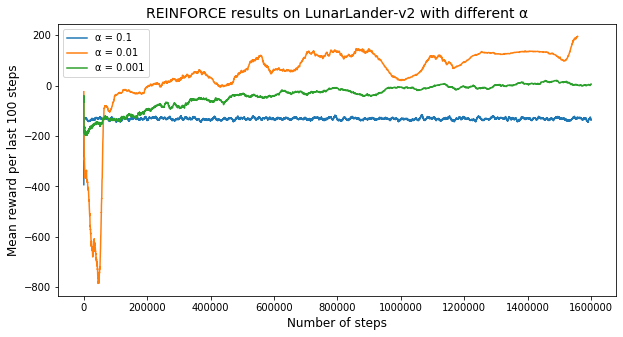

In [136]:
plt.figure(figsize=(10,5))
plt.plot(reinf_v3['steps'],reinf_v3['mean_reward_100_steps'])
plt.plot(reinf_v3['mean_0.01_steps'],reinf_v3['mean_0.01'])
plt.plot(reinf_v3['mean_0.001_steps'],reinf_v3['mean_0.001'])


plt.xlabel('Number of steps',fontSize=12)
plt.ylabel('Mean reward per last 100 steps',fontSize=12)

plt.legend(['α = 0.1','α = 0.01','α = 0.001'])
plt.title('REINFORCE results on LunarLander-v2 with different α',fontSize=14)
plt.show()

**Conclusion:**

We see that learning rate has significant impact on convergence of policy gradient algorithm. We also can say that policy gradient without any baseline is a highly unstable algorithm.  

### Advantage Actor Critic Algorithm

Creating costructor for A2C (there are two neural networks heads in the class (actor and critic)):

In [103]:
class A2C(nn.Module):
     """
    A2C-Advantage Actor Critic (has two function approximators):
    
    - input size: number of observation states in environment
    - n_actions: number of actions in environment
    
    We will use neural network with one hidden layer, which 
    has one hidden layer with 128 neurons and ReLU activation function, 
    as was described in report. So, our vector of \theta parameters 
    will have 128 elements. 
    
    """
    # initialization function
    def __init__(self, input_size, n_actions):
        super(A2C, self).__init__()
        # Creating a simple neural network with 128 parameters \theta
        # in one hidden layer 
        # Softmax activation will be done in the algorithm later.
        self.policy = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
        # Creating a simple neural network with 128 parameters \w
        # in one hidden layer 
        self.value = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    # forward propagation function
    def forward(self, x):
        return self.policy(x), self.value(x)

Defining function that will iterate over batch of state-action pairs and assign value to each of those:

In [ ]:
def batch_transform(batch, net, device='cpu'):
    """
    Transforming batch of data into training tensors
    batch: (states, actions, rewards)
    return: states variable, actions tensor, reference values variable
    """
    #create empty lists
    states = []
    actions = []
    rewards = []
    #list for index
    not_done_idx = []
    last_states = []
    #loop over every experience step in a batch
    for idx, exp in enumerate(batch):
        #save triples (s,v,a)
        states.append(np.array(exp.state, copy=False))
        actions.append(int(exp.action))
        rewards.append(exp.reward)
        #check whether las state is given
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(np.array(exp.last_state, copy=False))
    #convering to FloatTensor
    states_v = torch.FloatTensor(states).to(device)
    actions_t = torch.LongTensor(actions).to(device)
    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    #if episode are not done apply network and collect rewards:
    if not_done_idx:
        last_states_v = torch.FloatTensor(last_states).to(device)
        last_vals_v = net(last_states_v)[1]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        rewards_np[not_done_idx] += GAMMA ** REWARD_STEPS * last_vals_np
    # 
    ref_vals_v = torch.FloatTensor(rewards_np).to(device)
    return states_v, actions_t, ref_vals_v


Let's run our training. You may install tensorboardX and use Summary writer so that you don't need to print anything or create lists as in previous procedure.

In [ ]:
# import SummaryWriter to save results
from tensorboardX import SummaryWriter

GAMMA = 0.99
LEARNING_RATE = 0.005
ENTROPY_BETA = 0.01

#will be doing some gradient clipping so as gradient wouldn't explode
CLIP_GRAD = 0.1


#we use CPU
device = torch.device('cpu')
#writing to tensorboardX
writer = SummaryWriter(comment="-lander-a2c_")
# creating function to iterate via environments
make_env = lambda: gym.make("LunarLander-v2")

#creating list of environments to train with
envs = [make_env() for _ in range(50)]

#creating actor critic net
net = A2C(envs[0].observation_space.shape[0], envs[0].action_space.n).to(device)
print(net)

# creating agent with experience sourse as in REINFORCE that will
# run 10 steps in a row as in REINFORCE
agent = ptan.agent.PolicyAgent(lambda x: net(x)[0], apply_softmax=True, device=device)
exp_source = ptan.experience.ExperienceSourceFirstLast(envs, agent, gamma=GAMMA, steps_count=10)

#creating Adam agent
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, eps=1e-3)

batch = []
done_episodes = 0
step_idx = 0
total_rewards = []
    
#iterate of each step of environment until the last batch    
for step_idx, exp in enumerate(exp_source):
    batch.append(exp)
    
    new_rewards = exp_source.pop_total_rewards()
    #check whether episode ended since pop_total_rewards() outputs value only
    #in this case
    if new_rewards:
        done_episodes += 1
        reward = new_rewards[0]
        total_rewards.append(reward)
        # calculate mean reward per last 100 steps;
            # episode can contain more but we assume
            # that environment is solved if mean reward 
            # per 100 steps > 195
        mean_rewards = float(np.mean(total_rewards[-100:]))
        #writing to tensorboardX
        writer.add_scalar("reward_100", mean_rewards, step_idx)
        #check whether it is solved:
        if mean_rewards > 195:
            print("Solved in %d steps and %d episodes!" % (step_idx, done_episodes))
            break
        
        
    #we will use batch of size 128 for one iteration
    if len(batch) < 128:
        continue
    
    
    states_v, actions_t, vals_ref_v = batch_transform(batch, net, device=device)
    batch.clear()
    # setting the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes
    optimizer.zero_grad()
    #performing forward propagation
    logits_v, value_v = net(states_v)
    loss_value_v = F.mse_loss(value_v.squeeze(-1), vals_ref_v)
    # finding probabilities for actions 
    log_prob_v = F.log_softmax(logits_v, dim=1)
    # this is our Advantage value
    adv_v = vals_ref_v - value_v.detach()
    log_prob_actions_v = adv_v * log_prob_v[range(BATCH_SIZE), actions_t]
    loss_policy_v = -log_prob_actions_v.mean()
    #calculating probabilities in order to calculate our entropy loss for 
    prob_v = F.softmax(logits_v, dim=1)
    entropy_loss_v = ENTROPY_BETA * (prob_v * log_prob_v).sum(dim=1).mean()

    # calculate policy gradients only
    loss_policy_v.backward(retain_graph=True)
    grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                        for p in net.parameters()
                                        if p.grad is not None])

    # apply entropy and value gradients
    loss_v = entropy_loss_v + loss_value_v
    #doing backprop
    loss_v.backward()
    #performing gradient clipping so that there is no gradient explosion
    nn_utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
    #update values of network parametes
    optimizer.step()
                # get full loss
    loss_v += loss_policy_v
writer.close()

We downloaded csv-file created by tensorboardX after running command 
"tensorboard --logdir runs --host localhost". Let's now import it and compare A2C with the best result of REINFORCE:

In [128]:
df_a2c = pd.read_csv('run-Mar02_18-35-05_alexus-Vostro-3558-lander-a2c-tag-reward_100.csv')

In [133]:
reinf_v3['mean_a2c'] = df_a2c['Value']
reinf_v3['steps_a2c'] = df_a2c['Step']

Plotting:

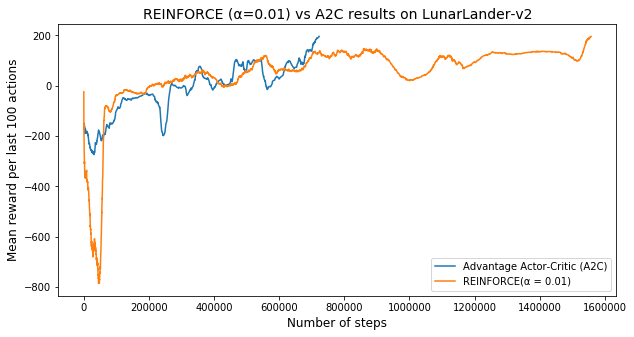

In [134]:
plt.figure(figsize=(10,5))
plt.plot(reinf_v3['steps_a2c'],reinf_v3['mean_a2c'])
plt.plot(reinf_v3['mean_0.01_steps'],reinf_v3['mean_0.01'])

plt.xlabel('Number of steps',fontSize=12)
plt.ylabel('Mean reward per last 100 steps',fontSize=12)

plt.legend(['Advantage Actor-Critic (A2C)','REINFORCE(α = 0.01)'])
plt.title('REINFORCE (α=0.01) vs A2C results on LunarLander-v2',fontSize=14)
plt.show()

**Conclusion**:

We clearly see that despite being also a little bit noisy, A2C was faster in solving environment and A2C variance is stabilized.